In [1]:
####SUCCESFUL: IMPORTANT

import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
import matplotlib as mpl

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:2


In [ ]:
# def true_2D_1(xt): #True function for 2D_1 Klein Gordon Equation x \in [-50,50] , t \in [0,10]
#     y = xt[:,0]*np.cos(xt[:,1])
#     return y.reshape(-1,1)    

In [2]:
#Material Properties This link - https://www.mathworks.com/help/pde/ug/nonlinear-heat-transfer-in-a-thin-plate.html#heatTransferThinPlateExample-1
k = 400
rho = 8960
cp = 386
t_z = 0.01
stef_bolt = 5.670373e-8
hc = 1
Ta = 300
emiss = 0.5


In [3]:
label = "Thinplate_tanh"

x = np.linspace(0,1,250).reshape(-1,1)
y = np.linspace(0,1,250).reshape(-1,1)
#t = np.linspace(0,1,100).reshape(-1,1) #t is actually from 0 to 5000, let us scale it to 0 to 1

X,Y = np.meshgrid(x,y)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
 
xy = np.hstack((X,Y))

#initial_pts = np.logical_and(T==0,Y!=0).reshape(-1,)

DBC_pts = (Y == 0).reshape(-1,)


NBC_pts_x0 = (X == 0).reshape(-1,)
NBC_pts_x1 = (X == 1).reshape(-1,)

NBC_pts_y0 = (Y == 0).reshape(-1,)
NBC_pts_y1 = (Y == 1).reshape(-1,)

#xy_initial = xyt[initial_pts,:]
xy_DBC = xy[DBC_pts,:]

xy_NBC_x0 = xy[NBC_pts_x0,:]
xy_NBC_x1 = xy[NBC_pts_x1,:]

#xyt_NBC_y0 = xyt[NBC_pts_y0,:]
xy_NBC_y1 = xy[NBC_pts_y1,:]

#u_initial = np.zeros((np.shape(xy_initial)[0],1))
u_DBC = 1000*np.ones((np.shape(xy_DBC)[0],1)) 

#xy_I_DBC = np.vstack((xy_initial,xyt_DBC))
#xyt_NBC = np.vstack((xyt_NBC_1,xyt_NBC_2,xyt_NBC_3,xyt_NBC_4))
xy_NBC_x = np.vstack((xy_NBC_x0,xy_NBC_x1))
#xyt_NBC_y = np.vstack((xyt_NBC_y0,xyt_NBC_y1))
xy_NBC_y = np.vstack((xy_NBC_y1))

#u_I_DBC = np.vstack((u_initial,u_DBC))

xy_test_tensor = torch.from_numpy(xy).float().to(device)

lb_xy = xy[0]
ub_xy = xy[-1]

In [4]:
def trainingdata(N_D,N_N,N_f,seed):
    '''Boundary Conditions''' 
    
    np.random.seed(seed)
    
    #choose random N_u points for training
    idx = np.random.choice(xy_DBC.shape[0], N_D, replace=False) 
    xy_D = xy_DBC[idx,:] #choose indices from  set 'idx' (x,t)
    u_D = u_DBC[idx].reshape(-1,1)      #choose corresponding u

    idx = np.random.choice(xy_NBC_x.shape[0], N_D, replace=False) 
    xy_Nx = xy_NBC_x[idx,:] #choose indices from  set 'idx' (x,t)

    idx = np.random.choice(xy_NBC_y.shape[0], N_D, replace=False) 
    xy_Ny = xy_NBC_y[idx,:] #choose indices from  set 'idx' (x,t)

    '''Collocation Points'''
    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x01 = np.array([[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    samples = sampling(N_f)
    
    xy_coll = lb_xy + (ub_xy - lb_xy)*samples
    xy_coll = np.vstack((xy_coll, xy_D,xy_Nx,xy_Ny)) # append training points to collocation points 

    return xy_coll, xy_D, u_D, xy_Nx,xy_Ny

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
        self.beta = Parameter(torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True
        
        self.train_loss = []
        self.test_loss = []
        
        self.beta_val = []
        
        self.n = torch.tensor(1.0)
            
    'foward pass'
    def forward(self,xy):
        if torch.is_tensor(xy) != True:         
            xy = torch.from_numpy(xy)                
        
        ubxy = torch.from_numpy(ub_xy).float().to(device)
        lbxy = torch.from_numpy(lb_xy).float().to(device)

                      
        #preprocessing input 
        xy = (xy - lbxy)/(ubxy - lbxy)
        
        #convert to float
        a = xy.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z) 
            #a = z1 + self.beta[:,i]*z*z1
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_D(self,xy_D,u_D):
                
        loss_bc = self.loss_function(self.forward(xy_D), u_D)
                
        return loss_bc
    
    def loss_N(self,xy_Nx,xy_Ny,N_hat):
        
        g1 = xy_Nx.clone()             
        g1.requires_grad = True
        u1 = self.forward(g1)
        
        u1_x_y = autograd.grad(u1,g1,torch.ones([xy_Nx.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du1_dx = u1_x_y[:,[0]]
        
        g2 = xy_Ny.clone()             
        g2.requires_grad = True
        u2 = self.forward(g2)
        
        u2_x_y = autograd.grad(u2,g2,torch.ones([xy_Ny.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du2_dy = u2_x_y[:,[1]]
               
        loss_N1 = self.loss_function(du1_dx,N_hat)
        loss_N2 = self.loss_function(du2_dy,N_hat)
        
        #return loss_N1+loss_N2       
        return loss_N1 + loss_N2
    
    def loss_PDE(self, xy_coll, f_hat):
        
        g = xy_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y = autograd.grad(u,g,torch.ones([xy_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_yy = autograd.grad(u_x_y,g,torch.ones(xy_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        #du_dt = u_x_y_t[:,[2]]
        
        d2u_dx2 = u_xx_yy[:,[0]]
        d2u_dy2 = u_xx_yy[:,[1]]    
        

        f = -k*t_z*(d2u_dx2+d2u_dy2) + 2*hc*(u-Ta) + 2*emiss*stef_bolt*(torch.pow(u,4)-(Ta)**4) 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xy_D,u_D,xy_Nx,xy_Ny,N_hat,xy_coll,f_hat):

        loss_D = self.loss_D(xy_D,u_D)
        loss_N = self.loss_N(xy_Nx,xy_Ny,N_hat)
        loss_f = self.loss_PDE(xy_coll,f_hat)
        
        loss_val = loss_D + loss_N + loss_f
        
        #print(self.iter,"loss_D:",loss_D.cpu().detach().numpy(),"loss_N:",loss_N.cpu().detach().numpy(),"loss_f:",loss_f.cpu().detach().numpy())
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        optimizer.zero_grad()
        
        loss = self.loss(xy_D,u_D,xy_Nx,xy_Ny,N_hat,xy_coll,f_hat)
        self.train_loss.append(loss.cpu().detach().numpy())
        
        u_pred = self.test(xy_test_tensor)
        #self.test_loss.append(np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))) #Commented because no true values yet
        self.beta_val.append(self.beta.cpu().detach().numpy())
        
        #print(self.iter,"Train Loss",self.train_loss[-1],"Test Loss",self.test_loss[-1])
        print(self.iter,"Train Loss",self.train_loss[-1])
        
        loss.backward()
        self.iter += 1
  

        return loss        
    'test neural network'
    def test(self,xy_test_tensor):
        u_pred = self.forward(xy_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

In [6]:
max_reps = 10

train_loss_full = []
test_loss_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))

for reps in range(max_reps):
    print(reps)
    
    torch.manual_seed(reps*36)
    N_D = 100 #Total number of data points for 'y'
    N_N = 3500
    N_f = 10000 #Total number of collocation points 
    
    xy_coll_np_array, xy_D_np_array, u_D_np_array,xy_Nx_np_array,xy_Ny_np_array = trainingdata(N_D,N_N,N_f,(reps)*22)
        
    xy_coll = torch.from_numpy(xy_coll_np_array).float().to(device)
    xy_D = torch.from_numpy(xy_D_np_array).float().to(device)
    u_D = torch.from_numpy(u_D_np_array).float().to(device)
    xy_Nx = torch.from_numpy(xy_Nx_np_array).float().to(device)
    xy_Ny = torch.from_numpy(xy_Ny_np_array).float().to(device)
        
    N_hat = torch.zeros(xy_Nx.shape[0],1).to(device)    
    f_hat = torch.zeros(xy_coll.shape[0],1).to(device)

    layers = np.array([2,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers
    #layers = np.array([3,100,100,100,100,100,100,100,1])

    PINN = Sequentialmodel(layers)
   
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())
    
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=1, 
                              max_iter = 5000, 
                              max_eval = None, 
                              tolerance_grad = -1, 
                              tolerance_change = -1, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')



    start_time = time.time()
        
    optimizer.step(PINN.closure)
    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(PINN.train_loss)
    test_loss_full.append(PINN.test_loss)
    elapsed_time[reps] = time.time() - start_time
    beta_full.append(PINN.beta_val)


    print('Training time: %.2f' % (elapsed_time[reps]))
    
mdic = {"train_loss": train_loss_full,"test_loss": test_loss_full,"Time": elapsed_time, "beta": beta_full, "label": label}
savemat(label+'.mat', mdic)

0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0 Train Loss 2122402.5
1 Train Loss 2121530.5
2 Train Loss 2114023.2
3 Train Loss 2090497.9
4 Train Loss 2033673.2
5 Train Loss 2033659.6
6 Train Loss 2001547.0
7 Train Loss 71611180.0
8 Train Loss 4290663.5
9 Train Loss 2015545.2
10 Train Loss 1994894.0
11 Train Loss 1957965.5
12 Train Loss 2017400

313 Train Loss 483189.6
314 Train Loss 483189.6
315 Train Loss 483189.6
316 Train Loss 483189.62
317 Train Loss 483189.6
318 Train Loss 483189.66
319 Train Loss 483189.6
320 Train Loss 483189.6
321 Train Loss 483189.6
322 Train Loss 483189.6
323 Train Loss 483189.6
324 Train Loss 483189.62
325 Train Loss 483189.6
326 Train Loss 483189.66
327 Train Loss 483189.6
328 Train Loss 483189.6
329 Train Loss 483189.6
330 Train Loss 483189.6
331 Train Loss 483189.6
332 Train Loss 483189.62
333 Train Loss 483189.6
334 Train Loss 483189.66
335 Train Loss 483189.6
336 Train Loss 483189.6
337 Train Loss 483189.6
338 Train Loss 483189.6
339 Train Loss 483189.6
340 Train Loss 483189.62
341 Train Loss 483189.6
342 Train Loss 483189.66
343 Train Loss 483189.6
344 Train Loss 483189.6
345 Train Loss 483189.6
346 Train Loss 483189.6
347 Train Loss 483189.6
348 Train Loss 483189.62
349 Train Loss 483189.6
350 Train Loss 483189.66
351 Train Loss 483189.6
352 Train Loss 483189.6
353 Train Loss 483189.6
354 Tr

654 Train Loss 483189.66
655 Train Loss 483189.6
656 Train Loss 483189.6
657 Train Loss 483189.6
658 Train Loss 483189.6
659 Train Loss 483189.6
660 Train Loss 483189.62
661 Train Loss 483189.6
662 Train Loss 483189.66
663 Train Loss 483189.6
664 Train Loss 483189.6
665 Train Loss 483189.6
666 Train Loss 483189.6
667 Train Loss 483189.6
668 Train Loss 483189.62
669 Train Loss 483189.6
670 Train Loss 483189.66
671 Train Loss 483189.6
672 Train Loss 483189.6
673 Train Loss 483189.6
674 Train Loss 483189.6
675 Train Loss 483189.6
676 Train Loss 483189.62
677 Train Loss 483189.6
678 Train Loss 483189.66
679 Train Loss 483189.6
680 Train Loss 483189.6
681 Train Loss 483189.6
682 Train Loss 483189.6
683 Train Loss 483189.6
684 Train Loss 483189.62
685 Train Loss 483189.6
686 Train Loss 483189.66
687 Train Loss 483189.6
688 Train Loss 483189.6
689 Train Loss 483189.6
690 Train Loss 483189.6
691 Train Loss 483189.6
692 Train Loss 483189.62
693 Train Loss 483189.6
694 Train Loss 483189.66
695 T

996 Train Loss 483189.62
997 Train Loss 483189.6
998 Train Loss 483189.66
999 Train Loss 483189.6
1000 Train Loss 483189.6
1001 Train Loss 483189.6
1002 Train Loss 483189.6
1003 Train Loss 483189.6
1004 Train Loss 483189.62
1005 Train Loss 483189.6
1006 Train Loss 483189.66
1007 Train Loss 483189.6
1008 Train Loss 483189.6
1009 Train Loss 483189.6
1010 Train Loss 483189.6
1011 Train Loss 483189.6
1012 Train Loss 483189.62
1013 Train Loss 483189.6
1014 Train Loss 483189.66
1015 Train Loss 483189.6
1016 Train Loss 483189.6
1017 Train Loss 483189.6
1018 Train Loss 483189.6
1019 Train Loss 483189.6
1020 Train Loss 483189.62
1021 Train Loss 483189.6
1022 Train Loss 483189.66
1023 Train Loss 483189.6
1024 Train Loss 483189.6
1025 Train Loss 483189.6
1026 Train Loss 483189.6
1027 Train Loss 483189.6
1028 Train Loss 483189.62
1029 Train Loss 483189.6
1030 Train Loss 483189.66
1031 Train Loss 483189.6
1032 Train Loss 483189.6
1033 Train Loss 483189.6
1034 Train Loss 483189.6
1035 Train Loss 483

1326 Train Loss 483189.66
1327 Train Loss 483189.6
1328 Train Loss 483189.6
1329 Train Loss 483189.6
1330 Train Loss 483189.6
1331 Train Loss 483189.6
1332 Train Loss 483189.62
1333 Train Loss 483189.6
1334 Train Loss 483189.66
1335 Train Loss 483189.6
1336 Train Loss 483189.6
1337 Train Loss 483189.6
1338 Train Loss 483189.6
1339 Train Loss 483189.6
1340 Train Loss 483189.62
1341 Train Loss 483189.6
1342 Train Loss 483189.66
1343 Train Loss 483189.6
1344 Train Loss 483189.6
1345 Train Loss 483189.6
1346 Train Loss 483189.6
1347 Train Loss 483189.6
1348 Train Loss 483189.62
1349 Train Loss 483189.6
1350 Train Loss 483189.66
1351 Train Loss 483189.6
1352 Train Loss 483189.6
1353 Train Loss 483189.6
1354 Train Loss 483189.6
1355 Train Loss 483189.6
1356 Train Loss 483189.62
1357 Train Loss 483189.6
1358 Train Loss 483189.66
1359 Train Loss 483189.6
1360 Train Loss 483189.6
1361 Train Loss 483189.6
1362 Train Loss 483189.6
1363 Train Loss 483189.6
1364 Train Loss 483189.62
1365 Train Loss

1654 Train Loss 483189.66
1655 Train Loss 483189.6
1656 Train Loss 483189.6
1657 Train Loss 483189.6
1658 Train Loss 483189.6
1659 Train Loss 483189.6
1660 Train Loss 483189.62
1661 Train Loss 483189.6
1662 Train Loss 483189.66
1663 Train Loss 483189.6
1664 Train Loss 483189.6
1665 Train Loss 483189.6
1666 Train Loss 483189.6
1667 Train Loss 483189.6
1668 Train Loss 483189.62
1669 Train Loss 483189.6
1670 Train Loss 483189.66
1671 Train Loss 483189.6
1672 Train Loss 483189.6
1673 Train Loss 483189.6
1674 Train Loss 483189.6
1675 Train Loss 483189.6
1676 Train Loss 483189.62
1677 Train Loss 483189.6
1678 Train Loss 483189.66
1679 Train Loss 483189.6
1680 Train Loss 483189.6
1681 Train Loss 483189.6
1682 Train Loss 483189.6
1683 Train Loss 483189.6
1684 Train Loss 483189.62
1685 Train Loss 483189.6
1686 Train Loss 483189.66
1687 Train Loss 483189.6
1688 Train Loss 483189.6
1689 Train Loss 483189.6
1690 Train Loss 483189.6
1691 Train Loss 483189.6
1692 Train Loss 483189.62
1693 Train Loss

1984 Train Loss 483189.6
1985 Train Loss 483189.6
1986 Train Loss 483189.6
1987 Train Loss 483189.6
1988 Train Loss 483189.62
1989 Train Loss 483189.6
1990 Train Loss 483189.66
1991 Train Loss 483189.6
1992 Train Loss 483189.6
1993 Train Loss 483189.6
1994 Train Loss 483189.6
1995 Train Loss 483189.6
1996 Train Loss 483189.62
1997 Train Loss 483189.6
1998 Train Loss 483189.66
1999 Train Loss 483189.6
2000 Train Loss 483189.6
2001 Train Loss 483189.6
2002 Train Loss 483189.6
2003 Train Loss 483189.6
2004 Train Loss 483189.62
2005 Train Loss 483189.6
2006 Train Loss 483189.66
2007 Train Loss 483189.6
2008 Train Loss 483189.6
2009 Train Loss 483189.6
2010 Train Loss 483189.6
2011 Train Loss 483189.6
2012 Train Loss 483189.62
2013 Train Loss 483189.6
2014 Train Loss 483189.66
2015 Train Loss 483189.6
2016 Train Loss 483189.6
2017 Train Loss 483189.6
2018 Train Loss 483189.6
2019 Train Loss 483189.6
2020 Train Loss 483189.62
2021 Train Loss 483189.6
2022 Train Loss 483189.66
2023 Train Loss

2310 Train Loss 483189.66
2311 Train Loss 483189.6
2312 Train Loss 483189.6
2313 Train Loss 483189.6
2314 Train Loss 483189.6
2315 Train Loss 483189.6
2316 Train Loss 483189.62
2317 Train Loss 483189.6
2318 Train Loss 483189.66
2319 Train Loss 483189.6
2320 Train Loss 483189.6
2321 Train Loss 483189.6
2322 Train Loss 483189.6
2323 Train Loss 483189.6
2324 Train Loss 483189.62
2325 Train Loss 483189.6
2326 Train Loss 483189.66
2327 Train Loss 483189.6
2328 Train Loss 483189.6
2329 Train Loss 483189.6
2330 Train Loss 483189.6
2331 Train Loss 483189.6
2332 Train Loss 483189.62
2333 Train Loss 483189.6
2334 Train Loss 483189.66
2335 Train Loss 483189.6
2336 Train Loss 483189.6
2337 Train Loss 483189.6
2338 Train Loss 483189.6
2339 Train Loss 483189.6
2340 Train Loss 483189.62
2341 Train Loss 483189.6
2342 Train Loss 483189.66
2343 Train Loss 483189.6
2344 Train Loss 483189.6
2345 Train Loss 483189.6
2346 Train Loss 483189.6
2347 Train Loss 483189.6
2348 Train Loss 483189.62
2349 Train Loss

2638 Train Loss 483189.66
2639 Train Loss 483189.6
2640 Train Loss 483189.6
2641 Train Loss 483189.6
2642 Train Loss 483189.6
2643 Train Loss 483189.6
2644 Train Loss 483189.62
2645 Train Loss 483189.6
2646 Train Loss 483189.66
2647 Train Loss 483189.6
2648 Train Loss 483189.6
2649 Train Loss 483189.6
2650 Train Loss 483189.6
2651 Train Loss 483189.6
2652 Train Loss 483189.62
2653 Train Loss 483189.6
2654 Train Loss 483189.66
2655 Train Loss 483189.6
2656 Train Loss 483189.6
2657 Train Loss 483189.6
2658 Train Loss 483189.6
2659 Train Loss 483189.6
2660 Train Loss 483189.62
2661 Train Loss 483189.6
2662 Train Loss 483189.66
2663 Train Loss 483189.6
2664 Train Loss 483189.6
2665 Train Loss 483189.6
2666 Train Loss 483189.6
2667 Train Loss 483189.6
2668 Train Loss 483189.62
2669 Train Loss 483189.6
2670 Train Loss 483189.66
2671 Train Loss 483189.6
2672 Train Loss 483189.6
2673 Train Loss 483189.6
2674 Train Loss 483189.6
2675 Train Loss 483189.6
2676 Train Loss 483189.62
2677 Train Loss

2968 Train Loss 483189.6
2969 Train Loss 483189.6
2970 Train Loss 483189.6
2971 Train Loss 483189.6
2972 Train Loss 483189.62
2973 Train Loss 483189.6
2974 Train Loss 483189.66
2975 Train Loss 483189.6
2976 Train Loss 483189.6
2977 Train Loss 483189.6
2978 Train Loss 483189.6
2979 Train Loss 483189.6
2980 Train Loss 483189.62
2981 Train Loss 483189.6
2982 Train Loss 483189.66
2983 Train Loss 483189.6
2984 Train Loss 483189.6
2985 Train Loss 483189.6
2986 Train Loss 483189.6
2987 Train Loss 483189.6
2988 Train Loss 483189.62
2989 Train Loss 483189.6
2990 Train Loss 483189.66
2991 Train Loss 483189.6
2992 Train Loss 483189.6
2993 Train Loss 483189.6
2994 Train Loss 483189.6
2995 Train Loss 483189.6
2996 Train Loss 483189.62
2997 Train Loss 483189.6
2998 Train Loss 483189.66
2999 Train Loss 483189.6
3000 Train Loss 483189.6
3001 Train Loss 483189.6
3002 Train Loss 483189.6
3003 Train Loss 483189.6
3004 Train Loss 483189.62
3005 Train Loss 483189.6
3006 Train Loss 483189.66
3007 Train Loss

3297 Train Loss 483189.6
3298 Train Loss 483189.6
3299 Train Loss 483189.6
3300 Train Loss 483189.62
3301 Train Loss 483189.6
3302 Train Loss 483189.66
3303 Train Loss 483189.6
3304 Train Loss 483189.6
3305 Train Loss 483189.6
3306 Train Loss 483189.6
3307 Train Loss 483189.6
3308 Train Loss 483189.62
3309 Train Loss 483189.6
3310 Train Loss 483189.66
3311 Train Loss 483189.6
3312 Train Loss 483189.6
3313 Train Loss 483189.6
3314 Train Loss 483189.6
3315 Train Loss 483189.6
3316 Train Loss 483189.62
3317 Train Loss 483189.6
3318 Train Loss 483189.66
3319 Train Loss 483189.6
3320 Train Loss 483189.6
3321 Train Loss 483189.6
3322 Train Loss 483189.6
3323 Train Loss 483189.6
3324 Train Loss 483189.62
3325 Train Loss 483189.6
3326 Train Loss 483189.66
3327 Train Loss 483189.6
3328 Train Loss 483189.6
3329 Train Loss 483189.6
3330 Train Loss 483189.6
3331 Train Loss 483189.6
3332 Train Loss 483189.62
3333 Train Loss 483189.6
3334 Train Loss 483189.66
3335 Train Loss 483189.6
3336 Train Loss

3626 Train Loss 483189.6
3627 Train Loss 483189.6
3628 Train Loss 483189.62
3629 Train Loss 483189.6
3630 Train Loss 483189.66
3631 Train Loss 483189.6
3632 Train Loss 483189.6
3633 Train Loss 483189.6
3634 Train Loss 483189.6
3635 Train Loss 483189.6
3636 Train Loss 483189.62
3637 Train Loss 483189.6
3638 Train Loss 483189.66
3639 Train Loss 483189.6
3640 Train Loss 483189.6
3641 Train Loss 483189.6
3642 Train Loss 483189.6
3643 Train Loss 483189.6
3644 Train Loss 483189.62
3645 Train Loss 483189.6
3646 Train Loss 483189.66
3647 Train Loss 483189.6
3648 Train Loss 483189.6
3649 Train Loss 483189.6
3650 Train Loss 483189.6
3651 Train Loss 483189.6
3652 Train Loss 483189.62
3653 Train Loss 483189.6
3654 Train Loss 483189.66
3655 Train Loss 483189.6
3656 Train Loss 483189.6
3657 Train Loss 483189.6
3658 Train Loss 483189.6
3659 Train Loss 483189.6
3660 Train Loss 483189.62
3661 Train Loss 483189.6
3662 Train Loss 483189.66
3663 Train Loss 483189.6
3664 Train Loss 483189.6
3665 Train Loss

3955 Train Loss 483189.6
3956 Train Loss 483189.62
3957 Train Loss 483189.6
3958 Train Loss 483189.66
3959 Train Loss 483189.6
3960 Train Loss 483189.6
3961 Train Loss 483189.6
3962 Train Loss 483189.6
3963 Train Loss 483189.6
3964 Train Loss 483189.62
3965 Train Loss 483189.6
3966 Train Loss 483189.66
3967 Train Loss 483189.6
3968 Train Loss 483189.6
3969 Train Loss 483189.6
3970 Train Loss 483189.6
3971 Train Loss 483189.6
3972 Train Loss 483189.62
3973 Train Loss 483189.6
3974 Train Loss 483189.66
3975 Train Loss 483189.6
3976 Train Loss 483189.6
3977 Train Loss 483189.6
3978 Train Loss 483189.6
3979 Train Loss 483189.6
3980 Train Loss 483189.62
3981 Train Loss 483189.6
3982 Train Loss 483189.66
3983 Train Loss 483189.6
3984 Train Loss 483189.6
3985 Train Loss 483189.6
3986 Train Loss 483189.6
3987 Train Loss 483189.6
3988 Train Loss 483189.62
3989 Train Loss 483189.6
3990 Train Loss 483189.66
3991 Train Loss 483189.6
3992 Train Loss 483189.6
3993 Train Loss 483189.6
3994 Train Loss

4282 Train Loss 483189.6
4283 Train Loss 483189.6
4284 Train Loss 483189.62
4285 Train Loss 483189.6
4286 Train Loss 483189.66
4287 Train Loss 483189.6
4288 Train Loss 483189.6
4289 Train Loss 483189.6
4290 Train Loss 483189.6
4291 Train Loss 483189.6
4292 Train Loss 483189.62
4293 Train Loss 483189.6
4294 Train Loss 483189.66
4295 Train Loss 483189.6
4296 Train Loss 483189.6
4297 Train Loss 483189.6
4298 Train Loss 483189.6
4299 Train Loss 483189.6
4300 Train Loss 483189.62
4301 Train Loss 483189.6
4302 Train Loss 483189.66
4303 Train Loss 483189.6
4304 Train Loss 483189.6
4305 Train Loss 483189.6
4306 Train Loss 483189.6
4307 Train Loss 483189.6
4308 Train Loss 483189.62
4309 Train Loss 483189.6
4310 Train Loss 483189.66
4311 Train Loss 483189.6
4312 Train Loss 483189.6
4313 Train Loss 483189.6
4314 Train Loss 483189.6
4315 Train Loss 483189.6
4316 Train Loss 483189.62
4317 Train Loss 483189.6
4318 Train Loss 483189.66
4319 Train Loss 483189.6
4320 Train Loss 483189.6
4321 Train Loss

4607 Train Loss 483189.6
4608 Train Loss 483189.6
4609 Train Loss 483189.6
4610 Train Loss 483189.6
4611 Train Loss 483189.6
4612 Train Loss 483189.62
4613 Train Loss 483189.6
4614 Train Loss 483189.66
4615 Train Loss 483189.6
4616 Train Loss 483189.6
4617 Train Loss 483189.6
4618 Train Loss 483189.6
4619 Train Loss 483189.6
4620 Train Loss 483189.62
4621 Train Loss 483189.6
4622 Train Loss 483189.66
4623 Train Loss 483189.6
4624 Train Loss 483189.6
4625 Train Loss 483189.6
4626 Train Loss 483189.6
4627 Train Loss 483189.6
4628 Train Loss 483189.62
4629 Train Loss 483189.6
4630 Train Loss 483189.66
4631 Train Loss 483189.6
4632 Train Loss 483189.6
4633 Train Loss 483189.6
4634 Train Loss 483189.6
4635 Train Loss 483189.6
4636 Train Loss 483189.62
4637 Train Loss 483189.6
4638 Train Loss 483189.66
4639 Train Loss 483189.6
4640 Train Loss 483189.6
4641 Train Loss 483189.6
4642 Train Loss 483189.6
4643 Train Loss 483189.6
4644 Train Loss 483189.62
4645 Train Loss 483189.6
4646 Train Loss 

4934 Train Loss 483189.66
4935 Train Loss 483189.6
4936 Train Loss 483189.6
4937 Train Loss 483189.6
4938 Train Loss 483189.6
4939 Train Loss 483189.6
4940 Train Loss 483189.62
4941 Train Loss 483189.6
4942 Train Loss 483189.66
4943 Train Loss 483189.6
4944 Train Loss 483189.6
4945 Train Loss 483189.6
4946 Train Loss 483189.6
4947 Train Loss 483189.6
4948 Train Loss 483189.62
4949 Train Loss 483189.6
4950 Train Loss 483189.66
4951 Train Loss 483189.6
4952 Train Loss 483189.6
4953 Train Loss 483189.6
4954 Train Loss 483189.6
4955 Train Loss 483189.6
4956 Train Loss 483189.62
4957 Train Loss 483189.6
4958 Train Loss 483189.66
4959 Train Loss 483189.6
4960 Train Loss 483189.6
4961 Train Loss 483189.6
4962 Train Loss 483189.6
4963 Train Loss 483189.6
4964 Train Loss 483189.62
4965 Train Loss 483189.6
4966 Train Loss 483189.66
4967 Train Loss 483189.6
4968 Train Loss 483189.6
4969 Train Loss 483189.6
4970 Train Loss 483189.6
4971 Train Loss 483189.6
4972 Train Loss 483189.62
4973 Train Loss

5263 Train Loss 483189.6
5264 Train Loss 483189.6
5265 Train Loss 483189.6
5266 Train Loss 483189.6
5267 Train Loss 483189.6
5268 Train Loss 483189.62
5269 Train Loss 483189.6
5270 Train Loss 483189.66
5271 Train Loss 483189.6
5272 Train Loss 483189.6
5273 Train Loss 483189.6
5274 Train Loss 483189.6
5275 Train Loss 483189.6
5276 Train Loss 483189.62
5277 Train Loss 483189.6
5278 Train Loss 483189.66
5279 Train Loss 483189.6
5280 Train Loss 483189.6
5281 Train Loss 483189.6
5282 Train Loss 483189.6
5283 Train Loss 483189.6
5284 Train Loss 483189.62
5285 Train Loss 483189.6
5286 Train Loss 483189.66
5287 Train Loss 483189.6
5288 Train Loss 483189.6
5289 Train Loss 483189.6
5290 Train Loss 483189.6
5291 Train Loss 483189.6
5292 Train Loss 483189.62
5293 Train Loss 483189.6
5294 Train Loss 483189.66
5295 Train Loss 483189.6
5296 Train Loss 483189.6
5297 Train Loss 483189.6
5298 Train Loss 483189.6
5299 Train Loss 483189.6
5300 Train Loss 483189.62
5301 Train Loss 483189.6
5302 Train Loss 

5591 Train Loss 483189.6
5592 Train Loss 483189.6
5593 Train Loss 483189.6
5594 Train Loss 483189.6
5595 Train Loss 483189.6
5596 Train Loss 483189.62
5597 Train Loss 483189.6
5598 Train Loss 483189.66
5599 Train Loss 483189.6
5600 Train Loss 483189.6
5601 Train Loss 483189.6
5602 Train Loss 483189.6
5603 Train Loss 483189.6
5604 Train Loss 483189.62
5605 Train Loss 483189.6
5606 Train Loss 483189.66
5607 Train Loss 483189.6
5608 Train Loss 483189.6
5609 Train Loss 483189.6
5610 Train Loss 483189.6
5611 Train Loss 483189.6
5612 Train Loss 483189.62
5613 Train Loss 483189.6
5614 Train Loss 483189.66
5615 Train Loss 483189.6
5616 Train Loss 483189.6
5617 Train Loss 483189.6
5618 Train Loss 483189.6
5619 Train Loss 483189.6
5620 Train Loss 483189.62
5621 Train Loss 483189.6
5622 Train Loss 483189.66
5623 Train Loss 483189.6
5624 Train Loss 483189.6
5625 Train Loss 483189.6
5626 Train Loss 483189.6
5627 Train Loss 483189.6
5628 Train Loss 483189.62
5629 Train Loss 483189.6
5630 Train Loss 

5917 Train Loss 483189.6
5918 Train Loss 483189.66
5919 Train Loss 483189.6
5920 Train Loss 483189.6
5921 Train Loss 483189.6
5922 Train Loss 483189.6
5923 Train Loss 483189.6
5924 Train Loss 483189.62
5925 Train Loss 483189.6
5926 Train Loss 483189.66
5927 Train Loss 483189.6
5928 Train Loss 483189.6
5929 Train Loss 483189.6
5930 Train Loss 483189.6
5931 Train Loss 483189.6
5932 Train Loss 483189.62
5933 Train Loss 483189.6
5934 Train Loss 483189.66
5935 Train Loss 483189.6
5936 Train Loss 483189.6
5937 Train Loss 483189.6
5938 Train Loss 483189.6
5939 Train Loss 483189.6
5940 Train Loss 483189.62
5941 Train Loss 483189.6
5942 Train Loss 483189.66
5943 Train Loss 483189.6
5944 Train Loss 483189.6
5945 Train Loss 483189.6
5946 Train Loss 483189.6
5947 Train Loss 483189.6
5948 Train Loss 483189.62
5949 Train Loss 483189.6
5950 Train Loss 483189.66
5951 Train Loss 483189.6
5952 Train Loss 483189.6
5953 Train Loss 483189.6
5954 Train Loss 483189.6
5955 Train Loss 483189.6
5956 Train Loss 

6243 Train Loss 483189.6
6244 Train Loss 483189.62
6245 Train Loss 483189.6
6246 Train Loss 483189.66
6247 Train Loss 483189.6
6248 Train Loss 483189.6
6249 Train Loss 483189.6
6250 Train Loss 483189.6
6251 Train Loss 483189.6
Training time: 243.54
1
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0 Train Loss 2120641.0
1 Train Loss 2119863.5
2 Tra

301 Train Loss 305915.53
302 Train Loss 305810.7
303 Train Loss 305701.25
304 Train Loss 305621.9
305 Train Loss 305536.38
306 Train Loss 305450.1
307 Train Loss 305335.75
308 Train Loss 305209.44
309 Train Loss 305085.97
310 Train Loss 304972.75
311 Train Loss 304877.28
312 Train Loss 304813.2
313 Train Loss 304765.9
314 Train Loss 304688.5
315 Train Loss 304620.34
316 Train Loss 304527.1
317 Train Loss 304442.2
318 Train Loss 304349.72
319 Train Loss 304194.16
320 Train Loss 304112.88
321 Train Loss 304032.4
322 Train Loss 303982.78
323 Train Loss 303916.84
324 Train Loss 303796.9
325 Train Loss 303642.34
326 Train Loss 303343.03
327 Train Loss 303403.03
328 Train Loss 303207.53
329 Train Loss 303032.84
330 Train Loss 302854.47
331 Train Loss 302800.28
332 Train Loss 302776.97
333 Train Loss 302709.84
334 Train Loss 302640.75
335 Train Loss 302590.44
336 Train Loss 302453.22
337 Train Loss 302207.62
338 Train Loss 302007.34
339 Train Loss 301801.0
340 Train Loss 301633.72
341 Train L

638 Train Loss 284805.28
639 Train Loss 284631.75
640 Train Loss 284583.16
641 Train Loss 284544.28
642 Train Loss 284515.3
643 Train Loss 284500.97
644 Train Loss 284479.6
645 Train Loss 284464.94
646 Train Loss 284441.3
647 Train Loss 284407.72
648 Train Loss 284381.8
649 Train Loss 284355.6
650 Train Loss 284322.8
651 Train Loss 284287.0
652 Train Loss 284247.03
653 Train Loss 284216.25
654 Train Loss 284168.38
655 Train Loss 284102.28
656 Train Loss 284005.12
657 Train Loss 283937.25
658 Train Loss 283861.56
659 Train Loss 283790.6
660 Train Loss 283702.8
661 Train Loss 283722.38
662 Train Loss 283615.7
663 Train Loss 283577.16
664 Train Loss 283459.38
665 Train Loss 283433.7
666 Train Loss 283402.06
667 Train Loss 283382.38
668 Train Loss 283365.3
669 Train Loss 283350.7
670 Train Loss 283331.72
671 Train Loss 283299.3
672 Train Loss 283313.12
673 Train Loss 283274.9
674 Train Loss 283205.06
675 Train Loss 283171.7
676 Train Loss 283141.94
677 Train Loss 283106.3
678 Train Loss 28

976 Train Loss 265208.88
977 Train Loss 265075.3
978 Train Loss 264934.7
979 Train Loss 264719.5
980 Train Loss 264465.22
981 Train Loss 264405.8
982 Train Loss 264243.6
983 Train Loss 264106.38
984 Train Loss 263962.62
985 Train Loss 263933.88
986 Train Loss 263860.4
987 Train Loss 263789.3
988 Train Loss 263724.1
989 Train Loss 263627.94
990 Train Loss 263548.22
991 Train Loss 263420.72
992 Train Loss 263218.28
993 Train Loss 263008.7
994 Train Loss 262826.4
995 Train Loss 263058.53
996 Train Loss 262723.3
997 Train Loss 262585.4
998 Train Loss 262497.84
999 Train Loss 262409.9
1000 Train Loss 262262.1
1001 Train Loss 262145.06
1002 Train Loss 262036.52
1003 Train Loss 261962.0
1004 Train Loss 261908.06
1005 Train Loss 261859.23
1006 Train Loss 261789.0
1007 Train Loss 261764.47
1008 Train Loss 261666.19
1009 Train Loss 261590.2
1010 Train Loss 261514.28
1011 Train Loss 261399.56
1012 Train Loss 261284.64
1013 Train Loss 261120.48
1014 Train Loss 260992.16
1015 Train Loss 260897.14
1

1299 Train Loss 247375.16
1300 Train Loss 247305.75
1301 Train Loss 247465.36
1302 Train Loss 247258.34
1303 Train Loss 247176.14
1304 Train Loss 247135.0
1305 Train Loss 247058.95
1306 Train Loss 246990.06
1307 Train Loss 246994.77
1308 Train Loss 246947.06
1309 Train Loss 246922.1
1310 Train Loss 246874.2
1311 Train Loss 246821.3
1312 Train Loss 246765.72
1313 Train Loss 246685.39
1314 Train Loss 246606.5
1315 Train Loss 246537.06
1316 Train Loss 246470.94
1317 Train Loss 246513.06
1318 Train Loss 246396.92
1319 Train Loss 246260.06
1320 Train Loss 246797.83
1321 Train Loss 246184.89
1322 Train Loss 246152.78
1323 Train Loss 246069.08
1324 Train Loss 246141.02
1325 Train Loss 245971.8
1326 Train Loss 245875.58
1327 Train Loss 245814.16
1328 Train Loss 245753.03
1329 Train Loss 245696.83
1330 Train Loss 245640.88
1331 Train Loss 245582.42
1332 Train Loss 245542.52
1333 Train Loss 245502.36
1334 Train Loss 245498.77
1335 Train Loss 245472.69
1336 Train Loss 245427.33
1337 Train Loss 24

1622 Train Loss 212970.81
1623 Train Loss 212894.75
1624 Train Loss 212880.22
1625 Train Loss 212835.86
1626 Train Loss 212741.22
1627 Train Loss 212857.16
1628 Train Loss 212697.86
1629 Train Loss 212811.47
1630 Train Loss 212624.78
1631 Train Loss 212715.27
1632 Train Loss 212572.03
1633 Train Loss 212545.0
1634 Train Loss 212509.5
1635 Train Loss 212496.02
1636 Train Loss 212486.58
1637 Train Loss 212474.6
1638 Train Loss 212471.8
1639 Train Loss 212455.25
1640 Train Loss 212446.23
1641 Train Loss 212435.05
1642 Train Loss 212424.78
1643 Train Loss 212416.8
1644 Train Loss 212406.25
1645 Train Loss 212392.75
1646 Train Loss 212371.19
1647 Train Loss 212337.95
1648 Train Loss 212309.02
1649 Train Loss 212272.5
1650 Train Loss 212238.45
1651 Train Loss 212203.89
1652 Train Loss 212164.5
1653 Train Loss 212111.16
1654 Train Loss 212086.47
1655 Train Loss 212061.3
1656 Train Loss 211976.81
1657 Train Loss 211933.28
1658 Train Loss 211889.44
1659 Train Loss 211866.34
1660 Train Loss 2118

1943 Train Loss 204571.2
1944 Train Loss 204552.27
1945 Train Loss 204521.6
1946 Train Loss 204500.1
1947 Train Loss 204479.39
1948 Train Loss 204438.17
1949 Train Loss 204404.86
1950 Train Loss 204397.11
1951 Train Loss 204378.7
1952 Train Loss 204346.22
1953 Train Loss 204318.78
1954 Train Loss 204356.55
1955 Train Loss 204305.3
1956 Train Loss 204288.55
1957 Train Loss 204254.58
1958 Train Loss 204240.22
1959 Train Loss 204227.52
1960 Train Loss 204199.42
1961 Train Loss 204175.84
1962 Train Loss 204153.88
1963 Train Loss 204128.6
1964 Train Loss 204104.5
1965 Train Loss 204089.3
1966 Train Loss 204084.14
1967 Train Loss 204066.0
1968 Train Loss 204055.9
1969 Train Loss 204047.06
1970 Train Loss 204036.52
1971 Train Loss 204026.77
1972 Train Loss 204013.25
1973 Train Loss 204003.38
1974 Train Loss 203999.8
1975 Train Loss 203994.17
1976 Train Loss 203985.42
1977 Train Loss 203979.38
1978 Train Loss 203973.75
1979 Train Loss 203965.4
1980 Train Loss 203954.34
1981 Train Loss 203940.3

2261 Train Loss 198587.4
2262 Train Loss 198632.38
2263 Train Loss 198557.25
2264 Train Loss 198563.9
2265 Train Loss 198534.36
2266 Train Loss 198557.19
2267 Train Loss 198519.33
2268 Train Loss 198503.55
2269 Train Loss 198486.61
2270 Train Loss 198477.73
2271 Train Loss 198469.05
2272 Train Loss 198453.34
2273 Train Loss 198446.48
2274 Train Loss 198437.16
2275 Train Loss 198428.78
2276 Train Loss 198424.75
2277 Train Loss 198422.2
2278 Train Loss 198417.16
2279 Train Loss 198412.69
2280 Train Loss 198408.6
2281 Train Loss 198404.92
2282 Train Loss 198402.67
2283 Train Loss 198400.27
2284 Train Loss 198397.5
2285 Train Loss 198394.48
2286 Train Loss 198389.5
2287 Train Loss 198382.84
2288 Train Loss 198383.66
2289 Train Loss 198379.81
2290 Train Loss 198375.7
2291 Train Loss 198371.62
2292 Train Loss 198366.11
2293 Train Loss 198358.95
2294 Train Loss 198351.3
2295 Train Loss 198343.25
2296 Train Loss 198332.14
2297 Train Loss 198317.16
2298 Train Loss 198299.44
2299 Train Loss 1982

2579 Train Loss 194780.5
2580 Train Loss 194732.45
2581 Train Loss 194758.56
2582 Train Loss 194699.39
2583 Train Loss 194896.08
2584 Train Loss 194671.98
2585 Train Loss 194643.39
2586 Train Loss 194639.17
2587 Train Loss 194624.83
2588 Train Loss 194603.92
2589 Train Loss 194578.55
2590 Train Loss 194552.06
2591 Train Loss 194531.88
2592 Train Loss 194510.8
2593 Train Loss 194614.67
2594 Train Loss 194495.58
2595 Train Loss 194467.45
2596 Train Loss 194444.48
2597 Train Loss 194423.55
2598 Train Loss 194403.06
2599 Train Loss 194392.31
2600 Train Loss 194379.06
2601 Train Loss 194369.44
2602 Train Loss 194359.42
2603 Train Loss 194349.83
2604 Train Loss 194340.73
2605 Train Loss 194333.3
2606 Train Loss 194327.17
2607 Train Loss 194317.55
2608 Train Loss 194307.84
2609 Train Loss 194299.2
2610 Train Loss 194288.5
2611 Train Loss 194277.5
2612 Train Loss 194262.73
2613 Train Loss 194248.97
2614 Train Loss 194349.08
2615 Train Loss 194245.03
2616 Train Loss 194236.92
2617 Train Loss 19

2897 Train Loss 190728.62
2898 Train Loss 190707.38
2899 Train Loss 190691.95
2900 Train Loss 190680.23
2901 Train Loss 190661.55
2902 Train Loss 190641.58
2903 Train Loss 190618.9
2904 Train Loss 190592.52
2905 Train Loss 190574.84
2906 Train Loss 190562.67
2907 Train Loss 190549.72
2908 Train Loss 190545.5
2909 Train Loss 190539.39
2910 Train Loss 190526.52
2911 Train Loss 190507.52
2912 Train Loss 190477.55
2913 Train Loss 190447.36
2914 Train Loss 190420.98
2915 Train Loss 190416.33
2916 Train Loss 190406.6
2917 Train Loss 190393.31
2918 Train Loss 190380.12
2919 Train Loss 190364.22
2920 Train Loss 190353.62
2921 Train Loss 190346.77
2922 Train Loss 190332.3
2923 Train Loss 190321.8
2924 Train Loss 190307.45
2925 Train Loss 190282.73
2926 Train Loss 190276.56
2927 Train Loss 190269.45
2928 Train Loss 190264.73
2929 Train Loss 190258.02
2930 Train Loss 190251.28
2931 Train Loss 190242.5
2932 Train Loss 190228.42
2933 Train Loss 190211.42
2934 Train Loss 190200.22
2935 Train Loss 19

3218 Train Loss 184184.39
3219 Train Loss 184165.64
3220 Train Loss 184137.95
3221 Train Loss 184112.77
3222 Train Loss 184094.03
3223 Train Loss 184083.56
3224 Train Loss 184064.88
3225 Train Loss 184047.64
3226 Train Loss 184026.62
3227 Train Loss 184000.62
3228 Train Loss 183985.86
3229 Train Loss 183965.45
3230 Train Loss 183935.89
3231 Train Loss 183908.58
3232 Train Loss 183889.23
3233 Train Loss 183879.69
3234 Train Loss 183870.69
3235 Train Loss 183866.38
3236 Train Loss 183863.22
3237 Train Loss 183859.83
3238 Train Loss 183855.72
3239 Train Loss 183852.52
3240 Train Loss 183846.72
3241 Train Loss 183840.06
3242 Train Loss 183829.61
3243 Train Loss 183816.27
3244 Train Loss 183795.48
3245 Train Loss 183773.25
3246 Train Loss 183785.27
3247 Train Loss 183758.02
3248 Train Loss 183733.73
3249 Train Loss 183708.27
3250 Train Loss 183688.05
3251 Train Loss 183658.08
3252 Train Loss 183689.33
3253 Train Loss 183641.89
3254 Train Loss 183616.0
3255 Train Loss 183598.28
3256 Train Lo

3536 Train Loss 178954.72
3537 Train Loss 178937.44
3538 Train Loss 178906.02
3539 Train Loss 178879.55
3540 Train Loss 178857.25
3541 Train Loss 178839.36
3542 Train Loss 178822.69
3543 Train Loss 178825.1
3544 Train Loss 178816.06
3545 Train Loss 178808.14
3546 Train Loss 178787.0
3547 Train Loss 178773.36
3548 Train Loss 178756.33
3549 Train Loss 178731.62
3550 Train Loss 178705.14
3551 Train Loss 178683.7
3552 Train Loss 178672.14
3553 Train Loss 178660.67
3554 Train Loss 178651.9
3555 Train Loss 178642.8
3556 Train Loss 178621.36
3557 Train Loss 178596.17
3558 Train Loss 178563.11
3559 Train Loss 178569.56
3560 Train Loss 178541.36
3561 Train Loss 178523.11
3562 Train Loss 178507.67
3563 Train Loss 178484.95
3564 Train Loss 178472.14
3565 Train Loss 178458.84
3566 Train Loss 178453.58
3567 Train Loss 178447.89
3568 Train Loss 178434.42
3569 Train Loss 178422.22
3570 Train Loss 178400.98
3571 Train Loss 178371.34
3572 Train Loss 178341.97
3573 Train Loss 178309.08
3574 Train Loss 1

3856 Train Loss 168580.36
3857 Train Loss 168508.55
3858 Train Loss 168429.95
3859 Train Loss 168371.27
3860 Train Loss 168250.95
3861 Train Loss 168184.14
3862 Train Loss 168079.17
3863 Train Loss 167986.97
3864 Train Loss 167936.75
3865 Train Loss 167847.83
3866 Train Loss 167744.38
3867 Train Loss 167561.06
3868 Train Loss 167481.28
3869 Train Loss 167382.61
3870 Train Loss 167376.61
3871 Train Loss 167324.62
3872 Train Loss 167273.12
3873 Train Loss 167215.55
3874 Train Loss 167146.42
3875 Train Loss 167018.38
3876 Train Loss 166941.11
3877 Train Loss 166843.56
3878 Train Loss 166760.5
3879 Train Loss 166629.2
3880 Train Loss 166529.88
3881 Train Loss 166687.78
3882 Train Loss 166404.2
3883 Train Loss 166340.92
3884 Train Loss 166285.05
3885 Train Loss 166234.56
3886 Train Loss 166204.89
3887 Train Loss 166155.95
3888 Train Loss 166085.53
3889 Train Loss 166042.53
3890 Train Loss 166022.6
3891 Train Loss 166000.5
3892 Train Loss 165966.25
3893 Train Loss 165940.73
3894 Train Loss 1

4178 Train Loss 159537.11
4179 Train Loss 159524.8
4180 Train Loss 159521.11
4181 Train Loss 159514.66
4182 Train Loss 159506.45
4183 Train Loss 159496.62
4184 Train Loss 159486.02
4185 Train Loss 159472.67
4186 Train Loss 159459.94
4187 Train Loss 159438.19
4188 Train Loss 159426.58
4189 Train Loss 159410.25
4190 Train Loss 159396.2
4191 Train Loss 159379.08
4192 Train Loss 159368.02
4193 Train Loss 159355.66
4194 Train Loss 159349.23
4195 Train Loss 159340.84
4196 Train Loss 159334.61
4197 Train Loss 159326.66
4198 Train Loss 159310.86
4199 Train Loss 159283.67
4200 Train Loss 159329.0
4201 Train Loss 159268.55
4202 Train Loss 159235.05
4203 Train Loss 159234.42
4204 Train Loss 159208.77
4205 Train Loss 159182.05
4206 Train Loss 159163.7
4207 Train Loss 159143.1
4208 Train Loss 159164.06
4209 Train Loss 159118.88
4210 Train Loss 159095.75
4211 Train Loss 159072.55
4212 Train Loss 159071.4
4213 Train Loss 159060.17
4214 Train Loss 159051.16
4215 Train Loss 159038.92
4216 Train Loss 15

4499 Train Loss 154750.77
4500 Train Loss 154731.86
4501 Train Loss 154712.0
4502 Train Loss 154688.44
4503 Train Loss 154674.69
4504 Train Loss 154662.16
4505 Train Loss 154656.34
4506 Train Loss 154644.27
4507 Train Loss 154635.55
4508 Train Loss 154628.44
4509 Train Loss 154622.05
4510 Train Loss 154617.17
4511 Train Loss 154603.77
4512 Train Loss 154578.48
4513 Train Loss 154559.36
4514 Train Loss 154533.69
4515 Train Loss 154505.84
4516 Train Loss 154484.1
4517 Train Loss 154449.86
4518 Train Loss 154428.98
4519 Train Loss 154402.95
4520 Train Loss 154377.3
4521 Train Loss 154326.44
4522 Train Loss 154290.48
4523 Train Loss 154275.34
4524 Train Loss 154257.86
4525 Train Loss 154249.0
4526 Train Loss 154227.33
4527 Train Loss 154211.64
4528 Train Loss 154198.98
4529 Train Loss 154174.45
4530 Train Loss 154155.92
4531 Train Loss 154131.5
4532 Train Loss 154076.64
4533 Train Loss 154053.88
4534 Train Loss 154010.8
4535 Train Loss 154005.94
4536 Train Loss 153966.2
4537 Train Loss 153

4817 Train Loss 149614.58
4818 Train Loss 149598.44
4819 Train Loss 149583.02
4820 Train Loss 149570.28
4821 Train Loss 149552.27
4822 Train Loss 149531.4
4823 Train Loss 149521.58
4824 Train Loss 149508.14
4825 Train Loss 149497.42
4826 Train Loss 149486.02
4827 Train Loss 149472.77
4828 Train Loss 149460.84
4829 Train Loss 149444.94
4830 Train Loss 149427.08
4831 Train Loss 149404.11
4832 Train Loss 149375.14
4833 Train Loss 149346.28
4834 Train Loss 149315.1
4835 Train Loss 149274.06
4836 Train Loss 149254.77
4837 Train Loss 149233.84
4838 Train Loss 149213.28
4839 Train Loss 149196.1
4840 Train Loss 149176.84
4841 Train Loss 149159.62
4842 Train Loss 149136.78
4843 Train Loss 149104.8
4844 Train Loss 149070.3
4845 Train Loss 149273.16
4846 Train Loss 149049.95
4847 Train Loss 149009.45
4848 Train Loss 148974.86
4849 Train Loss 148957.7
4850 Train Loss 148938.23
4851 Train Loss 148914.8
4852 Train Loss 148864.08
4853 Train Loss 149035.28
4854 Train Loss 148840.39
4855 Train Loss 148

5136 Train Loss 144566.33
5137 Train Loss 144544.98
5138 Train Loss 144538.39
5139 Train Loss 144529.42
5140 Train Loss 144512.81
5141 Train Loss 144495.2
5142 Train Loss 144472.86
5143 Train Loss 144452.6
5144 Train Loss 144439.47
5145 Train Loss 144430.27
5146 Train Loss 144413.22
5147 Train Loss 144391.7
5148 Train Loss 144372.47
5149 Train Loss 144364.02
5150 Train Loss 144327.17
5151 Train Loss 144292.0
5152 Train Loss 144233.69
5153 Train Loss 144205.66
5154 Train Loss 144165.17
5155 Train Loss 144131.4
5156 Train Loss 144101.64
5157 Train Loss 144084.05
5158 Train Loss 144055.44
5159 Train Loss 144015.84
5160 Train Loss 144001.95
5161 Train Loss 143989.48
5162 Train Loss 143974.05
5163 Train Loss 143986.55
5164 Train Loss 143968.45
5165 Train Loss 143959.5
5166 Train Loss 143949.44
5167 Train Loss 143932.97
5168 Train Loss 143917.27
5169 Train Loss 143899.23
5170 Train Loss 143871.89
5171 Train Loss 143833.48
5172 Train Loss 143804.08
5173 Train Loss 143776.64
5174 Train Loss 14

5458 Train Loss 137887.19
5459 Train Loss 137852.19
5460 Train Loss 137822.83
5461 Train Loss 137789.11
5462 Train Loss 137767.25
5463 Train Loss 137747.61
5464 Train Loss 137740.45
5465 Train Loss 137725.05
5466 Train Loss 137709.72
5467 Train Loss 137694.14
5468 Train Loss 137682.33
5469 Train Loss 137671.98
5470 Train Loss 137662.61
5471 Train Loss 137655.98
5472 Train Loss 137650.45
5473 Train Loss 137648.0
5474 Train Loss 137644.53
5475 Train Loss 137641.27
5476 Train Loss 137638.62
5477 Train Loss 137633.3
5478 Train Loss 137626.66
5479 Train Loss 137612.95
5480 Train Loss 137594.28
5481 Train Loss 137577.98
5482 Train Loss 137578.0
5483 Train Loss 137565.06
5484 Train Loss 137551.69
5485 Train Loss 137545.14
5486 Train Loss 137538.45
5487 Train Loss 137521.5
5488 Train Loss 137506.03
5489 Train Loss 137495.97
5490 Train Loss 137476.72
5491 Train Loss 137465.22
5492 Train Loss 137464.56
5493 Train Loss 137458.2
5494 Train Loss 137445.98
5495 Train Loss 137437.67
5496 Train Loss 1

214 Train Loss 457113.5
215 Train Loss 456914.28
216 Train Loss 456454.88
217 Train Loss 452997.9
218 Train Loss 452949.16
219 Train Loss 451178.53
220 Train Loss 450405.22
221 Train Loss 495311.66
222 Train Loss 450172.03
223 Train Loss 449594.25
224 Train Loss 449003.9
225 Train Loss 448687.7
226 Train Loss 448065.06
227 Train Loss 464760.56
228 Train Loss 445101.66
229 Train Loss 446504.2
230 Train Loss 444125.8
231 Train Loss 444946.12
232 Train Loss 443554.7
233 Train Loss 443984.66
234 Train Loss 443115.56
235 Train Loss 443264.84
236 Train Loss 442631.44
237 Train Loss 441892.7
238 Train Loss 441532.0
239 Train Loss 441302.06
240 Train Loss 441078.44
241 Train Loss 440800.9
242 Train Loss 440287.7
243 Train Loss 445844.16
244 Train Loss 439900.06
245 Train Loss 445119.03
246 Train Loss 439215.4
247 Train Loss 438638.47
248 Train Loss 439094.66
249 Train Loss 437924.38
250 Train Loss 437925.47
251 Train Loss 437409.97
252 Train Loss 436952.56
253 Train Loss 436500.12
254 Train Lo

549 Train Loss 376592.34
550 Train Loss 376517.25
551 Train Loss 376306.0
552 Train Loss 376093.2
553 Train Loss 376258.6
554 Train Loss 375987.12
555 Train Loss 376209.97
556 Train Loss 375787.88
557 Train Loss 375691.44
558 Train Loss 375633.66
559 Train Loss 375524.12
560 Train Loss 375477.53
561 Train Loss 375456.0
562 Train Loss 375417.47
563 Train Loss 375398.66
564 Train Loss 375371.84
565 Train Loss 375340.03
566 Train Loss 375313.97
567 Train Loss 375284.53
568 Train Loss 375265.8
569 Train Loss 375246.4
570 Train Loss 375233.28
571 Train Loss 375216.8
572 Train Loss 375192.22
573 Train Loss 375136.0
574 Train Loss 375007.22
575 Train Loss 374820.12
576 Train Loss 374758.25
577 Train Loss 374978.56
578 Train Loss 374656.16
579 Train Loss 376401.53
580 Train Loss 374566.03
581 Train Loss 374226.7
582 Train Loss 373979.38
583 Train Loss 376424.28
584 Train Loss 373846.28
585 Train Loss 373647.75
586 Train Loss 373552.53
587 Train Loss 373595.47
588 Train Loss 373498.6
589 Train 

886 Train Loss 349567.8
887 Train Loss 349480.06
888 Train Loss 349415.97
889 Train Loss 349401.72
890 Train Loss 349372.0
891 Train Loss 349960.75
892 Train Loss 349296.28
893 Train Loss 349213.84
894 Train Loss 349172.25
895 Train Loss 349102.0
896 Train Loss 349205.47
897 Train Loss 349066.2
898 Train Loss 349017.6
899 Train Loss 348954.9
900 Train Loss 348911.5
901 Train Loss 348889.94
902 Train Loss 348881.03
903 Train Loss 348863.47
904 Train Loss 348852.8
905 Train Loss 348830.0
906 Train Loss 348783.88
907 Train Loss 348746.22
908 Train Loss 348714.88
909 Train Loss 348686.25
910 Train Loss 348663.5
911 Train Loss 348760.62
912 Train Loss 348649.62
913 Train Loss 348624.8
914 Train Loss 348586.97
915 Train Loss 348561.44
916 Train Loss 348654.8
917 Train Loss 348553.1
918 Train Loss 348529.7
919 Train Loss 348509.0
920 Train Loss 348493.84
921 Train Loss 348485.12
922 Train Loss 348461.72
923 Train Loss 348442.22
924 Train Loss 348418.72
925 Train Loss 348443.3
926 Train Loss 3

1212 Train Loss 340163.25
1213 Train Loss 340137.28
1214 Train Loss 340118.78
1215 Train Loss 340129.84
1216 Train Loss 340100.7
1217 Train Loss 340061.8
1218 Train Loss 340025.66
1219 Train Loss 340407.28
1220 Train Loss 339983.53
1221 Train Loss 339951.7
1222 Train Loss 339928.72
1223 Train Loss 339882.28
1224 Train Loss 339851.03
1225 Train Loss 339827.9
1226 Train Loss 339778.47
1227 Train Loss 340094.4
1228 Train Loss 339769.44
1229 Train Loss 339751.0
1230 Train Loss 339735.7
1231 Train Loss 339720.0
1232 Train Loss 339719.7
1233 Train Loss 339714.5
1234 Train Loss 339710.34
1235 Train Loss 339698.53
1236 Train Loss 339690.94
1237 Train Loss 339686.8
1238 Train Loss 339671.66
1239 Train Loss 339665.56
1240 Train Loss 339653.97
1241 Train Loss 339637.25
1242 Train Loss 339621.84
1243 Train Loss 339605.06
1244 Train Loss 339587.16
1245 Train Loss 339570.94
1246 Train Loss 339557.84
1247 Train Loss 339550.75
1248 Train Loss 339526.78
1249 Train Loss 339519.3
1250 Train Loss 339509.4

1534 Train Loss 333186.88
1535 Train Loss 333177.62
1536 Train Loss 333167.34
1537 Train Loss 333150.38
1538 Train Loss 333130.84
1539 Train Loss 333116.75
1540 Train Loss 333111.0
1541 Train Loss 333447.72
1542 Train Loss 333106.22
1543 Train Loss 333089.88
1544 Train Loss 333076.22
1545 Train Loss 333048.25
1546 Train Loss 333034.72
1547 Train Loss 333045.22
1548 Train Loss 333001.78
1549 Train Loss 332984.53
1550 Train Loss 332971.47
1551 Train Loss 332956.7
1552 Train Loss 332976.28
1553 Train Loss 332937.56
1554 Train Loss 332916.1
1555 Train Loss 332894.28
1556 Train Loss 332873.5
1557 Train Loss 332841.8
1558 Train Loss 332808.03
1559 Train Loss 332798.62
1560 Train Loss 332786.94
1561 Train Loss 332766.56
1562 Train Loss 332779.7
1563 Train Loss 332754.47
1564 Train Loss 332741.0
1565 Train Loss 332723.9
1566 Train Loss 332727.25
1567 Train Loss 332697.56
1568 Train Loss 332675.97
1569 Train Loss 332663.16
1570 Train Loss 332655.94
1571 Train Loss 332645.66
1572 Train Loss 3326

1857 Train Loss 327246.5
1858 Train Loss 327228.8
1859 Train Loss 327207.38
1860 Train Loss 327148.88
1861 Train Loss 327118.44
1862 Train Loss 327099.03
1863 Train Loss 327021.16
1864 Train Loss 327005.75
1865 Train Loss 326976.94
1866 Train Loss 326946.03
1867 Train Loss 326932.8
1868 Train Loss 326917.66
1869 Train Loss 326908.97
1870 Train Loss 326896.53
1871 Train Loss 326880.34
1872 Train Loss 326865.03
1873 Train Loss 326857.94
1874 Train Loss 326836.28
1875 Train Loss 326813.72
1876 Train Loss 326808.44
1877 Train Loss 326775.38
1878 Train Loss 326756.66
1879 Train Loss 326737.28
1880 Train Loss 326704.3
1881 Train Loss 326680.25
1882 Train Loss 326650.84
1883 Train Loss 326644.34
1884 Train Loss 326635.62
1885 Train Loss 326611.56
1886 Train Loss 326589.5
1887 Train Loss 326603.16
1888 Train Loss 326576.47
1889 Train Loss 326571.47
1890 Train Loss 326563.44
1891 Train Loss 326554.84
1892 Train Loss 326541.34
1893 Train Loss 326527.4
1894 Train Loss 326520.28
1895 Train Loss 32

2178 Train Loss 318141.3
2179 Train Loss 318072.47
2180 Train Loss 318015.25
2181 Train Loss 317998.28
2182 Train Loss 318150.56
2183 Train Loss 317933.62
2184 Train Loss 317920.75
2185 Train Loss 317860.4
2186 Train Loss 317821.5
2187 Train Loss 317722.53
2188 Train Loss 317577.7
2189 Train Loss 319897.97
2190 Train Loss 317498.4
2191 Train Loss 317427.22
2192 Train Loss 317275.88
2193 Train Loss 317187.9
2194 Train Loss 317224.47
2195 Train Loss 317114.44
2196 Train Loss 317027.1
2197 Train Loss 317066.62
2198 Train Loss 316970.0
2199 Train Loss 317005.94
2200 Train Loss 316919.4
2201 Train Loss 316860.84
2202 Train Loss 316756.06
2203 Train Loss 316748.94
2204 Train Loss 316623.75
2205 Train Loss 316574.75
2206 Train Loss 316526.5
2207 Train Loss 316484.66
2208 Train Loss 316464.9
2209 Train Loss 316445.75
2210 Train Loss 316413.25
2211 Train Loss 316388.16
2212 Train Loss 316370.06
2213 Train Loss 316330.78
2214 Train Loss 316283.75
2215 Train Loss 316275.03
2216 Train Loss 316237.

2498 Train Loss 306623.9
2499 Train Loss 306509.2
2500 Train Loss 306396.1
2501 Train Loss 306342.47
2502 Train Loss 306261.25
2503 Train Loss 306278.2
2504 Train Loss 306222.4
2505 Train Loss 306165.94
2506 Train Loss 306144.78
2507 Train Loss 306102.72
2508 Train Loss 306047.1
2509 Train Loss 306044.38
2510 Train Loss 305986.3
2511 Train Loss 305954.53
2512 Train Loss 305908.25
2513 Train Loss 305871.62
2514 Train Loss 305896.4
2515 Train Loss 305840.16
2516 Train Loss 305796.88
2517 Train Loss 305756.8
2518 Train Loss 305731.06
2519 Train Loss 305695.25
2520 Train Loss 305675.38
2521 Train Loss 305653.56
2522 Train Loss 305641.34
2523 Train Loss 305627.9
2524 Train Loss 305608.28
2525 Train Loss 305590.47
2526 Train Loss 305577.1
2527 Train Loss 305560.06
2528 Train Loss 305541.0
2529 Train Loss 305512.53
2530 Train Loss 305490.5
2531 Train Loss 305447.66
2532 Train Loss 305513.9
2533 Train Loss 305425.34
2534 Train Loss 305382.1
2535 Train Loss 305332.8
2536 Train Loss 305298.78
25

2819 Train Loss 296746.94
2820 Train Loss 297334.9
2821 Train Loss 296686.1
2822 Train Loss 296578.0
2823 Train Loss 296627.4
2824 Train Loss 296487.03
2825 Train Loss 296489.38
2826 Train Loss 296401.16
2827 Train Loss 297015.44
2828 Train Loss 296356.25
2829 Train Loss 296336.5
2830 Train Loss 296303.22
2831 Train Loss 296289.34
2832 Train Loss 296227.5
2833 Train Loss 296215.53
2834 Train Loss 296183.7
2835 Train Loss 296132.84
2836 Train Loss 296097.38
2837 Train Loss 296027.25
2838 Train Loss 295959.94
2839 Train Loss 297057.47
2840 Train Loss 295932.44
2841 Train Loss 295895.3
2842 Train Loss 295863.47
2843 Train Loss 295830.1
2844 Train Loss 295804.03
2845 Train Loss 295776.44
2846 Train Loss 295785.9
2847 Train Loss 295748.97
2848 Train Loss 295976.5
2849 Train Loss 295710.6
2850 Train Loss 295681.62
2851 Train Loss 295629.28
2852 Train Loss 295613.97
2853 Train Loss 295604.12
2854 Train Loss 295601.38
2855 Train Loss 295590.53
2856 Train Loss 295577.66
2857 Train Loss 295565.3

3141 Train Loss 287371.25
3142 Train Loss 287361.53
3143 Train Loss 287339.25
3144 Train Loss 287313.3
3145 Train Loss 287290.97
3146 Train Loss 287247.97
3147 Train Loss 287200.84
3148 Train Loss 287143.62
3149 Train Loss 287108.78
3150 Train Loss 288125.62
3151 Train Loss 287076.38
3152 Train Loss 287037.7
3153 Train Loss 286998.4
3154 Train Loss 286972.94
3155 Train Loss 286927.0
3156 Train Loss 286896.8
3157 Train Loss 286880.84
3158 Train Loss 286895.34
3159 Train Loss 286849.5
3160 Train Loss 286848.34
3161 Train Loss 286825.56
3162 Train Loss 286810.0
3163 Train Loss 286788.72
3164 Train Loss 286794.25
3165 Train Loss 286775.62
3166 Train Loss 286753.5
3167 Train Loss 286729.06
3168 Train Loss 286852.8
3169 Train Loss 286723.28
3170 Train Loss 286713.22
3171 Train Loss 286704.94
3172 Train Loss 286698.0
3173 Train Loss 286690.4
3174 Train Loss 286682.53
3175 Train Loss 286675.88
3176 Train Loss 286671.5
3177 Train Loss 286666.94
3178 Train Loss 286665.3
3179 Train Loss 286663.56

3463 Train Loss 281514.88
3464 Train Loss 281505.2
3465 Train Loss 281495.28
3466 Train Loss 281487.78
3467 Train Loss 281480.56
3468 Train Loss 281470.8
3469 Train Loss 281457.6
3470 Train Loss 281447.56
3471 Train Loss 281428.66
3472 Train Loss 281412.34
3473 Train Loss 281669.06
3474 Train Loss 281390.56
3475 Train Loss 281365.75
3476 Train Loss 281335.56
3477 Train Loss 281338.53
3478 Train Loss 281311.6
3479 Train Loss 281294.22
3480 Train Loss 281265.6
3481 Train Loss 281246.78
3482 Train Loss 281373.03
3483 Train Loss 281224.94
3484 Train Loss 281360.28
3485 Train Loss 281208.75
3486 Train Loss 281184.25
3487 Train Loss 281162.38
3488 Train Loss 281139.16
3489 Train Loss 281102.9
3490 Train Loss 281166.5
3491 Train Loss 281075.94
3492 Train Loss 281037.88
3493 Train Loss 281524.1
3494 Train Loss 281012.06
3495 Train Loss 280954.88
3496 Train Loss 281133.4
3497 Train Loss 280924.9
3498 Train Loss 280882.03
3499 Train Loss 280833.03
3500 Train Loss 280816.2
3501 Train Loss 280741.

3784 Train Loss 276682.12
3785 Train Loss 276721.7
3786 Train Loss 276659.72
3787 Train Loss 276648.44
3788 Train Loss 276593.28
3789 Train Loss 276580.34
3790 Train Loss 276557.44
3791 Train Loss 276530.3
3792 Train Loss 276511.38
3793 Train Loss 276511.38
3794 Train Loss 276491.12
3795 Train Loss 276464.9
3796 Train Loss 276439.2
3797 Train Loss 276417.8
3798 Train Loss 276403.12
3799 Train Loss 276387.0
3800 Train Loss 276372.7
3801 Train Loss 276347.9
3802 Train Loss 276329.53
3803 Train Loss 276317.75
3804 Train Loss 276301.2
3805 Train Loss 276276.0
3806 Train Loss 276243.97
3807 Train Loss 276205.5
3808 Train Loss 276143.44
3809 Train Loss 276075.56
3810 Train Loss 276069.8
3811 Train Loss 276049.2
3812 Train Loss 276054.72
3813 Train Loss 276024.56
3814 Train Loss 276015.16
3815 Train Loss 276007.22
3816 Train Loss 275974.78
3817 Train Loss 275956.34
3818 Train Loss 275930.22
3819 Train Loss 275883.47
3820 Train Loss 275826.88
3821 Train Loss 275777.53
3822 Train Loss 275824.72

4105 Train Loss 270936.16
4106 Train Loss 270928.84
4107 Train Loss 270920.3
4108 Train Loss 270913.03
4109 Train Loss 270904.0
4110 Train Loss 270892.7
4111 Train Loss 270881.44
4112 Train Loss 270864.9
4113 Train Loss 270826.94
4114 Train Loss 270795.97
4115 Train Loss 270772.53
4116 Train Loss 270747.12
4117 Train Loss 270730.53
4118 Train Loss 270712.88
4119 Train Loss 270701.44
4120 Train Loss 270694.12
4121 Train Loss 270684.66
4122 Train Loss 270673.8
4123 Train Loss 270662.34
4124 Train Loss 270650.9
4125 Train Loss 270733.7
4126 Train Loss 270646.72
4127 Train Loss 270637.75
4128 Train Loss 270627.1
4129 Train Loss 270617.5
4130 Train Loss 270606.16
4131 Train Loss 270606.53
4132 Train Loss 270597.16
4133 Train Loss 270590.94
4134 Train Loss 270585.62
4135 Train Loss 270573.62
4136 Train Loss 270555.22
4137 Train Loss 270533.34
4138 Train Loss 270518.84
4139 Train Loss 270509.38
4140 Train Loss 270495.53
4141 Train Loss 270505.03
4142 Train Loss 270490.12
4143 Train Loss 27048

4425 Train Loss 263201.78
4426 Train Loss 263198.22
4427 Train Loss 263182.62
4428 Train Loss 263162.78
4429 Train Loss 263184.03
4430 Train Loss 263157.16
4431 Train Loss 263149.4
4432 Train Loss 263142.75
4433 Train Loss 263139.66
4434 Train Loss 263135.0
4435 Train Loss 263129.4
4436 Train Loss 263121.38
4437 Train Loss 263107.56
4438 Train Loss 263090.06
4439 Train Loss 263191.06
4440 Train Loss 263079.16
4441 Train Loss 263060.62
4442 Train Loss 263048.78
4443 Train Loss 263033.25
4444 Train Loss 263017.2
4445 Train Loss 263021.8
4446 Train Loss 263000.88
4447 Train Loss 262982.1
4448 Train Loss 262967.62
4449 Train Loss 262949.62
4450 Train Loss 262932.5
4451 Train Loss 263004.22
4452 Train Loss 262927.66
4453 Train Loss 262928.4
4454 Train Loss 262915.84
4455 Train Loss 262911.28
4456 Train Loss 262904.56
4457 Train Loss 262902.4
4458 Train Loss 262890.7
4459 Train Loss 262887.12
4460 Train Loss 262874.6
4461 Train Loss 262870.0
4462 Train Loss 262862.38
4463 Train Loss 262852.7

4746 Train Loss 252149.78
4747 Train Loss 252143.11
4748 Train Loss 252120.17
4749 Train Loss 252101.14
4750 Train Loss 252049.28
4751 Train Loss 252005.11
4752 Train Loss 251988.58
4753 Train Loss 252078.06
4754 Train Loss 251955.27
4755 Train Loss 251934.08
4756 Train Loss 251903.86
4757 Train Loss 251885.66
4758 Train Loss 251835.78
4759 Train Loss 251796.25
4760 Train Loss 251722.19
4761 Train Loss 251668.19
4762 Train Loss 251614.75
4763 Train Loss 251440.81
4764 Train Loss 251739.31
4765 Train Loss 251329.5
4766 Train Loss 251929.77
4767 Train Loss 251190.31
4768 Train Loss 251221.1
4769 Train Loss 251109.75
4770 Train Loss 251033.69
4771 Train Loss 250948.67
4772 Train Loss 250933.1
4773 Train Loss 250878.48
4774 Train Loss 250838.55
4775 Train Loss 250782.97
4776 Train Loss 250673.12
4777 Train Loss 250769.78
4778 Train Loss 250634.77
4779 Train Loss 250597.06
4780 Train Loss 250573.95
4781 Train Loss 250562.45
4782 Train Loss 250572.97
4783 Train Loss 250542.73
4784 Train Loss

5069 Train Loss 239240.44
5070 Train Loss 239211.11
5071 Train Loss 239175.28
5072 Train Loss 239141.95
5073 Train Loss 239112.86
5074 Train Loss 239062.84
5075 Train Loss 239198.86
5076 Train Loss 238998.47
5077 Train Loss 238916.33
5078 Train Loss 238794.16
5079 Train Loss 238763.38
5080 Train Loss 238723.88
5081 Train Loss 238638.73
5082 Train Loss 238577.31
5083 Train Loss 238544.03
5084 Train Loss 238569.3
5085 Train Loss 238520.9
5086 Train Loss 238524.03
5087 Train Loss 238512.5
5088 Train Loss 238495.11
5089 Train Loss 238475.69
5090 Train Loss 238469.95
5091 Train Loss 238444.98
5092 Train Loss 238428.7
5093 Train Loss 238378.6
5094 Train Loss 238299.47
5095 Train Loss 238228.9
5096 Train Loss 238172.56
5097 Train Loss 238147.52
5098 Train Loss 238158.28
5099 Train Loss 238103.28
5100 Train Loss 238063.83
5101 Train Loss 238002.03
5102 Train Loss 238001.95
5103 Train Loss 237935.19
5104 Train Loss 237857.52
5105 Train Loss 237737.89
5106 Train Loss 237749.61
5107 Train Loss 23

5389 Train Loss 222546.6
5390 Train Loss 222525.03
5391 Train Loss 222500.53
5392 Train Loss 222471.88
5393 Train Loss 222421.73
5394 Train Loss 222358.02
5395 Train Loss 222290.0
5396 Train Loss 222227.5
5397 Train Loss 222210.81
5398 Train Loss 222157.11
5399 Train Loss 222137.8
5400 Train Loss 222087.27
5401 Train Loss 222045.42
5402 Train Loss 221982.5
5403 Train Loss 221927.58
5404 Train Loss 221887.33
5405 Train Loss 221818.52
5406 Train Loss 221723.75
5407 Train Loss 221632.86
5408 Train Loss 221538.03
5409 Train Loss 221758.98
5410 Train Loss 221513.83
5411 Train Loss 221496.7
5412 Train Loss 221456.5
5413 Train Loss 221420.97
5414 Train Loss 221378.9
5415 Train Loss 221258.11
5416 Train Loss 221174.84
5417 Train Loss 221354.67
5418 Train Loss 221095.0
5419 Train Loss 221422.03
5420 Train Loss 221065.17
5421 Train Loss 220999.47
5422 Train Loss 220951.48
5423 Train Loss 220919.02
5424 Train Loss 220861.08
5425 Train Loss 220821.7
5426 Train Loss 220794.64
5427 Train Loss 220760

5713 Train Loss 208204.39
5714 Train Loss 208192.58
5715 Train Loss 208181.95
5716 Train Loss 208167.02
5717 Train Loss 208150.36
5718 Train Loss 208133.62
5719 Train Loss 208119.86
5720 Train Loss 208095.2
5721 Train Loss 208053.55
5722 Train Loss 207986.22
5723 Train Loss 207907.9
5724 Train Loss 207836.84
5725 Train Loss 207811.38
5726 Train Loss 207956.03
5727 Train Loss 207800.55
5728 Train Loss 207783.31
5729 Train Loss 207795.11
5730 Train Loss 207768.2
5731 Train Loss 207738.17
5732 Train Loss 207697.12
5733 Train Loss 207658.9
5734 Train Loss 207626.62
5735 Train Loss 207715.0
5736 Train Loss 207596.34
5737 Train Loss 207600.72
5738 Train Loss 207568.53
5739 Train Loss 207508.28
5740 Train Loss 207435.56
5741 Train Loss 207387.58
5742 Train Loss 207341.39
5743 Train Loss 207265.98
5744 Train Loss 207199.25
5745 Train Loss 207123.98
5746 Train Loss 207081.23
5747 Train Loss 207092.98
5748 Train Loss 207040.33
5749 Train Loss 207019.12
5750 Train Loss 206996.14
5751 Train Loss 2

213 Train Loss 453182.97
214 Train Loss 453182.97
215 Train Loss 453182.97
216 Train Loss 745473840000.0
217 Train Loss 67440800000.0
218 Train Loss 453182.97
219 Train Loss 453182.97
220 Train Loss 453182.97
221 Train Loss 453182.97
222 Train Loss 745473840000.0
223 Train Loss 67440800000.0
224 Train Loss 453182.97
225 Train Loss 453182.97
226 Train Loss 453182.97
227 Train Loss 453182.97
228 Train Loss 745473840000.0
229 Train Loss 67440800000.0
230 Train Loss 453182.97
231 Train Loss 453182.97
232 Train Loss 453182.97
233 Train Loss 453182.97
234 Train Loss 745473840000.0
235 Train Loss 67440800000.0
236 Train Loss 453182.97
237 Train Loss 453182.97
238 Train Loss 453182.97
239 Train Loss 453182.97
240 Train Loss 745473840000.0
241 Train Loss 67440800000.0
242 Train Loss 453182.97
243 Train Loss 453182.97
244 Train Loss 453182.97
245 Train Loss 453182.97
246 Train Loss 745473840000.0
247 Train Loss 67440800000.0
248 Train Loss 453182.97
249 Train Loss 453182.97
250 Train Loss 453182

527 Train Loss 453182.97
528 Train Loss 745473840000.0
529 Train Loss 67440800000.0
530 Train Loss 453182.97
531 Train Loss 453182.97
532 Train Loss 453182.97
533 Train Loss 453182.97
534 Train Loss 745473840000.0
535 Train Loss 67440800000.0
536 Train Loss 453182.97
537 Train Loss 453182.97
538 Train Loss 453182.97
539 Train Loss 453182.97
540 Train Loss 745473840000.0
541 Train Loss 67440800000.0
542 Train Loss 453182.97
543 Train Loss 453182.97
544 Train Loss 453182.97
545 Train Loss 453182.97
546 Train Loss 745473840000.0
547 Train Loss 67440800000.0
548 Train Loss 453182.97
549 Train Loss 453182.97
550 Train Loss 453182.97
551 Train Loss 453182.97
552 Train Loss 745473840000.0
553 Train Loss 67440800000.0
554 Train Loss 453182.97
555 Train Loss 453182.97
556 Train Loss 453182.97
557 Train Loss 453182.97
558 Train Loss 745473840000.0
559 Train Loss 67440800000.0
560 Train Loss 453182.97
561 Train Loss 453182.97
562 Train Loss 453182.97
563 Train Loss 453182.97
564 Train Loss 745473

836 Train Loss 453182.97
837 Train Loss 453182.97
838 Train Loss 453182.97
839 Train Loss 453182.97
840 Train Loss 745473840000.0
841 Train Loss 67440800000.0
842 Train Loss 453182.97
843 Train Loss 453182.97
844 Train Loss 453182.97
845 Train Loss 453182.97
846 Train Loss 745473840000.0
847 Train Loss 67440800000.0
848 Train Loss 453182.97
849 Train Loss 453182.97
850 Train Loss 453182.97
851 Train Loss 453182.97
852 Train Loss 745473840000.0
853 Train Loss 67440800000.0
854 Train Loss 453182.97
855 Train Loss 453182.97
856 Train Loss 453182.97
857 Train Loss 453182.97
858 Train Loss 745473840000.0
859 Train Loss 67440800000.0
860 Train Loss 453182.97
861 Train Loss 453182.97
862 Train Loss 453182.97
863 Train Loss 453182.97
864 Train Loss 745473840000.0
865 Train Loss 67440800000.0
866 Train Loss 453182.97
867 Train Loss 453182.97
868 Train Loss 453182.97
869 Train Loss 453182.97
870 Train Loss 745473840000.0
871 Train Loss 67440800000.0
872 Train Loss 453182.97
873 Train Loss 453182

1147 Train Loss 67440800000.0
1148 Train Loss 453182.97
1149 Train Loss 453182.97
1150 Train Loss 453182.97
1151 Train Loss 453182.97
1152 Train Loss 745473840000.0
1153 Train Loss 67440800000.0
1154 Train Loss 453182.97
1155 Train Loss 453182.97
1156 Train Loss 453182.97
1157 Train Loss 453182.97
1158 Train Loss 745473840000.0
1159 Train Loss 67440800000.0
1160 Train Loss 453182.97
1161 Train Loss 453182.97
1162 Train Loss 453182.97
1163 Train Loss 453182.97
1164 Train Loss 745473840000.0
1165 Train Loss 67440800000.0
1166 Train Loss 453182.97
1167 Train Loss 453182.97
1168 Train Loss 453182.97
1169 Train Loss 453182.97
1170 Train Loss 745473840000.0
1171 Train Loss 67440800000.0
1172 Train Loss 453182.97
1173 Train Loss 453182.97
1174 Train Loss 453182.97
1175 Train Loss 453182.97
1176 Train Loss 745473840000.0
1177 Train Loss 67440800000.0
1178 Train Loss 453182.97
1179 Train Loss 453182.97
1180 Train Loss 453182.97
1181 Train Loss 453182.97
1182 Train Loss 745473840000.0
1183 Train

1445 Train Loss 453182.97
1446 Train Loss 745473840000.0
1447 Train Loss 67440800000.0
1448 Train Loss 453182.97
1449 Train Loss 453182.97
1450 Train Loss 453182.97
1451 Train Loss 453182.97
1452 Train Loss 745473840000.0
1453 Train Loss 67440800000.0
1454 Train Loss 453182.97
1455 Train Loss 453182.97
1456 Train Loss 453182.97
1457 Train Loss 453182.97
1458 Train Loss 745473840000.0
1459 Train Loss 67440800000.0
1460 Train Loss 453182.97
1461 Train Loss 453182.97
1462 Train Loss 453182.97
1463 Train Loss 453182.97
1464 Train Loss 745473840000.0
1465 Train Loss 67440800000.0
1466 Train Loss 453182.97
1467 Train Loss 453182.97
1468 Train Loss 453182.97
1469 Train Loss 453182.97
1470 Train Loss 745473840000.0
1471 Train Loss 67440800000.0
1472 Train Loss 453182.97
1473 Train Loss 453182.97
1474 Train Loss 453182.97
1475 Train Loss 453182.97
1476 Train Loss 745473840000.0
1477 Train Loss 67440800000.0
1478 Train Loss 453182.97
1479 Train Loss 453182.97
1480 Train Loss 453182.97
1481 Train

1743 Train Loss 453182.97
1744 Train Loss 453182.97
1745 Train Loss 453182.97
1746 Train Loss 745473840000.0
1747 Train Loss 67440800000.0
1748 Train Loss 453182.97
1749 Train Loss 453182.97
1750 Train Loss 453182.97
1751 Train Loss 453182.97
1752 Train Loss 745473840000.0
1753 Train Loss 67440800000.0
1754 Train Loss 453182.97
1755 Train Loss 453182.97
1756 Train Loss 453182.97
1757 Train Loss 453182.97
1758 Train Loss 745473840000.0
1759 Train Loss 67440800000.0
1760 Train Loss 453182.97
1761 Train Loss 453182.97
1762 Train Loss 453182.97
1763 Train Loss 453182.97
1764 Train Loss 745473840000.0
1765 Train Loss 67440800000.0
1766 Train Loss 453182.97
1767 Train Loss 453182.97
1768 Train Loss 453182.97
1769 Train Loss 453182.97
1770 Train Loss 745473840000.0
1771 Train Loss 67440800000.0
1772 Train Loss 453182.97
1773 Train Loss 453182.97
1774 Train Loss 453182.97
1775 Train Loss 453182.97
1776 Train Loss 745473840000.0
1777 Train Loss 67440800000.0
1778 Train Loss 453182.97
1779 Train

2046 Train Loss 745473840000.0
2047 Train Loss 67440800000.0
2048 Train Loss 453182.97
2049 Train Loss 453182.97
2050 Train Loss 453182.97
2051 Train Loss 453182.97
2052 Train Loss 745473840000.0
2053 Train Loss 67440800000.0
2054 Train Loss 453182.97
2055 Train Loss 453182.97
2056 Train Loss 453182.97
2057 Train Loss 453182.97
2058 Train Loss 745473840000.0
2059 Train Loss 67440800000.0
2060 Train Loss 453182.97
2061 Train Loss 453182.97
2062 Train Loss 453182.97
2063 Train Loss 453182.97
2064 Train Loss 745473840000.0
2065 Train Loss 67440800000.0
2066 Train Loss 453182.97
2067 Train Loss 453182.97
2068 Train Loss 453182.97
2069 Train Loss 453182.97
2070 Train Loss 745473840000.0
2071 Train Loss 67440800000.0
2072 Train Loss 453182.97
2073 Train Loss 453182.97
2074 Train Loss 453182.97
2075 Train Loss 453182.97
2076 Train Loss 745473840000.0
2077 Train Loss 67440800000.0
2078 Train Loss 453182.97
2079 Train Loss 453182.97
2080 Train Loss 453182.97
2081 Train Loss 453182.97
2082 Train

2345 Train Loss 453182.97
2346 Train Loss 745473840000.0
2347 Train Loss 67440800000.0
2348 Train Loss 453182.97
2349 Train Loss 453182.97
2350 Train Loss 453182.97
2351 Train Loss 453182.97
2352 Train Loss 745473840000.0
2353 Train Loss 67440800000.0
2354 Train Loss 453182.97
2355 Train Loss 453182.97
2356 Train Loss 453182.97
2357 Train Loss 453182.97
2358 Train Loss 745473840000.0
2359 Train Loss 67440800000.0
2360 Train Loss 453182.97
2361 Train Loss 453182.97
2362 Train Loss 453182.97
2363 Train Loss 453182.97
2364 Train Loss 745473840000.0
2365 Train Loss 67440800000.0
2366 Train Loss 453182.97
2367 Train Loss 453182.97
2368 Train Loss 453182.97
2369 Train Loss 453182.97
2370 Train Loss 745473840000.0
2371 Train Loss 67440800000.0
2372 Train Loss 453182.97
2373 Train Loss 453182.97
2374 Train Loss 453182.97
2375 Train Loss 453182.97
2376 Train Loss 745473840000.0
2377 Train Loss 67440800000.0
2378 Train Loss 453182.97
2379 Train Loss 453182.97
2380 Train Loss 453182.97
2381 Train

2646 Train Loss 745473840000.0
2647 Train Loss 67440800000.0
2648 Train Loss 453182.97
2649 Train Loss 453182.97
2650 Train Loss 453182.97
2651 Train Loss 453182.97
2652 Train Loss 745473840000.0
2653 Train Loss 67440800000.0
2654 Train Loss 453182.97
2655 Train Loss 453182.97
2656 Train Loss 453182.97
2657 Train Loss 453182.97
2658 Train Loss 745473840000.0
2659 Train Loss 67440800000.0
2660 Train Loss 453182.97
2661 Train Loss 453182.97
2662 Train Loss 453182.97
2663 Train Loss 453182.97
2664 Train Loss 745473840000.0
2665 Train Loss 67440800000.0
2666 Train Loss 453182.97
2667 Train Loss 453182.97
2668 Train Loss 453182.97
2669 Train Loss 453182.97
2670 Train Loss 745473840000.0
2671 Train Loss 67440800000.0
2672 Train Loss 453182.97
2673 Train Loss 453182.97
2674 Train Loss 453182.97
2675 Train Loss 453182.97
2676 Train Loss 745473840000.0
2677 Train Loss 67440800000.0
2678 Train Loss 453182.97
2679 Train Loss 453182.97
2680 Train Loss 453182.97
2681 Train Loss 453182.97
2682 Train

2948 Train Loss 453182.97
2949 Train Loss 453182.97
2950 Train Loss 453182.97
2951 Train Loss 453182.97
2952 Train Loss 745473840000.0
2953 Train Loss 67440800000.0
2954 Train Loss 453182.97
2955 Train Loss 453182.97
2956 Train Loss 453182.97
2957 Train Loss 453182.97
2958 Train Loss 745473840000.0
2959 Train Loss 67440800000.0
2960 Train Loss 453182.97
2961 Train Loss 453182.97
2962 Train Loss 453182.97
2963 Train Loss 453182.97
2964 Train Loss 745473840000.0
2965 Train Loss 67440800000.0
2966 Train Loss 453182.97
2967 Train Loss 453182.97
2968 Train Loss 453182.97
2969 Train Loss 453182.97
2970 Train Loss 745473840000.0
2971 Train Loss 67440800000.0
2972 Train Loss 453182.97
2973 Train Loss 453182.97
2974 Train Loss 453182.97
2975 Train Loss 453182.97
2976 Train Loss 745473840000.0
2977 Train Loss 67440800000.0
2978 Train Loss 453182.97
2979 Train Loss 453182.97
2980 Train Loss 453182.97
2981 Train Loss 453182.97
2982 Train Loss 745473840000.0
2983 Train Loss 67440800000.0
2984 Train

3250 Train Loss 453182.97
3251 Train Loss 453182.97
3252 Train Loss 745473840000.0
3253 Train Loss 67440800000.0
3254 Train Loss 453182.97
3255 Train Loss 453182.97
3256 Train Loss 453182.97
3257 Train Loss 453182.97
3258 Train Loss 745473840000.0
3259 Train Loss 67440800000.0
3260 Train Loss 453182.97
3261 Train Loss 453182.97
3262 Train Loss 453182.97
3263 Train Loss 453182.97
3264 Train Loss 745473840000.0
3265 Train Loss 67440800000.0
3266 Train Loss 453182.97
3267 Train Loss 453182.97
3268 Train Loss 453182.97
3269 Train Loss 453182.97
3270 Train Loss 745473840000.0
3271 Train Loss 67440800000.0
3272 Train Loss 453182.97
3273 Train Loss 453182.97
3274 Train Loss 453182.97
3275 Train Loss 453182.97
3276 Train Loss 745473840000.0
3277 Train Loss 67440800000.0
3278 Train Loss 453182.97
3279 Train Loss 453182.97
3280 Train Loss 453182.97
3281 Train Loss 453182.97
3282 Train Loss 745473840000.0
3283 Train Loss 67440800000.0
3284 Train Loss 453182.97
3285 Train Loss 453182.97
3286 Train

3554 Train Loss 453182.97
3555 Train Loss 453182.97
3556 Train Loss 453182.97
3557 Train Loss 453182.97
3558 Train Loss 745473840000.0
3559 Train Loss 67440800000.0
3560 Train Loss 453182.97
3561 Train Loss 453182.97
3562 Train Loss 453182.97
3563 Train Loss 453182.97
3564 Train Loss 745473840000.0
3565 Train Loss 67440800000.0
3566 Train Loss 453182.97
3567 Train Loss 453182.97
3568 Train Loss 453182.97
3569 Train Loss 453182.97
3570 Train Loss 745473840000.0
3571 Train Loss 67440800000.0
3572 Train Loss 453182.97
3573 Train Loss 453182.97
3574 Train Loss 453182.97
3575 Train Loss 453182.97
3576 Train Loss 745473840000.0
3577 Train Loss 67440800000.0
3578 Train Loss 453182.97
3579 Train Loss 453182.97
3580 Train Loss 453182.97
3581 Train Loss 453182.97
3582 Train Loss 745473840000.0
3583 Train Loss 67440800000.0
3584 Train Loss 453182.97
3585 Train Loss 453182.97
3586 Train Loss 453182.97
3587 Train Loss 453182.97
3588 Train Loss 745473840000.0
3589 Train Loss 67440800000.0
3590 Train

3855 Train Loss 453182.97
3856 Train Loss 453182.97
3857 Train Loss 453182.97
3858 Train Loss 745473840000.0
3859 Train Loss 67440800000.0
3860 Train Loss 453182.97
3861 Train Loss 453182.97
3862 Train Loss 453182.97
3863 Train Loss 453182.97
3864 Train Loss 745473840000.0
3865 Train Loss 67440800000.0
3866 Train Loss 453182.97
3867 Train Loss 453182.97
3868 Train Loss 453182.97
3869 Train Loss 453182.97
3870 Train Loss 745473840000.0
3871 Train Loss 67440800000.0
3872 Train Loss 453182.97
3873 Train Loss 453182.97
3874 Train Loss 453182.97
3875 Train Loss 453182.97
3876 Train Loss 745473840000.0
3877 Train Loss 67440800000.0
3878 Train Loss 453182.97
3879 Train Loss 453182.97
3880 Train Loss 453182.97
3881 Train Loss 453182.97
3882 Train Loss 745473840000.0
3883 Train Loss 67440800000.0
3884 Train Loss 453182.97
3885 Train Loss 453182.97
3886 Train Loss 453182.97
3887 Train Loss 453182.97
3888 Train Loss 745473840000.0
3889 Train Loss 67440800000.0
3890 Train Loss 453182.97
3891 Train

4153 Train Loss 67440800000.0
4154 Train Loss 453182.97
4155 Train Loss 453182.97
4156 Train Loss 453182.97
4157 Train Loss 453182.97
4158 Train Loss 745473840000.0
4159 Train Loss 67440800000.0
4160 Train Loss 453182.97
4161 Train Loss 453182.97
4162 Train Loss 453182.97
4163 Train Loss 453182.97
4164 Train Loss 745473840000.0
4165 Train Loss 67440800000.0
4166 Train Loss 453182.97
4167 Train Loss 453182.97
4168 Train Loss 453182.97
4169 Train Loss 453182.97
4170 Train Loss 745473840000.0
4171 Train Loss 67440800000.0
4172 Train Loss 453182.97
4173 Train Loss 453182.97
4174 Train Loss 453182.97
4175 Train Loss 453182.97
4176 Train Loss 745473840000.0
4177 Train Loss 67440800000.0
4178 Train Loss 453182.97
4179 Train Loss 453182.97
4180 Train Loss 453182.97
4181 Train Loss 453182.97
4182 Train Loss 745473840000.0
4183 Train Loss 67440800000.0
4184 Train Loss 453182.97
4185 Train Loss 453182.97
4186 Train Loss 453182.97
4187 Train Loss 453182.97
4188 Train Loss 745473840000.0
4189 Train

4456 Train Loss 453182.97
4457 Train Loss 453182.97
4458 Train Loss 745473840000.0
4459 Train Loss 67440800000.0
4460 Train Loss 453182.97
4461 Train Loss 453182.97
4462 Train Loss 453182.97
4463 Train Loss 453182.97
4464 Train Loss 745473840000.0
4465 Train Loss 67440800000.0
4466 Train Loss 453182.97
4467 Train Loss 453182.97
4468 Train Loss 453182.97
4469 Train Loss 453182.97
4470 Train Loss 745473840000.0
4471 Train Loss 67440800000.0
4472 Train Loss 453182.97
4473 Train Loss 453182.97
4474 Train Loss 453182.97
4475 Train Loss 453182.97
4476 Train Loss 745473840000.0
4477 Train Loss 67440800000.0
4478 Train Loss 453182.97
4479 Train Loss 453182.97
4480 Train Loss 453182.97
4481 Train Loss 453182.97
4482 Train Loss 745473840000.0
4483 Train Loss 67440800000.0
4484 Train Loss 453182.97
4485 Train Loss 453182.97
4486 Train Loss 453182.97
4487 Train Loss 453182.97
4488 Train Loss 745473840000.0
4489 Train Loss 67440800000.0
4490 Train Loss 453182.97
4491 Train Loss 453182.97
4492 Train

4754 Train Loss 453182.97
4755 Train Loss 453182.97
4756 Train Loss 453182.97
4757 Train Loss 453182.97
4758 Train Loss 745473840000.0
4759 Train Loss 67440800000.0
4760 Train Loss 453182.97
4761 Train Loss 453182.97
4762 Train Loss 453182.97
4763 Train Loss 453182.97
4764 Train Loss 745473840000.0
4765 Train Loss 67440800000.0
4766 Train Loss 453182.97
4767 Train Loss 453182.97
4768 Train Loss 453182.97
4769 Train Loss 453182.97
4770 Train Loss 745473840000.0
4771 Train Loss 67440800000.0
4772 Train Loss 453182.97
4773 Train Loss 453182.97
4774 Train Loss 453182.97
4775 Train Loss 453182.97
4776 Train Loss 745473840000.0
4777 Train Loss 67440800000.0
4778 Train Loss 453182.97
4779 Train Loss 453182.97
4780 Train Loss 453182.97
4781 Train Loss 453182.97
4782 Train Loss 745473840000.0
4783 Train Loss 67440800000.0
4784 Train Loss 453182.97
4785 Train Loss 453182.97
4786 Train Loss 453182.97
4787 Train Loss 453182.97
4788 Train Loss 745473840000.0
4789 Train Loss 67440800000.0
4790 Train

5057 Train Loss 453182.97
5058 Train Loss 745473840000.0
5059 Train Loss 67440800000.0
5060 Train Loss 453182.97
5061 Train Loss 453182.97
5062 Train Loss 453182.97
5063 Train Loss 453182.97
5064 Train Loss 745473840000.0
5065 Train Loss 67440800000.0
5066 Train Loss 453182.97
5067 Train Loss 453182.97
5068 Train Loss 453182.97
5069 Train Loss 453182.97
5070 Train Loss 745473840000.0
5071 Train Loss 67440800000.0
5072 Train Loss 453182.97
5073 Train Loss 453182.97
5074 Train Loss 453182.97
5075 Train Loss 453182.97
5076 Train Loss 745473840000.0
5077 Train Loss 67440800000.0
5078 Train Loss 453182.97
5079 Train Loss 453182.97
5080 Train Loss 453182.97
5081 Train Loss 453182.97
5082 Train Loss 745473840000.0
5083 Train Loss 67440800000.0
5084 Train Loss 453182.97
5085 Train Loss 453182.97
5086 Train Loss 453182.97
5087 Train Loss 453182.97
5088 Train Loss 745473840000.0
5089 Train Loss 67440800000.0
5090 Train Loss 453182.97
5091 Train Loss 453182.97
5092 Train Loss 453182.97
5093 Train

5357 Train Loss 453182.97
5358 Train Loss 745473840000.0
5359 Train Loss 67440800000.0
5360 Train Loss 453182.97
5361 Train Loss 453182.97
5362 Train Loss 453182.97
5363 Train Loss 453182.97
5364 Train Loss 745473840000.0
5365 Train Loss 67440800000.0
5366 Train Loss 453182.97
5367 Train Loss 453182.97
5368 Train Loss 453182.97
5369 Train Loss 453182.97
5370 Train Loss 745473840000.0
5371 Train Loss 67440800000.0
5372 Train Loss 453182.97
5373 Train Loss 453182.97
5374 Train Loss 453182.97
5375 Train Loss 453182.97
5376 Train Loss 745473840000.0
5377 Train Loss 67440800000.0
5378 Train Loss 453182.97
5379 Train Loss 453182.97
5380 Train Loss 453182.97
5381 Train Loss 453182.97
5382 Train Loss 745473840000.0
5383 Train Loss 67440800000.0
5384 Train Loss 453182.97
5385 Train Loss 453182.97
5386 Train Loss 453182.97
5387 Train Loss 453182.97
5388 Train Loss 745473840000.0
5389 Train Loss 67440800000.0
5390 Train Loss 453182.97
5391 Train Loss 453182.97
5392 Train Loss 453182.97
5393 Train

5655 Train Loss 453182.97
5656 Train Loss 453182.97
5657 Train Loss 453182.97
5658 Train Loss 745473840000.0
5659 Train Loss 67440800000.0
5660 Train Loss 453182.97
5661 Train Loss 453182.97
5662 Train Loss 453182.97
5663 Train Loss 453182.97
5664 Train Loss 745473840000.0
5665 Train Loss 67440800000.0
5666 Train Loss 453182.97
5667 Train Loss 453182.97
5668 Train Loss 453182.97
5669 Train Loss 453182.97
5670 Train Loss 745473840000.0
5671 Train Loss 67440800000.0
5672 Train Loss 453182.97
5673 Train Loss 453182.97
5674 Train Loss 453182.97
5675 Train Loss 453182.97
5676 Train Loss 745473840000.0
5677 Train Loss 67440800000.0
5678 Train Loss 453182.97
5679 Train Loss 453182.97
5680 Train Loss 453182.97
5681 Train Loss 453182.97
5682 Train Loss 745473840000.0
5683 Train Loss 67440800000.0
5684 Train Loss 453182.97
5685 Train Loss 453182.97
5686 Train Loss 453182.97
5687 Train Loss 453182.97
5688 Train Loss 745473840000.0
5689 Train Loss 67440800000.0
5690 Train Loss 453182.97
5691 Train

5957 Train Loss 453182.97
5958 Train Loss 745473840000.0
5959 Train Loss 67440800000.0
5960 Train Loss 453182.97
5961 Train Loss 453182.97
5962 Train Loss 453182.97
5963 Train Loss 453182.97
5964 Train Loss 745473840000.0
5965 Train Loss 67440800000.0
5966 Train Loss 453182.97
5967 Train Loss 453182.97
5968 Train Loss 453182.97
5969 Train Loss 453182.97
5970 Train Loss 745473840000.0
5971 Train Loss 67440800000.0
5972 Train Loss 453182.97
5973 Train Loss 453182.97
5974 Train Loss 453182.97
5975 Train Loss 453182.97
5976 Train Loss 745473840000.0
5977 Train Loss 67440800000.0
5978 Train Loss 453182.97
5979 Train Loss 453182.97
5980 Train Loss 453182.97
5981 Train Loss 453182.97
5982 Train Loss 745473840000.0
5983 Train Loss 67440800000.0
5984 Train Loss 453182.97
5985 Train Loss 453182.97
5986 Train Loss 453182.97
5987 Train Loss 453182.97
5988 Train Loss 745473840000.0
5989 Train Loss 67440800000.0
5990 Train Loss 453182.97
5991 Train Loss 453182.97
5992 Train Loss 453182.97
5993 Train

3 Train Loss 2090268.2
4 Train Loss 1995754.5
5 Train Loss 1994192.0
6 Train Loss 2528050.0
7 Train Loss 1918661.5
8 Train Loss 4090608.5
9 Train Loss 1917151.6
10 Train Loss 1878833.8
11 Train Loss 1854907.1
12 Train Loss 1743045.6
13 Train Loss 1709391.2
14 Train Loss 1621129.6
15 Train Loss 2020031.5
16 Train Loss 1533488.0
17 Train Loss 1395328.5
18 Train Loss 1370099.1
19 Train Loss 1296383.2
20 Train Loss 1575208.1
21 Train Loss 1248411.0
22 Train Loss 1214044.2
23 Train Loss 1178435.4
24 Train Loss 1159946.5
25 Train Loss 1140811.5
26 Train Loss 1130195.2
27 Train Loss 1120771.1
28 Train Loss 1113274.6
29 Train Loss 1099780.1
30 Train Loss 1083106.1
31 Train Loss 1061559.6
32 Train Loss 1037253.4
33 Train Loss 1032414.0
34 Train Loss 1017747.5
35 Train Loss 1010712.4
36 Train Loss 1003830.9
37 Train Loss 998771.5
38 Train Loss 993385.75
39 Train Loss 980300.2
40 Train Loss 967402.56
41 Train Loss 958016.2
42 Train Loss 954378.75
43 Train Loss 946647.75
44 Train Loss 1062693.0
45

343 Train Loss 357921.0
344 Train Loss 357507.75
345 Train Loss 357340.53
346 Train Loss 357256.9
347 Train Loss 357211.8
348 Train Loss 357156.34
349 Train Loss 357103.2
350 Train Loss 356985.97
351 Train Loss 356658.7
352 Train Loss 356066.72
353 Train Loss 354998.97
354 Train Loss 354180.72
355 Train Loss 355377.34
356 Train Loss 352861.44
357 Train Loss 355986.53
358 Train Loss 352085.2
359 Train Loss 351554.8
360 Train Loss 350573.94
361 Train Loss 350480.44
362 Train Loss 349621.1
363 Train Loss 349343.16
364 Train Loss 349119.38
365 Train Loss 348907.03
366 Train Loss 348648.4
367 Train Loss 348224.0
368 Train Loss 347912.12
369 Train Loss 347923.7
370 Train Loss 347722.34
371 Train Loss 347389.62
372 Train Loss 346739.78
373 Train Loss 346361.12
374 Train Loss 346189.7
375 Train Loss 345649.38
376 Train Loss 345376.06
377 Train Loss 345288.28
378 Train Loss 344843.7
379 Train Loss 344555.53
380 Train Loss 344252.6
381 Train Loss 343704.88
382 Train Loss 343240.38
383 Train Loss

677 Train Loss 268786.72
678 Train Loss 268494.56
679 Train Loss 268411.12
680 Train Loss 268324.97
681 Train Loss 268238.4
682 Train Loss 268220.16
683 Train Loss 268159.1
684 Train Loss 268113.56
685 Train Loss 268073.4
686 Train Loss 267985.66
687 Train Loss 267984.25
688 Train Loss 267925.3
689 Train Loss 267868.1
690 Train Loss 267745.62
691 Train Loss 267621.44
692 Train Loss 267483.12
693 Train Loss 267382.84
694 Train Loss 267406.34
695 Train Loss 267348.38
696 Train Loss 267273.34
697 Train Loss 267220.4
698 Train Loss 267162.56
699 Train Loss 267095.1
700 Train Loss 267025.66
701 Train Loss 266963.75
702 Train Loss 266932.75
703 Train Loss 266906.28
704 Train Loss 266869.94
705 Train Loss 266819.28
706 Train Loss 266744.06
707 Train Loss 266627.94
708 Train Loss 266456.97
709 Train Loss 266223.88
710 Train Loss 266218.66
711 Train Loss 266055.1
712 Train Loss 266141.38
713 Train Loss 265974.75
714 Train Loss 265914.38
715 Train Loss 265798.0
716 Train Loss 265699.72
717 Train

1010 Train Loss 246536.38
1011 Train Loss 246505.38
1012 Train Loss 246493.94
1013 Train Loss 246479.39
1014 Train Loss 246456.7
1015 Train Loss 246426.34
1016 Train Loss 246522.27
1017 Train Loss 246404.19
1018 Train Loss 246381.23
1019 Train Loss 246363.12
1020 Train Loss 246349.9
1021 Train Loss 246337.5
1022 Train Loss 246326.61
1023 Train Loss 246316.53
1024 Train Loss 246299.81
1025 Train Loss 246280.98
1026 Train Loss 246240.81
1027 Train Loss 246200.7
1028 Train Loss 246144.98
1029 Train Loss 246083.58
1030 Train Loss 246007.75
1031 Train Loss 245935.25
1032 Train Loss 245860.4
1033 Train Loss 245824.78
1034 Train Loss 245989.2
1035 Train Loss 245759.5
1036 Train Loss 246165.11
1037 Train Loss 245698.38
1038 Train Loss 245672.5
1039 Train Loss 245587.83
1040 Train Loss 245535.89
1041 Train Loss 245488.3
1042 Train Loss 245446.39
1043 Train Loss 245424.47
1044 Train Loss 245414.67
1045 Train Loss 245387.94
1046 Train Loss 245374.1
1047 Train Loss 245353.36
1048 Train Loss 245328

1332 Train Loss 240548.44
1333 Train Loss 240503.95
1334 Train Loss 240479.45
1335 Train Loss 240477.55
1336 Train Loss 240459.27
1337 Train Loss 240443.98
1338 Train Loss 240429.98
1339 Train Loss 240411.27
1340 Train Loss 240396.27
1341 Train Loss 240381.19
1342 Train Loss 240359.12
1343 Train Loss 240336.67
1344 Train Loss 240308.5
1345 Train Loss 240286.48
1346 Train Loss 240256.03
1347 Train Loss 240242.81
1348 Train Loss 240225.45
1349 Train Loss 240213.33
1350 Train Loss 240192.95
1351 Train Loss 240169.06
1352 Train Loss 240156.64
1353 Train Loss 240143.83
1354 Train Loss 240126.1
1355 Train Loss 240106.81
1356 Train Loss 240094.31
1357 Train Loss 240084.72
1358 Train Loss 240066.75
1359 Train Loss 240046.61
1360 Train Loss 240024.34
1361 Train Loss 239985.58
1362 Train Loss 239958.16
1363 Train Loss 239952.3
1364 Train Loss 239908.17
1365 Train Loss 239886.55
1366 Train Loss 239855.81
1367 Train Loss 239780.53
1368 Train Loss 239743.78
1369 Train Loss 239778.55
1370 Train Loss

1651 Train Loss 235151.83
1652 Train Loss 235136.11
1653 Train Loss 235160.31
1654 Train Loss 235123.48
1655 Train Loss 235111.56
1656 Train Loss 235116.42
1657 Train Loss 235104.8
1658 Train Loss 235094.23
1659 Train Loss 235079.39
1660 Train Loss 235060.55
1661 Train Loss 235034.47
1662 Train Loss 235027.9
1663 Train Loss 235002.42
1664 Train Loss 234992.92
1665 Train Loss 234983.92
1666 Train Loss 234974.81
1667 Train Loss 234963.39
1668 Train Loss 234955.11
1669 Train Loss 234939.58
1670 Train Loss 234922.77
1671 Train Loss 234908.5
1672 Train Loss 234893.66
1673 Train Loss 234891.92
1674 Train Loss 234883.61
1675 Train Loss 234879.17
1676 Train Loss 234858.77
1677 Train Loss 234848.06
1678 Train Loss 234832.44
1679 Train Loss 234819.45
1680 Train Loss 234812.44
1681 Train Loss 234797.16
1682 Train Loss 234762.52
1683 Train Loss 234740.47
1684 Train Loss 234718.5
1685 Train Loss 234691.55
1686 Train Loss 234656.9
1687 Train Loss 234610.2
1688 Train Loss 234571.17
1689 Train Loss 23

1972 Train Loss 212196.7
1973 Train Loss 212146.75
1974 Train Loss 212117.03
1975 Train Loss 212092.55
1976 Train Loss 212045.86
1977 Train Loss 211985.69
1978 Train Loss 211909.75
1979 Train Loss 211824.05
1980 Train Loss 211761.8
1981 Train Loss 211715.23
1982 Train Loss 211647.4
1983 Train Loss 211584.38
1984 Train Loss 211533.52
1985 Train Loss 211469.28
1986 Train Loss 211379.77
1987 Train Loss 211298.25
1988 Train Loss 211290.97
1989 Train Loss 211225.75
1990 Train Loss 211151.89
1991 Train Loss 211103.88
1992 Train Loss 211039.86
1993 Train Loss 210978.6
1994 Train Loss 210944.16
1995 Train Loss 210919.69
1996 Train Loss 210868.25
1997 Train Loss 210814.42
1998 Train Loss 210756.9
1999 Train Loss 210695.52
2000 Train Loss 210642.44
2001 Train Loss 210569.64
2002 Train Loss 210481.36
2003 Train Loss 210437.39
2004 Train Loss 210379.83
2005 Train Loss 210303.39
2006 Train Loss 210239.02
2007 Train Loss 210139.73
2008 Train Loss 210024.66
2009 Train Loss 209913.23
2010 Train Loss 2

2294 Train Loss 196653.78
2295 Train Loss 196601.83
2296 Train Loss 196549.11
2297 Train Loss 196505.66
2298 Train Loss 196461.31
2299 Train Loss 196433.83
2300 Train Loss 196417.31
2301 Train Loss 196392.58
2302 Train Loss 196370.2
2303 Train Loss 196341.73
2304 Train Loss 196318.47
2305 Train Loss 196294.19
2306 Train Loss 196280.27
2307 Train Loss 196257.28
2308 Train Loss 196231.81
2309 Train Loss 196233.94
2310 Train Loss 196215.55
2311 Train Loss 196198.81
2312 Train Loss 196177.1
2313 Train Loss 196165.11
2314 Train Loss 196148.38
2315 Train Loss 196129.27
2316 Train Loss 196103.73
2317 Train Loss 196065.61
2318 Train Loss 196002.25
2319 Train Loss 195927.34
2320 Train Loss 195913.17
2321 Train Loss 195867.1
2322 Train Loss 195794.08
2323 Train Loss 195743.64
2324 Train Loss 195699.89
2325 Train Loss 195667.33
2326 Train Loss 195674.9
2327 Train Loss 195637.16
2328 Train Loss 195616.39
2329 Train Loss 195596.7
2330 Train Loss 195566.25
2331 Train Loss 195537.97
2332 Train Loss 1

2613 Train Loss 189114.66
2614 Train Loss 189093.08
2615 Train Loss 189069.73
2616 Train Loss 189037.75
2617 Train Loss 189013.77
2618 Train Loss 188996.73
2619 Train Loss 188976.22
2620 Train Loss 188960.84
2621 Train Loss 188947.44
2622 Train Loss 188936.23
2623 Train Loss 188920.92
2624 Train Loss 188901.05
2625 Train Loss 188892.88
2626 Train Loss 188884.94
2627 Train Loss 188877.4
2628 Train Loss 188869.12
2629 Train Loss 188855.45
2630 Train Loss 188839.12
2631 Train Loss 188817.6
2632 Train Loss 188803.03
2633 Train Loss 188793.98
2634 Train Loss 188784.55
2635 Train Loss 188777.86
2636 Train Loss 188771.67
2637 Train Loss 188761.03
2638 Train Loss 188746.8
2639 Train Loss 188731.72
2640 Train Loss 188713.05
2641 Train Loss 188695.33
2642 Train Loss 188685.81
2643 Train Loss 188673.73
2644 Train Loss 188662.75
2645 Train Loss 188651.28
2646 Train Loss 188635.52
2647 Train Loss 188620.94
2648 Train Loss 188604.75
2649 Train Loss 188592.98
2650 Train Loss 188582.83
2651 Train Loss

2937 Train Loss 184218.75
2938 Train Loss 184208.31
2939 Train Loss 184196.36
2940 Train Loss 184185.17
2941 Train Loss 184172.17
2942 Train Loss 184157.22
2943 Train Loss 184140.22
2944 Train Loss 184121.36
2945 Train Loss 184105.38
2946 Train Loss 184100.86
2947 Train Loss 184083.42
2948 Train Loss 184074.92
2949 Train Loss 184062.62
2950 Train Loss 184054.23
2951 Train Loss 184049.72
2952 Train Loss 184045.61
2953 Train Loss 184041.52
2954 Train Loss 184035.2
2955 Train Loss 184028.44
2956 Train Loss 184022.48
2957 Train Loss 184016.81
2958 Train Loss 184013.5
2959 Train Loss 184008.97
2960 Train Loss 184005.22
2961 Train Loss 184001.12
2962 Train Loss 183998.06
2963 Train Loss 183994.48
2964 Train Loss 183986.78
2965 Train Loss 183982.5
2966 Train Loss 183963.3
2967 Train Loss 183948.72
2968 Train Loss 183944.92
2969 Train Loss 183936.72
2970 Train Loss 183925.05
2971 Train Loss 183912.22
2972 Train Loss 183901.9
2973 Train Loss 183891.64
2974 Train Loss 183877.33
2975 Train Loss 1

3254 Train Loss 178272.56
3255 Train Loss 178258.69
3256 Train Loss 178247.4
3257 Train Loss 178240.81
3258 Train Loss 178230.33
3259 Train Loss 178217.78
3260 Train Loss 178201.38
3261 Train Loss 178180.47
3262 Train Loss 178163.88
3263 Train Loss 178145.4
3264 Train Loss 178125.52
3265 Train Loss 178108.39
3266 Train Loss 178101.2
3267 Train Loss 178079.67
3268 Train Loss 178066.61
3269 Train Loss 178058.22
3270 Train Loss 178046.66
3271 Train Loss 178122.45
3272 Train Loss 178041.61
3273 Train Loss 178028.5
3274 Train Loss 178009.83
3275 Train Loss 177994.31
3276 Train Loss 177982.02
3277 Train Loss 177968.2
3278 Train Loss 177948.38
3279 Train Loss 177940.08
3280 Train Loss 177931.1
3281 Train Loss 177909.98
3282 Train Loss 177891.67
3283 Train Loss 177869.94
3284 Train Loss 177847.7
3285 Train Loss 177826.78
3286 Train Loss 177815.03
3287 Train Loss 177790.94
3288 Train Loss 177777.81
3289 Train Loss 177762.94
3290 Train Loss 177754.02
3291 Train Loss 177746.08
3292 Train Loss 177

3577 Train Loss 171639.12
3578 Train Loss 171630.9
3579 Train Loss 171619.72
3580 Train Loss 171604.47
3581 Train Loss 171587.1
3582 Train Loss 171568.98
3583 Train Loss 171539.34
3584 Train Loss 171508.7
3585 Train Loss 171467.53
3586 Train Loss 171423.38
3587 Train Loss 171411.8
3588 Train Loss 171389.22
3589 Train Loss 171380.22
3590 Train Loss 171369.94
3591 Train Loss 171362.9
3592 Train Loss 171354.55
3593 Train Loss 171347.06
3594 Train Loss 171338.38
3595 Train Loss 171326.92
3596 Train Loss 171313.52
3597 Train Loss 171298.36
3598 Train Loss 171280.89
3599 Train Loss 171257.5
3600 Train Loss 171236.69
3601 Train Loss 171211.34
3602 Train Loss 171193.88
3603 Train Loss 171168.98
3604 Train Loss 171150.48
3605 Train Loss 171127.98
3606 Train Loss 171095.97
3607 Train Loss 171065.2
3608 Train Loss 171041.66
3609 Train Loss 171025.02
3610 Train Loss 171002.31
3611 Train Loss 170962.73
3612 Train Loss 170888.45
3613 Train Loss 170824.22
3614 Train Loss 170742.92
3615 Train Loss 170

3898 Train Loss 166269.39
3899 Train Loss 166249.45
3900 Train Loss 166236.08
3901 Train Loss 166214.55
3902 Train Loss 166204.67
3903 Train Loss 166198.67
3904 Train Loss 166192.66
3905 Train Loss 166186.1
3906 Train Loss 166177.25
3907 Train Loss 166166.73
3908 Train Loss 166152.73
3909 Train Loss 166137.83
3910 Train Loss 166135.4
3911 Train Loss 166115.5
3912 Train Loss 166105.66
3913 Train Loss 166089.8
3914 Train Loss 166077.64
3915 Train Loss 166064.12
3916 Train Loss 166054.11
3917 Train Loss 166049.4
3918 Train Loss 166038.52
3919 Train Loss 166030.05
3920 Train Loss 166020.9
3921 Train Loss 166012.94
3922 Train Loss 166005.73
3923 Train Loss 165999.52
3924 Train Loss 165993.92
3925 Train Loss 165989.28
3926 Train Loss 165983.86
3927 Train Loss 165986.86
3928 Train Loss 165981.0
3929 Train Loss 165973.1
3930 Train Loss 165962.97
3931 Train Loss 165949.86
3932 Train Loss 165935.75
3933 Train Loss 165923.39
3934 Train Loss 165908.34
3935 Train Loss 165899.75
3936 Train Loss 1658

4220 Train Loss 162759.06
4221 Train Loss 162756.84
4222 Train Loss 162755.64
4223 Train Loss 162753.16
4224 Train Loss 162749.1
4225 Train Loss 162743.02
4226 Train Loss 162735.98
4227 Train Loss 162729.89
4228 Train Loss 162726.7
4229 Train Loss 162722.66
4230 Train Loss 162717.78
4231 Train Loss 162710.39
4232 Train Loss 162703.95
4233 Train Loss 162693.75
4234 Train Loss 162674.42
4235 Train Loss 162654.28
4236 Train Loss 162627.22
4237 Train Loss 162587.69
4238 Train Loss 162562.33
4239 Train Loss 162532.53
4240 Train Loss 162511.98
4241 Train Loss 162493.86
4242 Train Loss 162484.77
4243 Train Loss 162469.2
4244 Train Loss 162461.0
4245 Train Loss 162455.52
4246 Train Loss 162440.14
4247 Train Loss 162426.11
4248 Train Loss 162413.47
4249 Train Loss 162409.6
4250 Train Loss 162404.64
4251 Train Loss 162393.83
4252 Train Loss 162390.02
4253 Train Loss 162385.38
4254 Train Loss 162377.02
4255 Train Loss 162369.1
4256 Train Loss 162361.12
4257 Train Loss 162352.64
4258 Train Loss 16

4539 Train Loss 158070.4
4540 Train Loss 158046.61
4541 Train Loss 158012.9
4542 Train Loss 158043.62
4543 Train Loss 157999.12
4544 Train Loss 157983.92
4545 Train Loss 157952.34
4546 Train Loss 157935.81
4547 Train Loss 157920.92
4548 Train Loss 157907.19
4549 Train Loss 157897.64
4550 Train Loss 157889.16
4551 Train Loss 157880.16
4552 Train Loss 157868.89
4553 Train Loss 157853.3
4554 Train Loss 157823.61
4555 Train Loss 157791.94
4556 Train Loss 157768.94
4557 Train Loss 157737.78
4558 Train Loss 157720.28
4559 Train Loss 157705.27
4560 Train Loss 157695.02
4561 Train Loss 157686.14
4562 Train Loss 157678.53
4563 Train Loss 157676.11
4564 Train Loss 157668.23
4565 Train Loss 157664.05
4566 Train Loss 157659.69
4567 Train Loss 157655.83
4568 Train Loss 157653.14
4569 Train Loss 157649.77
4570 Train Loss 157643.12
4571 Train Loss 157637.66
4572 Train Loss 157628.98
4573 Train Loss 157612.6
4574 Train Loss 157599.8
4575 Train Loss 157580.86
4576 Train Loss 157555.17
4577 Train Loss 1

4862 Train Loss 153993.95
4863 Train Loss 153985.45
4864 Train Loss 153972.67
4865 Train Loss 153959.92
4866 Train Loss 153950.86
4867 Train Loss 153942.88
4868 Train Loss 153941.42
4869 Train Loss 153932.14
4870 Train Loss 153926.56
4871 Train Loss 153918.66
4872 Train Loss 153907.28
4873 Train Loss 153894.94
4874 Train Loss 153882.03
4875 Train Loss 153865.55
4876 Train Loss 153849.6
4877 Train Loss 153833.89
4878 Train Loss 153818.81
4879 Train Loss 153802.33
4880 Train Loss 153777.84
4881 Train Loss 153752.75
4882 Train Loss 153732.06
4883 Train Loss 153740.12
4884 Train Loss 153711.52
4885 Train Loss 153700.27
4886 Train Loss 153691.75
4887 Train Loss 153684.4
4888 Train Loss 153663.52
4889 Train Loss 153651.95
4890 Train Loss 153640.27
4891 Train Loss 153618.72
4892 Train Loss 153599.88
4893 Train Loss 153589.73
4894 Train Loss 153579.98
4895 Train Loss 153566.2
4896 Train Loss 153539.9
4897 Train Loss 153519.27
4898 Train Loss 153494.83
4899 Train Loss 153494.61
4900 Train Loss 

5183 Train Loss 149749.17
5184 Train Loss 149723.53
5185 Train Loss 149698.22
5186 Train Loss 149681.48
5187 Train Loss 149665.89
5188 Train Loss 149652.11
5189 Train Loss 149637.48
5190 Train Loss 149621.12
5191 Train Loss 149603.48
5192 Train Loss 149586.12
5193 Train Loss 149577.55
5194 Train Loss 149567.42
5195 Train Loss 149556.14
5196 Train Loss 149544.67
5197 Train Loss 149527.0
5198 Train Loss 149497.16
5199 Train Loss 149473.95
5200 Train Loss 149456.45
5201 Train Loss 149442.12
5202 Train Loss 149422.25
5203 Train Loss 149406.08
5204 Train Loss 149391.12
5205 Train Loss 149376.53
5206 Train Loss 149363.31
5207 Train Loss 149348.72
5208 Train Loss 149337.94
5209 Train Loss 149327.69
5210 Train Loss 149313.11
5211 Train Loss 149301.94
5212 Train Loss 149296.3
5213 Train Loss 149289.89
5214 Train Loss 149281.9
5215 Train Loss 149273.36
5216 Train Loss 149268.39
5217 Train Loss 149265.89
5218 Train Loss 149263.38
5219 Train Loss 149259.11
5220 Train Loss 149253.66
5221 Train Loss

86 Train Loss 926055.56
87 Train Loss 955015.8
88 Train Loss 924674.94
89 Train Loss 922660.4
90 Train Loss 920865.25
91 Train Loss 918920.56
92 Train Loss 916300.56
93 Train Loss 911142.75
94 Train Loss 906361.6
95 Train Loss 894757.06
96 Train Loss 885764.2
97 Train Loss 869527.56
98 Train Loss 1260320.1
99 Train Loss 864296.0
100 Train Loss 860203.0
101 Train Loss 877375.0
102 Train Loss 854577.8
103 Train Loss 889883.7
104 Train Loss 844290.6
105 Train Loss 850276.6
106 Train Loss 839044.6
107 Train Loss 833486.44
108 Train Loss 833733.25
109 Train Loss 829981.5
110 Train Loss 832550.3
111 Train Loss 826953.9
112 Train Loss 823502.2
113 Train Loss 819768.3
114 Train Loss 813474.06
115 Train Loss 806389.56
116 Train Loss 800064.6
117 Train Loss 796603.7
118 Train Loss 788762.25
119 Train Loss 775719.8
120 Train Loss 768147.3
121 Train Loss 781434.75
122 Train Loss 762637.4
123 Train Loss 758802.94
124 Train Loss 756447.06
125 Train Loss 755819.25
126 Train Loss 754811.44
127 Train L

423 Train Loss 391566.72
424 Train Loss 391169.2
425 Train Loss 390413.78
426 Train Loss 389563.7
427 Train Loss 389471.8
428 Train Loss 389118.84
429 Train Loss 391832.12
430 Train Loss 388674.88
431 Train Loss 388010.34
432 Train Loss 387324.25
433 Train Loss 387058.25
434 Train Loss 386779.28
435 Train Loss 386748.97
436 Train Loss 386532.6
437 Train Loss 386527.06
438 Train Loss 386425.1
439 Train Loss 386235.34
440 Train Loss 385766.88
441 Train Loss 385357.84
442 Train Loss 384894.75
443 Train Loss 384327.34
444 Train Loss 383878.06
445 Train Loss 383543.06
446 Train Loss 383261.12
447 Train Loss 382787.34
448 Train Loss 382315.34
449 Train Loss 381790.78
450 Train Loss 381359.72
451 Train Loss 380828.5
452 Train Loss 380401.9
453 Train Loss 379798.56
454 Train Loss 379333.84
455 Train Loss 378736.2
456 Train Loss 378478.62
457 Train Loss 378407.16
458 Train Loss 378043.6
459 Train Loss 378568.03
460 Train Loss 377659.97
461 Train Loss 377996.3
462 Train Loss 377126.6
463 Train L

758 Train Loss 337206.44
759 Train Loss 337198.5
760 Train Loss 337191.38
761 Train Loss 337176.6
762 Train Loss 337162.78
763 Train Loss 337134.94
764 Train Loss 337093.47
765 Train Loss 337088.38
766 Train Loss 337035.72
767 Train Loss 337067.5
768 Train Loss 336996.78
769 Train Loss 336932.1
770 Train Loss 336907.28
771 Train Loss 336864.4
772 Train Loss 336860.66
773 Train Loss 336719.03
774 Train Loss 336663.0
775 Train Loss 336570.7
776 Train Loss 336503.78
777 Train Loss 336430.97
778 Train Loss 336283.53
779 Train Loss 339961.88
780 Train Loss 336224.34
781 Train Loss 336337.38
782 Train Loss 336153.5
783 Train Loss 336113.38
784 Train Loss 336068.56
785 Train Loss 336086.3
786 Train Loss 336032.44
787 Train Loss 336003.94
788 Train Loss 335970.88
789 Train Loss 335965.0
790 Train Loss 335926.06
791 Train Loss 335908.7
792 Train Loss 335886.72
793 Train Loss 335861.62
794 Train Loss 335838.6
795 Train Loss 335829.1
796 Train Loss 335818.22
797 Train Loss 335802.47
798 Train Los

1087 Train Loss 330991.66
1088 Train Loss 330982.0
1089 Train Loss 330979.2
1090 Train Loss 330973.8
1091 Train Loss 330973.1
1092 Train Loss 330969.4
1093 Train Loss 330968.0
1094 Train Loss 330965.56
1095 Train Loss 330962.38
1096 Train Loss 330959.03
1097 Train Loss 330953.3
1098 Train Loss 330950.06
1099 Train Loss 330948.6
1100 Train Loss 330947.22
1101 Train Loss 330944.0
1102 Train Loss 330941.9
1103 Train Loss 330935.5
1104 Train Loss 330930.28
1105 Train Loss 330925.03
1106 Train Loss 330917.56
1107 Train Loss 330913.97
1108 Train Loss 330908.22
1109 Train Loss 330903.06
1110 Train Loss 330895.6
1111 Train Loss 330890.6
1112 Train Loss 330887.75
1113 Train Loss 330884.56
1114 Train Loss 330882.2
1115 Train Loss 330876.72
1116 Train Loss 330869.16
1117 Train Loss 330859.38
1118 Train Loss 330852.66
1119 Train Loss 330848.16
1120 Train Loss 330844.75
1121 Train Loss 330841.16
1122 Train Loss 330835.0
1123 Train Loss 330822.1
1124 Train Loss 330809.88
1125 Train Loss 330794.5
112

1411 Train Loss 329773.38
1412 Train Loss 329774.1
1413 Train Loss 329773.34
1414 Train Loss 329773.47
1415 Train Loss 329774.06
1416 Train Loss 329773.38
1417 Train Loss 329774.1
1418 Train Loss 329773.34
1419 Train Loss 329773.47
1420 Train Loss 329774.06
1421 Train Loss 329773.38
1422 Train Loss 329774.1
1423 Train Loss 329773.34
1424 Train Loss 329773.47
1425 Train Loss 329774.06
1426 Train Loss 329773.38
1427 Train Loss 329774.1
1428 Train Loss 329773.34
1429 Train Loss 329773.47
1430 Train Loss 329774.06
1431 Train Loss 329773.38
1432 Train Loss 329774.1
1433 Train Loss 329773.34
1434 Train Loss 329773.47
1435 Train Loss 329774.06
1436 Train Loss 329773.38
1437 Train Loss 329774.1
1438 Train Loss 329773.34
1439 Train Loss 329773.47
1440 Train Loss 329774.06
1441 Train Loss 329773.38
1442 Train Loss 329774.1
1443 Train Loss 329773.34
1444 Train Loss 329773.47
1445 Train Loss 329774.06
1446 Train Loss 329773.38
1447 Train Loss 329774.1
1448 Train Loss 329773.34
1449 Train Loss 3297

1734 Train Loss 329773.47
1735 Train Loss 329774.06
1736 Train Loss 329773.38
1737 Train Loss 329774.1
1738 Train Loss 329773.34
1739 Train Loss 329773.47
1740 Train Loss 329774.06
1741 Train Loss 329773.38
1742 Train Loss 329774.1
1743 Train Loss 329773.34
1744 Train Loss 329773.47
1745 Train Loss 329774.06
1746 Train Loss 329773.38
1747 Train Loss 329774.1
1748 Train Loss 329773.34
1749 Train Loss 329773.47
1750 Train Loss 329774.06
1751 Train Loss 329773.38
1752 Train Loss 329774.1
1753 Train Loss 329773.34
1754 Train Loss 329773.47
1755 Train Loss 329774.06
1756 Train Loss 329773.38
1757 Train Loss 329774.1
1758 Train Loss 329773.34
1759 Train Loss 329773.47
1760 Train Loss 329774.06
1761 Train Loss 329773.38
1762 Train Loss 329774.1
1763 Train Loss 329773.34
1764 Train Loss 329773.47
1765 Train Loss 329774.06
1766 Train Loss 329773.38
1767 Train Loss 329774.1
1768 Train Loss 329773.34
1769 Train Loss 329773.47
1770 Train Loss 329774.06
1771 Train Loss 329773.38
1772 Train Loss 329

2056 Train Loss 329773.38
2057 Train Loss 329774.1
2058 Train Loss 329773.34
2059 Train Loss 329773.47
2060 Train Loss 329774.06
2061 Train Loss 329773.38
2062 Train Loss 329774.1
2063 Train Loss 329773.34
2064 Train Loss 329773.47
2065 Train Loss 329774.06
2066 Train Loss 329773.38
2067 Train Loss 329774.1
2068 Train Loss 329773.34
2069 Train Loss 329773.47
2070 Train Loss 329774.06
2071 Train Loss 329773.38
2072 Train Loss 329774.1
2073 Train Loss 329773.34
2074 Train Loss 329773.47
2075 Train Loss 329774.06
2076 Train Loss 329773.38
2077 Train Loss 329774.1
2078 Train Loss 329773.34
2079 Train Loss 329773.47
2080 Train Loss 329774.06
2081 Train Loss 329773.38
2082 Train Loss 329774.1
2083 Train Loss 329773.34
2084 Train Loss 329773.47
2085 Train Loss 329774.06
2086 Train Loss 329773.38
2087 Train Loss 329774.1
2088 Train Loss 329773.34
2089 Train Loss 329773.47
2090 Train Loss 329774.06
2091 Train Loss 329773.38
2092 Train Loss 329774.1
2093 Train Loss 329773.34
2094 Train Loss 3297

2375 Train Loss 329774.06
2376 Train Loss 329773.38
2377 Train Loss 329774.1
2378 Train Loss 329773.34
2379 Train Loss 329773.47
2380 Train Loss 329774.06
2381 Train Loss 329773.38
2382 Train Loss 329774.1
2383 Train Loss 329773.34
2384 Train Loss 329773.47
2385 Train Loss 329774.06
2386 Train Loss 329773.38
2387 Train Loss 329774.1
2388 Train Loss 329773.34
2389 Train Loss 329773.47
2390 Train Loss 329774.06
2391 Train Loss 329773.38
2392 Train Loss 329774.1
2393 Train Loss 329773.34
2394 Train Loss 329773.47
2395 Train Loss 329774.06
2396 Train Loss 329773.38
2397 Train Loss 329774.1
2398 Train Loss 329773.34
2399 Train Loss 329773.47
2400 Train Loss 329774.06
2401 Train Loss 329773.38
2402 Train Loss 329774.1
2403 Train Loss 329773.34
2404 Train Loss 329773.47
2405 Train Loss 329774.06
2406 Train Loss 329773.38
2407 Train Loss 329774.1
2408 Train Loss 329773.34
2409 Train Loss 329773.47
2410 Train Loss 329774.06
2411 Train Loss 329773.38
2412 Train Loss 329774.1
2413 Train Loss 3297

2694 Train Loss 329773.47
2695 Train Loss 329774.06
2696 Train Loss 329773.38
2697 Train Loss 329774.1
2698 Train Loss 329773.34
2699 Train Loss 329773.47
2700 Train Loss 329774.06
2701 Train Loss 329773.38
2702 Train Loss 329774.1
2703 Train Loss 329773.34
2704 Train Loss 329773.47
2705 Train Loss 329774.06
2706 Train Loss 329773.38
2707 Train Loss 329774.1
2708 Train Loss 329773.34
2709 Train Loss 329773.47
2710 Train Loss 329774.06
2711 Train Loss 329773.38
2712 Train Loss 329774.1
2713 Train Loss 329773.34
2714 Train Loss 329773.47
2715 Train Loss 329774.06
2716 Train Loss 329773.38
2717 Train Loss 329774.1
2718 Train Loss 329773.34
2719 Train Loss 329773.47
2720 Train Loss 329774.06
2721 Train Loss 329773.38
2722 Train Loss 329774.1
2723 Train Loss 329773.34
2724 Train Loss 329773.47
2725 Train Loss 329774.06
2726 Train Loss 329773.38
2727 Train Loss 329774.1
2728 Train Loss 329773.34
2729 Train Loss 329773.47
2730 Train Loss 329774.06
2731 Train Loss 329773.38
2732 Train Loss 329

3016 Train Loss 329773.38
3017 Train Loss 329774.1
3018 Train Loss 329773.34
3019 Train Loss 329773.47
3020 Train Loss 329774.06
3021 Train Loss 329773.38
3022 Train Loss 329774.1
3023 Train Loss 329773.34
3024 Train Loss 329773.47
3025 Train Loss 329774.06
3026 Train Loss 329773.38
3027 Train Loss 329774.1
3028 Train Loss 329773.34
3029 Train Loss 329773.47
3030 Train Loss 329774.06
3031 Train Loss 329773.38
3032 Train Loss 329774.1
3033 Train Loss 329773.34
3034 Train Loss 329773.47
3035 Train Loss 329774.06
3036 Train Loss 329773.38
3037 Train Loss 329774.1
3038 Train Loss 329773.34
3039 Train Loss 329773.47
3040 Train Loss 329774.06
3041 Train Loss 329773.38
3042 Train Loss 329774.1
3043 Train Loss 329773.34
3044 Train Loss 329773.47
3045 Train Loss 329774.06
3046 Train Loss 329773.38
3047 Train Loss 329774.1
3048 Train Loss 329773.34
3049 Train Loss 329773.47
3050 Train Loss 329774.06
3051 Train Loss 329773.38
3052 Train Loss 329774.1
3053 Train Loss 329773.34
3054 Train Loss 3297

3339 Train Loss 329773.47
3340 Train Loss 329774.06
3341 Train Loss 329773.38
3342 Train Loss 329774.1
3343 Train Loss 329773.34
3344 Train Loss 329773.47
3345 Train Loss 329774.06
3346 Train Loss 329773.38
3347 Train Loss 329774.1
3348 Train Loss 329773.34
3349 Train Loss 329773.47
3350 Train Loss 329774.06
3351 Train Loss 329773.38
3352 Train Loss 329774.1
3353 Train Loss 329773.34
3354 Train Loss 329773.47
3355 Train Loss 329774.06
3356 Train Loss 329773.38
3357 Train Loss 329774.1
3358 Train Loss 329773.34
3359 Train Loss 329773.47
3360 Train Loss 329774.06
3361 Train Loss 329773.38
3362 Train Loss 329774.1
3363 Train Loss 329773.34
3364 Train Loss 329773.47
3365 Train Loss 329774.06
3366 Train Loss 329773.38
3367 Train Loss 329774.1
3368 Train Loss 329773.34
3369 Train Loss 329773.47
3370 Train Loss 329774.06
3371 Train Loss 329773.38
3372 Train Loss 329774.1
3373 Train Loss 329773.34
3374 Train Loss 329773.47
3375 Train Loss 329774.06
3376 Train Loss 329773.38
3377 Train Loss 329

3663 Train Loss 329773.34
3664 Train Loss 329773.47
3665 Train Loss 329774.06
3666 Train Loss 329773.38
3667 Train Loss 329774.1
3668 Train Loss 329773.34
3669 Train Loss 329773.47
3670 Train Loss 329774.06
3671 Train Loss 329773.38
3672 Train Loss 329774.1
3673 Train Loss 329773.34
3674 Train Loss 329773.47
3675 Train Loss 329774.06
3676 Train Loss 329773.38
3677 Train Loss 329774.1
3678 Train Loss 329773.34
3679 Train Loss 329773.47
3680 Train Loss 329774.06
3681 Train Loss 329773.38
3682 Train Loss 329774.1
3683 Train Loss 329773.34
3684 Train Loss 329773.47
3685 Train Loss 329774.06
3686 Train Loss 329773.38
3687 Train Loss 329774.1
3688 Train Loss 329773.34
3689 Train Loss 329773.47
3690 Train Loss 329774.06
3691 Train Loss 329773.38
3692 Train Loss 329774.1
3693 Train Loss 329773.34
3694 Train Loss 329773.47
3695 Train Loss 329774.06
3696 Train Loss 329773.38
3697 Train Loss 329774.1
3698 Train Loss 329773.34
3699 Train Loss 329773.47
3700 Train Loss 329774.06
3701 Train Loss 329

3986 Train Loss 329773.38
3987 Train Loss 329774.1
3988 Train Loss 329773.34
3989 Train Loss 329773.47
3990 Train Loss 329774.06
3991 Train Loss 329773.38
3992 Train Loss 329774.1
3993 Train Loss 329773.34
3994 Train Loss 329773.47
3995 Train Loss 329774.06
3996 Train Loss 329773.38
3997 Train Loss 329774.1
3998 Train Loss 329773.34
3999 Train Loss 329773.47
4000 Train Loss 329774.06
4001 Train Loss 329773.38
4002 Train Loss 329774.1
4003 Train Loss 329773.34
4004 Train Loss 329773.47
4005 Train Loss 329774.06
4006 Train Loss 329773.38
4007 Train Loss 329774.1
4008 Train Loss 329773.34
4009 Train Loss 329773.47
4010 Train Loss 329774.06
4011 Train Loss 329773.38
4012 Train Loss 329774.1
4013 Train Loss 329773.34
4014 Train Loss 329773.47
4015 Train Loss 329774.06
4016 Train Loss 329773.38
4017 Train Loss 329774.1
4018 Train Loss 329773.34
4019 Train Loss 329773.47
4020 Train Loss 329774.06
4021 Train Loss 329773.38
4022 Train Loss 329774.1
4023 Train Loss 329773.34
4024 Train Loss 3297

4309 Train Loss 329773.47
4310 Train Loss 329774.06
4311 Train Loss 329773.38
4312 Train Loss 329774.1
4313 Train Loss 329773.34
4314 Train Loss 329773.47
4315 Train Loss 329774.06
4316 Train Loss 329773.38
4317 Train Loss 329774.1
4318 Train Loss 329773.34
4319 Train Loss 329773.47
4320 Train Loss 329774.06
4321 Train Loss 329773.38
4322 Train Loss 329774.1
4323 Train Loss 329773.34
4324 Train Loss 329773.47
4325 Train Loss 329774.06
4326 Train Loss 329773.38
4327 Train Loss 329774.1
4328 Train Loss 329773.34
4329 Train Loss 329773.47
4330 Train Loss 329774.06
4331 Train Loss 329773.38
4332 Train Loss 329774.1
4333 Train Loss 329773.34
4334 Train Loss 329773.47
4335 Train Loss 329774.06
4336 Train Loss 329773.38
4337 Train Loss 329774.1
4338 Train Loss 329773.34
4339 Train Loss 329773.47
4340 Train Loss 329774.06
4341 Train Loss 329773.38
4342 Train Loss 329774.1
4343 Train Loss 329773.34
4344 Train Loss 329773.47
4345 Train Loss 329774.06
4346 Train Loss 329773.38
4347 Train Loss 329

4629 Train Loss 329773.47
4630 Train Loss 329774.06
4631 Train Loss 329773.38
4632 Train Loss 329774.1
4633 Train Loss 329773.34
4634 Train Loss 329773.47
4635 Train Loss 329774.06
4636 Train Loss 329773.38
4637 Train Loss 329774.1
4638 Train Loss 329773.34
4639 Train Loss 329773.47
4640 Train Loss 329774.06
4641 Train Loss 329773.38
4642 Train Loss 329774.1
4643 Train Loss 329773.34
4644 Train Loss 329773.47
4645 Train Loss 329774.06
4646 Train Loss 329773.38
4647 Train Loss 329774.1
4648 Train Loss 329773.34
4649 Train Loss 329773.47
4650 Train Loss 329774.06
4651 Train Loss 329773.38
4652 Train Loss 329774.1
4653 Train Loss 329773.34
4654 Train Loss 329773.47
4655 Train Loss 329774.06
4656 Train Loss 329773.38
4657 Train Loss 329774.1
4658 Train Loss 329773.34
4659 Train Loss 329773.47
4660 Train Loss 329774.06
4661 Train Loss 329773.38
4662 Train Loss 329774.1
4663 Train Loss 329773.34
4664 Train Loss 329773.47
4665 Train Loss 329774.06
4666 Train Loss 329773.38
4667 Train Loss 329

4949 Train Loss 329773.47
4950 Train Loss 329774.06
4951 Train Loss 329773.38
4952 Train Loss 329774.1
4953 Train Loss 329773.34
4954 Train Loss 329773.47
4955 Train Loss 329774.06
4956 Train Loss 329773.38
4957 Train Loss 329774.1
4958 Train Loss 329773.34
4959 Train Loss 329773.47
4960 Train Loss 329774.06
4961 Train Loss 329773.38
4962 Train Loss 329774.1
4963 Train Loss 329773.34
4964 Train Loss 329773.47
4965 Train Loss 329774.06
4966 Train Loss 329773.38
4967 Train Loss 329774.1
4968 Train Loss 329773.34
4969 Train Loss 329773.47
4970 Train Loss 329774.06
4971 Train Loss 329773.38
4972 Train Loss 329774.1
4973 Train Loss 329773.34
4974 Train Loss 329773.47
4975 Train Loss 329774.06
4976 Train Loss 329773.38
4977 Train Loss 329774.1
4978 Train Loss 329773.34
4979 Train Loss 329773.47
4980 Train Loss 329774.06
4981 Train Loss 329773.38
4982 Train Loss 329774.1
4983 Train Loss 329773.34
4984 Train Loss 329773.47
4985 Train Loss 329774.06
4986 Train Loss 329773.38
4987 Train Loss 329

5270 Train Loss 329774.06
5271 Train Loss 329773.38
5272 Train Loss 329774.1
5273 Train Loss 329773.34
5274 Train Loss 329773.47
5275 Train Loss 329774.06
5276 Train Loss 329773.38
5277 Train Loss 329774.1
5278 Train Loss 329773.34
5279 Train Loss 329773.47
5280 Train Loss 329774.06
5281 Train Loss 329773.38
5282 Train Loss 329774.1
5283 Train Loss 329773.34
5284 Train Loss 329773.47
5285 Train Loss 329774.06
5286 Train Loss 329773.38
5287 Train Loss 329774.1
5288 Train Loss 329773.34
5289 Train Loss 329773.47
5290 Train Loss 329774.06
5291 Train Loss 329773.38
5292 Train Loss 329774.1
5293 Train Loss 329773.34
5294 Train Loss 329773.47
5295 Train Loss 329774.06
5296 Train Loss 329773.38
5297 Train Loss 329774.1
5298 Train Loss 329773.34
5299 Train Loss 329773.47
5300 Train Loss 329774.06
5301 Train Loss 329773.38
5302 Train Loss 329774.1
5303 Train Loss 329773.34
5304 Train Loss 329773.47
5305 Train Loss 329774.06
5306 Train Loss 329773.38
5307 Train Loss 329774.1
5308 Train Loss 3297

5591 Train Loss 329773.38
5592 Train Loss 329774.1
5593 Train Loss 329773.34
5594 Train Loss 329773.47
5595 Train Loss 329774.06
5596 Train Loss 329773.38
5597 Train Loss 329774.1
5598 Train Loss 329773.34
5599 Train Loss 329773.47
5600 Train Loss 329774.06
5601 Train Loss 329773.38
5602 Train Loss 329774.1
5603 Train Loss 329773.34
5604 Train Loss 329773.47
5605 Train Loss 329774.06
5606 Train Loss 329773.38
5607 Train Loss 329774.1
5608 Train Loss 329773.34
5609 Train Loss 329773.47
5610 Train Loss 329774.06
5611 Train Loss 329773.38
5612 Train Loss 329774.1
5613 Train Loss 329773.34
5614 Train Loss 329773.47
5615 Train Loss 329774.06
5616 Train Loss 329773.38
5617 Train Loss 329774.1
5618 Train Loss 329773.34
5619 Train Loss 329773.47
5620 Train Loss 329774.06
5621 Train Loss 329773.38
5622 Train Loss 329774.1
5623 Train Loss 329773.34
5624 Train Loss 329773.47
5625 Train Loss 329774.06
5626 Train Loss 329773.38
5627 Train Loss 329774.1
5628 Train Loss 329773.34
5629 Train Loss 3297

5909 Train Loss 329773.47
5910 Train Loss 329774.06
5911 Train Loss 329773.38
5912 Train Loss 329774.1
5913 Train Loss 329773.34
5914 Train Loss 329773.47
5915 Train Loss 329774.06
5916 Train Loss 329773.38
5917 Train Loss 329774.1
5918 Train Loss 329773.34
5919 Train Loss 329773.47
5920 Train Loss 329774.06
5921 Train Loss 329773.38
5922 Train Loss 329774.1
5923 Train Loss 329773.34
5924 Train Loss 329773.47
5925 Train Loss 329774.06
5926 Train Loss 329773.38
5927 Train Loss 329774.1
5928 Train Loss 329773.34
5929 Train Loss 329773.47
5930 Train Loss 329774.06
5931 Train Loss 329773.38
5932 Train Loss 329774.1
5933 Train Loss 329773.34
5934 Train Loss 329773.47
5935 Train Loss 329774.06
5936 Train Loss 329773.38
5937 Train Loss 329774.1
5938 Train Loss 329773.34
5939 Train Loss 329773.47
5940 Train Loss 329774.06
5941 Train Loss 329773.38
5942 Train Loss 329774.1
5943 Train Loss 329773.34
5944 Train Loss 329773.47
5945 Train Loss 329774.06
5946 Train Loss 329773.38
5947 Train Loss 329

6229 Train Loss 329773.47
6230 Train Loss 329774.06
6231 Train Loss 329773.38
6232 Train Loss 329774.1
6233 Train Loss 329773.34
6234 Train Loss 329773.47
6235 Train Loss 329774.06
6236 Train Loss 329773.38
6237 Train Loss 329774.1
6238 Train Loss 329773.34
6239 Train Loss 329773.47
6240 Train Loss 329774.06
6241 Train Loss 329773.38
6242 Train Loss 329774.1
6243 Train Loss 329773.34
6244 Train Loss 329773.47
6245 Train Loss 329774.06
6246 Train Loss 329773.38
6247 Train Loss 329774.1
6248 Train Loss 329773.34
6249 Train Loss 329773.47
6250 Train Loss 329774.06
6251 Train Loss 329773.38
6252 Train Loss 329774.1
6253 Train Loss 329773.34
Training time: 199.99
6
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True

284 Train Loss 481132.62
285 Train Loss 481132.62
286 Train Loss 339194240.0
287 Train Loss 481132.62
288 Train Loss 481132.62
289 Train Loss 481132.62
290 Train Loss 481132.62
291 Train Loss 481132.62
292 Train Loss 481132.62
293 Train Loss 339194240.0
294 Train Loss 481132.62
295 Train Loss 481132.62
296 Train Loss 481132.62
297 Train Loss 481132.62
298 Train Loss 481132.62
299 Train Loss 481132.62
300 Train Loss 339194240.0
301 Train Loss 481132.62
302 Train Loss 481132.62
303 Train Loss 481132.62
304 Train Loss 481132.62
305 Train Loss 481132.62
306 Train Loss 481132.62
307 Train Loss 339194240.0
308 Train Loss 481132.62
309 Train Loss 481132.62
310 Train Loss 481132.62
311 Train Loss 481132.62
312 Train Loss 481132.62
313 Train Loss 481132.62
314 Train Loss 339194240.0
315 Train Loss 481132.62
316 Train Loss 481132.62
317 Train Loss 481132.62
318 Train Loss 481132.62
319 Train Loss 481132.62
320 Train Loss 481132.62
321 Train Loss 339194240.0
322 Train Loss 481132.62
323 Train Los

611 Train Loss 481132.62
612 Train Loss 481132.62
613 Train Loss 481132.62
614 Train Loss 481132.62
615 Train Loss 339194240.0
616 Train Loss 481132.62
617 Train Loss 481132.62
618 Train Loss 481132.62
619 Train Loss 481132.62
620 Train Loss 481132.62
621 Train Loss 481132.62
622 Train Loss 339194240.0
623 Train Loss 481132.62
624 Train Loss 481132.62
625 Train Loss 481132.62
626 Train Loss 481132.62
627 Train Loss 481132.62
628 Train Loss 481132.62
629 Train Loss 339194240.0
630 Train Loss 481132.62
631 Train Loss 481132.62
632 Train Loss 481132.62
633 Train Loss 481132.62
634 Train Loss 481132.62
635 Train Loss 481132.62
636 Train Loss 339194240.0
637 Train Loss 481132.62
638 Train Loss 481132.62
639 Train Loss 481132.62
640 Train Loss 481132.62
641 Train Loss 481132.62
642 Train Loss 481132.62
643 Train Loss 339194240.0
644 Train Loss 481132.62
645 Train Loss 481132.62
646 Train Loss 481132.62
647 Train Loss 481132.62
648 Train Loss 481132.62
649 Train Loss 481132.62
650 Train Loss 

941 Train Loss 481132.62
942 Train Loss 481132.62
943 Train Loss 481132.62
944 Train Loss 339194240.0
945 Train Loss 481132.62
946 Train Loss 481132.62
947 Train Loss 481132.62
948 Train Loss 481132.62
949 Train Loss 481132.62
950 Train Loss 481132.62
951 Train Loss 339194240.0
952 Train Loss 481132.62
953 Train Loss 481132.62
954 Train Loss 481132.62
955 Train Loss 481132.62
956 Train Loss 481132.62
957 Train Loss 481132.62
958 Train Loss 339194240.0
959 Train Loss 481132.62
960 Train Loss 481132.62
961 Train Loss 481132.62
962 Train Loss 481132.62
963 Train Loss 481132.62
964 Train Loss 481132.62
965 Train Loss 339194240.0
966 Train Loss 481132.62
967 Train Loss 481132.62
968 Train Loss 481132.62
969 Train Loss 481132.62
970 Train Loss 481132.62
971 Train Loss 481132.62
972 Train Loss 339194240.0
973 Train Loss 481132.62
974 Train Loss 481132.62
975 Train Loss 481132.62
976 Train Loss 481132.62
977 Train Loss 481132.62
978 Train Loss 481132.62
979 Train Loss 339194240.0
980 Train Los

1256 Train Loss 481132.62
1257 Train Loss 481132.62
1258 Train Loss 481132.62
1259 Train Loss 339194240.0
1260 Train Loss 481132.62
1261 Train Loss 481132.62
1262 Train Loss 481132.62
1263 Train Loss 481132.62
1264 Train Loss 481132.62
1265 Train Loss 481132.62
1266 Train Loss 339194240.0
1267 Train Loss 481132.62
1268 Train Loss 481132.62
1269 Train Loss 481132.62
1270 Train Loss 481132.62
1271 Train Loss 481132.62
1272 Train Loss 481132.62
1273 Train Loss 339194240.0
1274 Train Loss 481132.62
1275 Train Loss 481132.62
1276 Train Loss 481132.62
1277 Train Loss 481132.62
1278 Train Loss 481132.62
1279 Train Loss 481132.62
1280 Train Loss 339194240.0
1281 Train Loss 481132.62
1282 Train Loss 481132.62
1283 Train Loss 481132.62
1284 Train Loss 481132.62
1285 Train Loss 481132.62
1286 Train Loss 481132.62
1287 Train Loss 339194240.0
1288 Train Loss 481132.62
1289 Train Loss 481132.62
1290 Train Loss 481132.62
1291 Train Loss 481132.62
1292 Train Loss 481132.62
1293 Train Loss 481132.62
12

1571 Train Loss 481132.62
1572 Train Loss 481132.62
1573 Train Loss 481132.62
1574 Train Loss 339194240.0
1575 Train Loss 481132.62
1576 Train Loss 481132.62
1577 Train Loss 481132.62
1578 Train Loss 481132.62
1579 Train Loss 481132.62
1580 Train Loss 481132.62
1581 Train Loss 339194240.0
1582 Train Loss 481132.62
1583 Train Loss 481132.62
1584 Train Loss 481132.62
1585 Train Loss 481132.62
1586 Train Loss 481132.62
1587 Train Loss 481132.62
1588 Train Loss 339194240.0
1589 Train Loss 481132.62
1590 Train Loss 481132.62
1591 Train Loss 481132.62
1592 Train Loss 481132.62
1593 Train Loss 481132.62
1594 Train Loss 481132.62
1595 Train Loss 339194240.0
1596 Train Loss 481132.62
1597 Train Loss 481132.62
1598 Train Loss 481132.62
1599 Train Loss 481132.62
1600 Train Loss 481132.62
1601 Train Loss 481132.62
1602 Train Loss 339194240.0
1603 Train Loss 481132.62
1604 Train Loss 481132.62
1605 Train Loss 481132.62
1606 Train Loss 481132.62
1607 Train Loss 481132.62
1608 Train Loss 481132.62
16

1889 Train Loss 339194240.0
1890 Train Loss 481132.62
1891 Train Loss 481132.62
1892 Train Loss 481132.62
1893 Train Loss 481132.62
1894 Train Loss 481132.62
1895 Train Loss 481132.62
1896 Train Loss 339194240.0
1897 Train Loss 481132.62
1898 Train Loss 481132.62
1899 Train Loss 481132.62
1900 Train Loss 481132.62
1901 Train Loss 481132.62
1902 Train Loss 481132.62
1903 Train Loss 339194240.0
1904 Train Loss 481132.62
1905 Train Loss 481132.62
1906 Train Loss 481132.62
1907 Train Loss 481132.62
1908 Train Loss 481132.62
1909 Train Loss 481132.62
1910 Train Loss 339194240.0
1911 Train Loss 481132.62
1912 Train Loss 481132.62
1913 Train Loss 481132.62
1914 Train Loss 481132.62
1915 Train Loss 481132.62
1916 Train Loss 481132.62
1917 Train Loss 339194240.0
1918 Train Loss 481132.62
1919 Train Loss 481132.62
1920 Train Loss 481132.62
1921 Train Loss 481132.62
1922 Train Loss 481132.62
1923 Train Loss 481132.62
1924 Train Loss 339194240.0
1925 Train Loss 481132.62
1926 Train Loss 481132.62


2203 Train Loss 481132.62
2204 Train Loss 339194240.0
2205 Train Loss 481132.62
2206 Train Loss 481132.62
2207 Train Loss 481132.62
2208 Train Loss 481132.62
2209 Train Loss 481132.62
2210 Train Loss 481132.62
2211 Train Loss 339194240.0
2212 Train Loss 481132.62
2213 Train Loss 481132.62
2214 Train Loss 481132.62
2215 Train Loss 481132.62
2216 Train Loss 481132.62
2217 Train Loss 481132.62
2218 Train Loss 339194240.0
2219 Train Loss 481132.62
2220 Train Loss 481132.62
2221 Train Loss 481132.62
2222 Train Loss 481132.62
2223 Train Loss 481132.62
2224 Train Loss 481132.62
2225 Train Loss 339194240.0
2226 Train Loss 481132.62
2227 Train Loss 481132.62
2228 Train Loss 481132.62
2229 Train Loss 481132.62
2230 Train Loss 481132.62
2231 Train Loss 481132.62
2232 Train Loss 339194240.0
2233 Train Loss 481132.62
2234 Train Loss 481132.62
2235 Train Loss 481132.62
2236 Train Loss 481132.62
2237 Train Loss 481132.62
2238 Train Loss 481132.62
2239 Train Loss 339194240.0
2240 Train Loss 481132.62


2515 Train Loss 481132.62
2516 Train Loss 481132.62
2517 Train Loss 481132.62
2518 Train Loss 481132.62
2519 Train Loss 339194240.0
2520 Train Loss 481132.62
2521 Train Loss 481132.62
2522 Train Loss 481132.62
2523 Train Loss 481132.62
2524 Train Loss 481132.62
2525 Train Loss 481132.62
2526 Train Loss 339194240.0
2527 Train Loss 481132.62
2528 Train Loss 481132.62
2529 Train Loss 481132.62
2530 Train Loss 481132.62
2531 Train Loss 481132.62
2532 Train Loss 481132.62
2533 Train Loss 339194240.0
2534 Train Loss 481132.62
2535 Train Loss 481132.62
2536 Train Loss 481132.62
2537 Train Loss 481132.62
2538 Train Loss 481132.62
2539 Train Loss 481132.62
2540 Train Loss 339194240.0
2541 Train Loss 481132.62
2542 Train Loss 481132.62
2543 Train Loss 481132.62
2544 Train Loss 481132.62
2545 Train Loss 481132.62
2546 Train Loss 481132.62
2547 Train Loss 339194240.0
2548 Train Loss 481132.62
2549 Train Loss 481132.62
2550 Train Loss 481132.62
2551 Train Loss 481132.62
2552 Train Loss 481132.62
25

2830 Train Loss 481132.62
2831 Train Loss 481132.62
2832 Train Loss 481132.62
2833 Train Loss 481132.62
2834 Train Loss 339194240.0
2835 Train Loss 481132.62
2836 Train Loss 481132.62
2837 Train Loss 481132.62
2838 Train Loss 481132.62
2839 Train Loss 481132.62
2840 Train Loss 481132.62
2841 Train Loss 339194240.0
2842 Train Loss 481132.62
2843 Train Loss 481132.62
2844 Train Loss 481132.62
2845 Train Loss 481132.62
2846 Train Loss 481132.62
2847 Train Loss 481132.62
2848 Train Loss 339194240.0
2849 Train Loss 481132.62
2850 Train Loss 481132.62
2851 Train Loss 481132.62
2852 Train Loss 481132.62
2853 Train Loss 481132.62
2854 Train Loss 481132.62
2855 Train Loss 339194240.0
2856 Train Loss 481132.62
2857 Train Loss 481132.62
2858 Train Loss 481132.62
2859 Train Loss 481132.62
2860 Train Loss 481132.62
2861 Train Loss 481132.62
2862 Train Loss 339194240.0
2863 Train Loss 481132.62
2864 Train Loss 481132.62
2865 Train Loss 481132.62
2866 Train Loss 481132.62
2867 Train Loss 481132.62
28

3144 Train Loss 481132.62
3145 Train Loss 481132.62
3146 Train Loss 481132.62
3147 Train Loss 481132.62
3148 Train Loss 481132.62
3149 Train Loss 339194240.0
3150 Train Loss 481132.62
3151 Train Loss 481132.62
3152 Train Loss 481132.62
3153 Train Loss 481132.62
3154 Train Loss 481132.62
3155 Train Loss 481132.62
3156 Train Loss 339194240.0
3157 Train Loss 481132.62
3158 Train Loss 481132.62
3159 Train Loss 481132.62
3160 Train Loss 481132.62
3161 Train Loss 481132.62
3162 Train Loss 481132.62
3163 Train Loss 339194240.0
3164 Train Loss 481132.62
3165 Train Loss 481132.62
3166 Train Loss 481132.62
3167 Train Loss 481132.62
3168 Train Loss 481132.62
3169 Train Loss 481132.62
3170 Train Loss 339194240.0
3171 Train Loss 481132.62
3172 Train Loss 481132.62
3173 Train Loss 481132.62
3174 Train Loss 481132.62
3175 Train Loss 481132.62
3176 Train Loss 481132.62
3177 Train Loss 339194240.0
3178 Train Loss 481132.62
3179 Train Loss 481132.62
3180 Train Loss 481132.62
3181 Train Loss 481132.62
31

3459 Train Loss 481132.62
3460 Train Loss 481132.62
3461 Train Loss 481132.62
3462 Train Loss 481132.62
3463 Train Loss 481132.62
3464 Train Loss 339194240.0
3465 Train Loss 481132.62
3466 Train Loss 481132.62
3467 Train Loss 481132.62
3468 Train Loss 481132.62
3469 Train Loss 481132.62
3470 Train Loss 481132.62
3471 Train Loss 339194240.0
3472 Train Loss 481132.62
3473 Train Loss 481132.62
3474 Train Loss 481132.62
3475 Train Loss 481132.62
3476 Train Loss 481132.62
3477 Train Loss 481132.62
3478 Train Loss 339194240.0
3479 Train Loss 481132.62
3480 Train Loss 481132.62
3481 Train Loss 481132.62
3482 Train Loss 481132.62
3483 Train Loss 481132.62
3484 Train Loss 481132.62
3485 Train Loss 339194240.0
3486 Train Loss 481132.62
3487 Train Loss 481132.62
3488 Train Loss 481132.62
3489 Train Loss 481132.62
3490 Train Loss 481132.62
3491 Train Loss 481132.62
3492 Train Loss 339194240.0
3493 Train Loss 481132.62
3494 Train Loss 481132.62
3495 Train Loss 481132.62
3496 Train Loss 481132.62
34

3772 Train Loss 339194240.0
3773 Train Loss 481132.62
3774 Train Loss 481132.62
3775 Train Loss 481132.62
3776 Train Loss 481132.62
3777 Train Loss 481132.62
3778 Train Loss 481132.62
3779 Train Loss 339194240.0
3780 Train Loss 481132.62
3781 Train Loss 481132.62
3782 Train Loss 481132.62
3783 Train Loss 481132.62
3784 Train Loss 481132.62
3785 Train Loss 481132.62
3786 Train Loss 339194240.0
3787 Train Loss 481132.62
3788 Train Loss 481132.62
3789 Train Loss 481132.62
3790 Train Loss 481132.62
3791 Train Loss 481132.62
3792 Train Loss 481132.62
3793 Train Loss 339194240.0
3794 Train Loss 481132.62
3795 Train Loss 481132.62
3796 Train Loss 481132.62
3797 Train Loss 481132.62
3798 Train Loss 481132.62
3799 Train Loss 481132.62
3800 Train Loss 339194240.0
3801 Train Loss 481132.62
3802 Train Loss 481132.62
3803 Train Loss 481132.62
3804 Train Loss 481132.62
3805 Train Loss 481132.62
3806 Train Loss 481132.62
3807 Train Loss 339194240.0
3808 Train Loss 481132.62
3809 Train Loss 481132.62


4089 Train Loss 481132.62
4090 Train Loss 481132.62
4091 Train Loss 481132.62
4092 Train Loss 481132.62
4093 Train Loss 481132.62
4094 Train Loss 339194240.0
4095 Train Loss 481132.62
4096 Train Loss 481132.62
4097 Train Loss 481132.62
4098 Train Loss 481132.62
4099 Train Loss 481132.62
4100 Train Loss 481132.62
4101 Train Loss 339194240.0
4102 Train Loss 481132.62
4103 Train Loss 481132.62
4104 Train Loss 481132.62
4105 Train Loss 481132.62
4106 Train Loss 481132.62
4107 Train Loss 481132.62
4108 Train Loss 339194240.0
4109 Train Loss 481132.62
4110 Train Loss 481132.62
4111 Train Loss 481132.62
4112 Train Loss 481132.62
4113 Train Loss 481132.62
4114 Train Loss 481132.62
4115 Train Loss 339194240.0
4116 Train Loss 481132.62
4117 Train Loss 481132.62
4118 Train Loss 481132.62
4119 Train Loss 481132.62
4120 Train Loss 481132.62
4121 Train Loss 481132.62
4122 Train Loss 339194240.0
4123 Train Loss 481132.62
4124 Train Loss 481132.62
4125 Train Loss 481132.62
4126 Train Loss 481132.62
41

4402 Train Loss 339194240.0
4403 Train Loss 481132.62
4404 Train Loss 481132.62
4405 Train Loss 481132.62
4406 Train Loss 481132.62
4407 Train Loss 481132.62
4408 Train Loss 481132.62
4409 Train Loss 339194240.0
4410 Train Loss 481132.62
4411 Train Loss 481132.62
4412 Train Loss 481132.62
4413 Train Loss 481132.62
4414 Train Loss 481132.62
4415 Train Loss 481132.62
4416 Train Loss 339194240.0
4417 Train Loss 481132.62
4418 Train Loss 481132.62
4419 Train Loss 481132.62
4420 Train Loss 481132.62
4421 Train Loss 481132.62
4422 Train Loss 481132.62
4423 Train Loss 339194240.0
4424 Train Loss 481132.62
4425 Train Loss 481132.62
4426 Train Loss 481132.62
4427 Train Loss 481132.62
4428 Train Loss 481132.62
4429 Train Loss 481132.62
4430 Train Loss 339194240.0
4431 Train Loss 481132.62
4432 Train Loss 481132.62
4433 Train Loss 481132.62
4434 Train Loss 481132.62
4435 Train Loss 481132.62
4436 Train Loss 481132.62
4437 Train Loss 339194240.0
4438 Train Loss 481132.62
4439 Train Loss 481132.62


4720 Train Loss 481132.62
4721 Train Loss 481132.62
4722 Train Loss 481132.62
4723 Train Loss 481132.62
4724 Train Loss 339194240.0
4725 Train Loss 481132.62
4726 Train Loss 481132.62
4727 Train Loss 481132.62
4728 Train Loss 481132.62
4729 Train Loss 481132.62
4730 Train Loss 481132.62
4731 Train Loss 339194240.0
4732 Train Loss 481132.62
4733 Train Loss 481132.62
4734 Train Loss 481132.62
4735 Train Loss 481132.62
4736 Train Loss 481132.62
4737 Train Loss 481132.62
4738 Train Loss 339194240.0
4739 Train Loss 481132.62
4740 Train Loss 481132.62
4741 Train Loss 481132.62
4742 Train Loss 481132.62
4743 Train Loss 481132.62
4744 Train Loss 481132.62
4745 Train Loss 339194240.0
4746 Train Loss 481132.62
4747 Train Loss 481132.62
4748 Train Loss 481132.62
4749 Train Loss 481132.62
4750 Train Loss 481132.62
4751 Train Loss 481132.62
4752 Train Loss 339194240.0
4753 Train Loss 481132.62
4754 Train Loss 481132.62
4755 Train Loss 481132.62
4756 Train Loss 481132.62
4757 Train Loss 481132.62
47

5032 Train Loss 339194240.0
5033 Train Loss 481132.62
5034 Train Loss 481132.62
5035 Train Loss 481132.62
5036 Train Loss 481132.62
5037 Train Loss 481132.62
5038 Train Loss 481132.62
5039 Train Loss 339194240.0
5040 Train Loss 481132.62
5041 Train Loss 481132.62
5042 Train Loss 481132.62
5043 Train Loss 481132.62
5044 Train Loss 481132.62
5045 Train Loss 481132.62
5046 Train Loss 339194240.0
5047 Train Loss 481132.62
5048 Train Loss 481132.62
5049 Train Loss 481132.62
5050 Train Loss 481132.62
5051 Train Loss 481132.62
5052 Train Loss 481132.62
5053 Train Loss 339194240.0
5054 Train Loss 481132.62
5055 Train Loss 481132.62
5056 Train Loss 481132.62
5057 Train Loss 481132.62
5058 Train Loss 481132.62
5059 Train Loss 481132.62
5060 Train Loss 339194240.0
5061 Train Loss 481132.62
5062 Train Loss 481132.62
5063 Train Loss 481132.62
5064 Train Loss 481132.62
5065 Train Loss 481132.62
5066 Train Loss 481132.62
5067 Train Loss 339194240.0
5068 Train Loss 481132.62
5069 Train Loss 481132.62


5352 Train Loss 481132.62
5353 Train Loss 481132.62
5354 Train Loss 339194240.0
5355 Train Loss 481132.62
5356 Train Loss 481132.62
5357 Train Loss 481132.62
5358 Train Loss 481132.62
5359 Train Loss 481132.62
5360 Train Loss 481132.62
5361 Train Loss 339194240.0
5362 Train Loss 481132.62
5363 Train Loss 481132.62
5364 Train Loss 481132.62
5365 Train Loss 481132.62
5366 Train Loss 481132.62
5367 Train Loss 481132.62
5368 Train Loss 339194240.0
5369 Train Loss 481132.62
5370 Train Loss 481132.62
5371 Train Loss 481132.62
5372 Train Loss 481132.62
5373 Train Loss 481132.62
5374 Train Loss 481132.62
5375 Train Loss 339194240.0
5376 Train Loss 481132.62
5377 Train Loss 481132.62
5378 Train Loss 481132.62
5379 Train Loss 481132.62
5380 Train Loss 481132.62
5381 Train Loss 481132.62
5382 Train Loss 339194240.0
5383 Train Loss 481132.62
5384 Train Loss 481132.62
5385 Train Loss 481132.62
5386 Train Loss 481132.62
5387 Train Loss 481132.62
5388 Train Loss 481132.62
5389 Train Loss 339194240.0


5666 Train Loss 481132.62
5667 Train Loss 481132.62
5668 Train Loss 481132.62
5669 Train Loss 339194240.0
5670 Train Loss 481132.62
5671 Train Loss 481132.62
5672 Train Loss 481132.62
5673 Train Loss 481132.62
5674 Train Loss 481132.62
5675 Train Loss 481132.62
5676 Train Loss 339194240.0
5677 Train Loss 481132.62
5678 Train Loss 481132.62
5679 Train Loss 481132.62
5680 Train Loss 481132.62
5681 Train Loss 481132.62
5682 Train Loss 481132.62
5683 Train Loss 339194240.0
5684 Train Loss 481132.62
5685 Train Loss 481132.62
5686 Train Loss 481132.62
5687 Train Loss 481132.62
5688 Train Loss 481132.62
5689 Train Loss 481132.62
5690 Train Loss 339194240.0
5691 Train Loss 481132.62
5692 Train Loss 481132.62
5693 Train Loss 481132.62
5694 Train Loss 481132.62
5695 Train Loss 481132.62
5696 Train Loss 481132.62
5697 Train Loss 339194240.0
5698 Train Loss 481132.62
5699 Train Loss 481132.62
5700 Train Loss 481132.62
5701 Train Loss 481132.62
5702 Train Loss 481132.62
5703 Train Loss 481132.62
57

5983 Train Loss 481132.62
5984 Train Loss 339194240.0
5985 Train Loss 481132.62
5986 Train Loss 481132.62
5987 Train Loss 481132.62
5988 Train Loss 481132.62
5989 Train Loss 481132.62
5990 Train Loss 481132.62
5991 Train Loss 339194240.0
5992 Train Loss 481132.62
5993 Train Loss 481132.62
5994 Train Loss 481132.62
5995 Train Loss 481132.62
5996 Train Loss 481132.62
5997 Train Loss 481132.62
5998 Train Loss 339194240.0
5999 Train Loss 481132.62
6000 Train Loss 481132.62
6001 Train Loss 481132.62
6002 Train Loss 481132.62
6003 Train Loss 481132.62
6004 Train Loss 481132.62
6005 Train Loss 339194240.0
6006 Train Loss 481132.62
6007 Train Loss 481132.62
6008 Train Loss 481132.62
6009 Train Loss 481132.62
6010 Train Loss 481132.62
6011 Train Loss 481132.62
6012 Train Loss 339194240.0
6013 Train Loss 481132.62
6014 Train Loss 481132.62
6015 Train Loss 481132.62
6016 Train Loss 481132.62
6017 Train Loss 481132.62
6018 Train Loss 481132.62
6019 Train Loss 339194240.0
6020 Train Loss 481132.62


23 Train Loss 1697940.8
24 Train Loss 1474054.8
25 Train Loss 1442483.8
26 Train Loss 1403846.4
27 Train Loss 1379787.0
28 Train Loss 1347238.5
29 Train Loss 1382621.2
30 Train Loss 1313505.8
31 Train Loss 1714892.8
32 Train Loss 1304782.4
33 Train Loss 1273801.0
34 Train Loss 1262434.1
35 Train Loss 1245514.8
36 Train Loss 1226740.2
37 Train Loss 1213282.8
38 Train Loss 1195989.8
39 Train Loss 1190853.0
40 Train Loss 1175599.8
41 Train Loss 1158829.2
42 Train Loss 1145944.4
43 Train Loss 1139831.2
44 Train Loss 1130288.0
45 Train Loss 1104996.1
46 Train Loss 1095295.0
47 Train Loss 1081456.6
48 Train Loss 1075166.6
49 Train Loss 1072024.4
50 Train Loss 1069746.5
51 Train Loss 1066191.2
52 Train Loss 1057736.5
53 Train Loss 1048669.4
54 Train Loss 1040658.3
55 Train Loss 1037624.0
56 Train Loss 1035533.3
57 Train Loss 1032768.9
58 Train Loss 1030082.1
59 Train Loss 1029529.0
60 Train Loss 1028519.7
61 Train Loss 1024888.06
62 Train Loss 1019146.8
63 Train Loss 1014773.56
64 Train Loss 

363 Train Loss 360206.97
364 Train Loss 359770.72
365 Train Loss 359343.78
366 Train Loss 358653.72
367 Train Loss 358353.38
368 Train Loss 360265.06
369 Train Loss 357736.94
370 Train Loss 363616.22
371 Train Loss 357281.22
372 Train Loss 357651.72
373 Train Loss 357080.03
374 Train Loss 356555.47
375 Train Loss 355727.03
376 Train Loss 355308.28
377 Train Loss 354966.16
378 Train Loss 354948.28
379 Train Loss 354744.9
380 Train Loss 354522.4
381 Train Loss 354501.9
382 Train Loss 354404.78
383 Train Loss 354211.56
384 Train Loss 354110.56
385 Train Loss 354011.75
386 Train Loss 353800.8
387 Train Loss 353538.22
388 Train Loss 353234.16
389 Train Loss 353058.4
390 Train Loss 353023.78
391 Train Loss 352951.5
392 Train Loss 352898.34
393 Train Loss 352813.53
394 Train Loss 352579.5
395 Train Loss 352142.2
396 Train Loss 351775.6
397 Train Loss 351702.6
398 Train Loss 351214.9
399 Train Loss 363382.34
400 Train Loss 350742.5
401 Train Loss 350302.38
402 Train Loss 350028.4
403 Train Los

701 Train Loss 319732.66
702 Train Loss 319555.72
703 Train Loss 319495.06
704 Train Loss 319593.7
705 Train Loss 319443.84
706 Train Loss 319416.1
707 Train Loss 319384.53
708 Train Loss 319349.78
709 Train Loss 319295.62
710 Train Loss 319324.66
711 Train Loss 319280.12
712 Train Loss 319260.53
713 Train Loss 319237.78
714 Train Loss 319355.8
715 Train Loss 319227.9
716 Train Loss 319204.47
717 Train Loss 319183.7
718 Train Loss 319169.78
719 Train Loss 319162.88
720 Train Loss 319166.25
721 Train Loss 319155.25
722 Train Loss 319143.75
723 Train Loss 319133.94
724 Train Loss 319121.12
725 Train Loss 319112.3
726 Train Loss 319093.75
727 Train Loss 319067.2
728 Train Loss 319078.2
729 Train Loss 319042.3
730 Train Loss 319006.66
731 Train Loss 318991.06
732 Train Loss 318964.88
733 Train Loss 318961.4
734 Train Loss 318952.56
735 Train Loss 318935.0
736 Train Loss 318923.2
737 Train Loss 318906.53
738 Train Loss 318893.0
739 Train Loss 318876.56
740 Train Loss 318856.4
741 Train Loss

1033 Train Loss 309932.75
1034 Train Loss 309924.88
1035 Train Loss 309914.06
1036 Train Loss 309906.3
1037 Train Loss 309895.38
1038 Train Loss 309888.4
1039 Train Loss 309879.06
1040 Train Loss 309856.6
1041 Train Loss 309830.38
1042 Train Loss 309798.9
1043 Train Loss 309843.44
1044 Train Loss 309773.44
1045 Train Loss 309759.56
1046 Train Loss 309758.6
1047 Train Loss 309723.72
1048 Train Loss 309712.3
1049 Train Loss 309698.03
1050 Train Loss 309681.66
1051 Train Loss 309665.53
1052 Train Loss 309645.78
1053 Train Loss 309623.9
1054 Train Loss 309596.03
1055 Train Loss 309582.6
1056 Train Loss 309576.4
1057 Train Loss 309570.22
1058 Train Loss 309549.38
1059 Train Loss 309545.97
1060 Train Loss 309530.62
1061 Train Loss 309500.72
1062 Train Loss 309469.03
1063 Train Loss 309459.97
1064 Train Loss 309430.72
1065 Train Loss 309416.9
1066 Train Loss 309403.75
1067 Train Loss 309396.25
1068 Train Loss 309383.6
1069 Train Loss 309378.97
1070 Train Loss 309371.66
1071 Train Loss 309346.

1356 Train Loss 302680.56
1357 Train Loss 302671.66
1358 Train Loss 302652.16
1359 Train Loss 302630.3
1360 Train Loss 302614.0
1361 Train Loss 302596.5
1362 Train Loss 302576.53
1363 Train Loss 302551.66
1364 Train Loss 302519.94
1365 Train Loss 302616.25
1366 Train Loss 302498.38
1367 Train Loss 302458.78
1368 Train Loss 302413.7
1369 Train Loss 302404.5
1370 Train Loss 302348.88
1371 Train Loss 302452.2
1372 Train Loss 302331.94
1373 Train Loss 302300.28
1374 Train Loss 302238.5
1375 Train Loss 302202.9
1376 Train Loss 302160.9
1377 Train Loss 302158.5
1378 Train Loss 302142.34
1379 Train Loss 302099.06
1380 Train Loss 302054.06
1381 Train Loss 302253.62
1382 Train Loss 302038.22
1383 Train Loss 302009.2
1384 Train Loss 301931.22
1385 Train Loss 302888.94
1386 Train Loss 301857.8
1387 Train Loss 301824.72
1388 Train Loss 301835.44
1389 Train Loss 301757.25
1390 Train Loss 301754.9
1391 Train Loss 301641.5
1392 Train Loss 301578.88
1393 Train Loss 301786.8
1394 Train Loss 301498.66
1

1679 Train Loss 286316.3
1680 Train Loss 286291.44
1681 Train Loss 286263.7
1682 Train Loss 286245.62
1683 Train Loss 286231.47
1684 Train Loss 286217.34
1685 Train Loss 286191.6
1686 Train Loss 286160.7
1687 Train Loss 286110.2
1688 Train Loss 286012.16
1689 Train Loss 285948.47
1690 Train Loss 285858.22
1691 Train Loss 285907.0
1692 Train Loss 285783.6
1693 Train Loss 285643.16
1694 Train Loss 285899.0
1695 Train Loss 285587.44
1696 Train Loss 285571.47
1697 Train Loss 285478.53
1698 Train Loss 285428.88
1699 Train Loss 285388.3
1700 Train Loss 285316.34
1701 Train Loss 285214.2
1702 Train Loss 285194.03
1703 Train Loss 285147.06
1704 Train Loss 285327.53
1705 Train Loss 285084.12
1706 Train Loss 285194.78
1707 Train Loss 285050.22
1708 Train Loss 285080.28
1709 Train Loss 285029.12
1710 Train Loss 285013.2
1711 Train Loss 284991.1
1712 Train Loss 284957.03
1713 Train Loss 284918.28
1714 Train Loss 284874.0
1715 Train Loss 284821.75
1716 Train Loss 284767.62
1717 Train Loss 284661.88

1999 Train Loss 263730.78
2000 Train Loss 263692.44
2001 Train Loss 263618.28
2002 Train Loss 263522.8
2003 Train Loss 263439.1
2004 Train Loss 263564.72
2005 Train Loss 263345.16
2006 Train Loss 263215.84
2007 Train Loss 263054.22
2008 Train Loss 262914.16
2009 Train Loss 262733.4
2010 Train Loss 262768.2
2011 Train Loss 262654.03
2012 Train Loss 262803.34
2013 Train Loss 262592.97
2014 Train Loss 262544.75
2015 Train Loss 262552.12
2016 Train Loss 262497.9
2017 Train Loss 262530.8
2018 Train Loss 262471.53
2019 Train Loss 262437.28
2020 Train Loss 262401.47
2021 Train Loss 262365.9
2022 Train Loss 262332.97
2023 Train Loss 262284.8
2024 Train Loss 262221.6
2025 Train Loss 262137.69
2026 Train Loss 262035.17
2027 Train Loss 261926.9
2028 Train Loss 261771.0
2029 Train Loss 261503.53
2030 Train Loss 261184.75
2031 Train Loss 260928.55
2032 Train Loss 260781.25
2033 Train Loss 260472.52
2034 Train Loss 261232.95
2035 Train Loss 260388.34
2036 Train Loss 260268.77
2037 Train Loss 260146.

2321 Train Loss 248568.42
2322 Train Loss 248536.38
2323 Train Loss 248520.78
2324 Train Loss 248502.72
2325 Train Loss 248480.14
2326 Train Loss 248457.61
2327 Train Loss 248429.38
2328 Train Loss 248387.34
2329 Train Loss 248353.2
2330 Train Loss 248282.83
2331 Train Loss 248221.52
2332 Train Loss 248156.9
2333 Train Loss 248116.4
2334 Train Loss 248005.2
2335 Train Loss 247929.64
2336 Train Loss 247848.33
2337 Train Loss 247799.39
2338 Train Loss 247759.2
2339 Train Loss 247720.75
2340 Train Loss 247689.83
2341 Train Loss 247674.84
2342 Train Loss 247659.42
2343 Train Loss 247643.6
2344 Train Loss 247625.39
2345 Train Loss 247611.14
2346 Train Loss 247595.1
2347 Train Loss 247573.4
2348 Train Loss 247520.69
2349 Train Loss 247431.66
2350 Train Loss 247345.4
2351 Train Loss 247274.44
2352 Train Loss 247176.5
2353 Train Loss 247103.8
2354 Train Loss 247038.86
2355 Train Loss 247019.16
2356 Train Loss 246966.47
2357 Train Loss 246940.7
2358 Train Loss 246918.12
2359 Train Loss 246903.4

2640 Train Loss 239448.3
2641 Train Loss 239401.45
2642 Train Loss 239361.31
2643 Train Loss 239319.42
2644 Train Loss 239271.81
2645 Train Loss 239234.11
2646 Train Loss 239211.2
2647 Train Loss 239194.72
2648 Train Loss 239186.34
2649 Train Loss 239174.27
2650 Train Loss 239173.73
2651 Train Loss 239164.56
2652 Train Loss 239159.58
2653 Train Loss 239149.88
2654 Train Loss 239127.5
2655 Train Loss 239109.39
2656 Train Loss 239080.23
2657 Train Loss 239056.11
2658 Train Loss 239044.22
2659 Train Loss 239033.47
2660 Train Loss 239026.38
2661 Train Loss 239017.48
2662 Train Loss 239005.72
2663 Train Loss 238994.03
2664 Train Loss 238982.52
2665 Train Loss 238971.4
2666 Train Loss 238962.73
2667 Train Loss 238950.25
2668 Train Loss 238934.67
2669 Train Loss 238924.25
2670 Train Loss 238914.98
2671 Train Loss 238907.16
2672 Train Loss 238900.67
2673 Train Loss 238893.2
2674 Train Loss 238880.92
2675 Train Loss 238873.1
2676 Train Loss 238860.47
2677 Train Loss 238843.02
2678 Train Loss 23

2962 Train Loss 234476.89
2963 Train Loss 234467.94
2964 Train Loss 234461.02
2965 Train Loss 234450.19
2966 Train Loss 234439.31
2967 Train Loss 234428.12
2968 Train Loss 234393.45
2969 Train Loss 234361.6
2970 Train Loss 234350.67
2971 Train Loss 234334.0
2972 Train Loss 234284.45
2973 Train Loss 234226.8
2974 Train Loss 234187.31
2975 Train Loss 234162.42
2976 Train Loss 234155.19
2977 Train Loss 234116.86
2978 Train Loss 234072.28
2979 Train Loss 234022.86
2980 Train Loss 233935.86
2981 Train Loss 233883.95
2982 Train Loss 233856.7
2983 Train Loss 233859.53
2984 Train Loss 233839.4
2985 Train Loss 233823.61
2986 Train Loss 233811.73
2987 Train Loss 233797.39
2988 Train Loss 233787.17
2989 Train Loss 233776.16
2990 Train Loss 233766.33
2991 Train Loss 233753.25
2992 Train Loss 233734.95
2993 Train Loss 233714.02
2994 Train Loss 233690.9
2995 Train Loss 233663.62
2996 Train Loss 233648.75
2997 Train Loss 233641.17
2998 Train Loss 233635.36
2999 Train Loss 233741.86
3000 Train Loss 23

3281 Train Loss 227165.11
3282 Train Loss 227242.3
3283 Train Loss 227117.67
3284 Train Loss 227180.62
3285 Train Loss 227088.5
3286 Train Loss 227065.42
3287 Train Loss 227049.58
3288 Train Loss 227015.53
3289 Train Loss 227001.0
3290 Train Loss 226991.8
3291 Train Loss 226981.88
3292 Train Loss 226971.22
3293 Train Loss 226953.12
3294 Train Loss 226928.8
3295 Train Loss 226917.89
3296 Train Loss 226900.05
3297 Train Loss 226888.45
3298 Train Loss 226881.03
3299 Train Loss 226877.23
3300 Train Loss 226873.05
3301 Train Loss 226861.78
3302 Train Loss 226852.66
3303 Train Loss 226841.47
3304 Train Loss 226823.62
3305 Train Loss 226815.67
3306 Train Loss 226804.03
3307 Train Loss 226789.67
3308 Train Loss 226774.77
3309 Train Loss 226754.25
3310 Train Loss 226738.97
3311 Train Loss 226709.4
3312 Train Loss 226700.16
3313 Train Loss 226693.4
3314 Train Loss 226685.25
3315 Train Loss 226672.08
3316 Train Loss 226662.06
3317 Train Loss 226657.3
3318 Train Loss 226650.02
3319 Train Loss 2266

3602 Train Loss 211510.62
3603 Train Loss 211437.38
3604 Train Loss 211368.02
3605 Train Loss 211276.34
3606 Train Loss 211210.6
3607 Train Loss 211157.3
3608 Train Loss 211096.14
3609 Train Loss 211106.53
3610 Train Loss 211040.45
3611 Train Loss 210956.3
3612 Train Loss 210852.0
3613 Train Loss 210719.52
3614 Train Loss 210576.25
3615 Train Loss 210376.48
3616 Train Loss 211587.11
3617 Train Loss 210184.6
3618 Train Loss 210437.12
3619 Train Loss 209998.22
3620 Train Loss 209863.33
3621 Train Loss 209897.02
3622 Train Loss 209763.92
3623 Train Loss 210011.25
3624 Train Loss 209670.61
3625 Train Loss 209575.02
3626 Train Loss 209435.73
3627 Train Loss 209294.11
3628 Train Loss 209212.86
3629 Train Loss 209132.56
3630 Train Loss 209099.03
3631 Train Loss 209074.58
3632 Train Loss 209085.2
3633 Train Loss 209037.97
3634 Train Loss 209013.22
3635 Train Loss 208998.6
3636 Train Loss 208979.64
3637 Train Loss 208948.23
3638 Train Loss 208907.39
3639 Train Loss 208844.47
3640 Train Loss 208

3925 Train Loss 188438.67
3926 Train Loss 188419.52
3927 Train Loss 188403.53
3928 Train Loss 188385.4
3929 Train Loss 188365.4
3930 Train Loss 188346.4
3931 Train Loss 188330.7
3932 Train Loss 188318.94
3933 Train Loss 188310.67
3934 Train Loss 188298.17
3935 Train Loss 188283.44
3936 Train Loss 188258.94
3937 Train Loss 188224.22
3938 Train Loss 188235.31
3939 Train Loss 188200.28
3940 Train Loss 188168.08
3941 Train Loss 188137.23
3942 Train Loss 188080.47
3943 Train Loss 188049.64
3944 Train Loss 187999.97
3945 Train Loss 188045.19
3946 Train Loss 187981.95
3947 Train Loss 187936.0
3948 Train Loss 187894.48
3949 Train Loss 187791.52
3950 Train Loss 187702.53
3951 Train Loss 187637.7
3952 Train Loss 187650.77
3953 Train Loss 187597.48
3954 Train Loss 187553.98
3955 Train Loss 187469.17
3956 Train Loss 187345.78
3957 Train Loss 187232.28
3958 Train Loss 187245.94
3959 Train Loss 187115.1
3960 Train Loss 186924.44
3961 Train Loss 187133.84
3962 Train Loss 186833.06
3963 Train Loss 186

4244 Train Loss 180286.02
4245 Train Loss 180391.19
4246 Train Loss 180260.86
4247 Train Loss 180206.9
4248 Train Loss 180177.16
4249 Train Loss 180152.97
4250 Train Loss 180129.34
4251 Train Loss 180113.84
4252 Train Loss 180088.53
4253 Train Loss 180068.77
4254 Train Loss 180045.44
4255 Train Loss 180011.94
4256 Train Loss 180039.14
4257 Train Loss 179998.22
4258 Train Loss 179981.33
4259 Train Loss 179965.8
4260 Train Loss 179947.12
4261 Train Loss 179942.06
4262 Train Loss 179929.44
4263 Train Loss 179926.9
4264 Train Loss 179919.77
4265 Train Loss 179918.7
4266 Train Loss 179913.58
4267 Train Loss 179910.55
4268 Train Loss 179906.72
4269 Train Loss 179902.22
4270 Train Loss 179897.33
4271 Train Loss 179894.69
4272 Train Loss 179891.0
4273 Train Loss 179887.95
4274 Train Loss 179883.5
4275 Train Loss 179880.16
4276 Train Loss 179876.55
4277 Train Loss 179871.0
4278 Train Loss 179867.19
4279 Train Loss 179866.16
4280 Train Loss 179861.9
4281 Train Loss 179860.66
4282 Train Loss 1798

4564 Train Loss 177713.39
4565 Train Loss 177654.88
4566 Train Loss 177685.1
4567 Train Loss 177623.58
4568 Train Loss 177651.98
4569 Train Loss 177590.02
4570 Train Loss 177566.7
4571 Train Loss 177605.95
4572 Train Loss 177520.77
4573 Train Loss 177509.95
4574 Train Loss 177474.84
4575 Train Loss 177461.73
4576 Train Loss 177444.81
4577 Train Loss 177422.28
4578 Train Loss 177394.47
4579 Train Loss 180898.5
4580 Train Loss 177389.42
4581 Train Loss 177332.75
4582 Train Loss 177399.58
4583 Train Loss 177305.47
4584 Train Loss 177326.19
4585 Train Loss 177276.77
4586 Train Loss 177224.39
4587 Train Loss 177176.83
4588 Train Loss 177115.62
4589 Train Loss 177406.19
4590 Train Loss 177081.66
4591 Train Loss 177049.83
4592 Train Loss 176990.52
4593 Train Loss 176943.97
4594 Train Loss 176938.97
4595 Train Loss 176898.36
4596 Train Loss 176878.31
4597 Train Loss 176836.19
4598 Train Loss 176848.66
4599 Train Loss 176820.28
4600 Train Loss 176795.81
4601 Train Loss 176766.81
4602 Train Loss

4882 Train Loss 172102.27
4883 Train Loss 172076.48
4884 Train Loss 172046.1
4885 Train Loss 173385.47
4886 Train Loss 172036.34
4887 Train Loss 172013.94
4888 Train Loss 174895.36
4889 Train Loss 172017.48
4890 Train Loss 172004.42
4891 Train Loss 171970.27
4892 Train Loss 171982.75
4893 Train Loss 171964.38
4894 Train Loss 171960.55
4895 Train Loss 171951.6
4896 Train Loss 171954.2
4897 Train Loss 171943.14
4898 Train Loss 171932.19
4899 Train Loss 171925.78
4900 Train Loss 171914.84
4901 Train Loss 171902.42
4902 Train Loss 171886.03
4903 Train Loss 171876.78
4904 Train Loss 171866.08
4905 Train Loss 171855.23
4906 Train Loss 171848.81
4907 Train Loss 171838.4
4908 Train Loss 171823.84
4909 Train Loss 171828.2
4910 Train Loss 171818.38
4911 Train Loss 171813.12
4912 Train Loss 171808.62
4913 Train Loss 171803.73
4914 Train Loss 171800.98
4915 Train Loss 171796.23
4916 Train Loss 171790.73
4917 Train Loss 171786.14
4918 Train Loss 171981.27
4919 Train Loss 171782.39
4920 Train Loss 1

5203 Train Loss 168428.58
5204 Train Loss 168385.73
5205 Train Loss 168338.61
5206 Train Loss 168288.11
5207 Train Loss 168268.72
5208 Train Loss 168224.44
5209 Train Loss 168201.47
5210 Train Loss 168175.06
5211 Train Loss 168150.45
5212 Train Loss 168151.27
5213 Train Loss 168133.0
5214 Train Loss 168127.66
5215 Train Loss 168099.69
5216 Train Loss 168080.16
5217 Train Loss 168042.16
5218 Train Loss 168218.31
5219 Train Loss 168036.58
5220 Train Loss 168014.92
5221 Train Loss 167993.64
5222 Train Loss 167973.05
5223 Train Loss 167955.48
5224 Train Loss 167934.03
5225 Train Loss 167913.89
5226 Train Loss 167908.62
5227 Train Loss 167896.6
5228 Train Loss 167880.48
5229 Train Loss 167867.47
5230 Train Loss 167856.05
5231 Train Loss 167842.1
5232 Train Loss 167833.6
5233 Train Loss 167821.16
5234 Train Loss 167806.11
5235 Train Loss 167777.77
5236 Train Loss 167763.39
5237 Train Loss 167747.39
5238 Train Loss 167725.47
5239 Train Loss 167706.8
5240 Train Loss 167701.72
5241 Train Loss 1

5523 Train Loss 166428.94
5524 Train Loss 166429.19
5525 Train Loss 166428.1
5526 Train Loss 166428.1
5527 Train Loss 166428.1
5528 Train Loss 166429.38
5529 Train Loss 166428.94
5530 Train Loss 166429.19
5531 Train Loss 166428.1
5532 Train Loss 166428.1
5533 Train Loss 166428.1
5534 Train Loss 166429.38
5535 Train Loss 166428.94
5536 Train Loss 166429.19
5537 Train Loss 166428.1
5538 Train Loss 166428.1
5539 Train Loss 166428.1
5540 Train Loss 166429.38
5541 Train Loss 166428.94
5542 Train Loss 166429.19
5543 Train Loss 166428.1
5544 Train Loss 166428.1
5545 Train Loss 166428.1
5546 Train Loss 166429.38
5547 Train Loss 166428.94
5548 Train Loss 166429.19
5549 Train Loss 166428.1
5550 Train Loss 166428.1
5551 Train Loss 166428.1
5552 Train Loss 166429.38
5553 Train Loss 166428.94
5554 Train Loss 166429.19
5555 Train Loss 166428.1
5556 Train Loss 166428.1
5557 Train Loss 166428.1
5558 Train Loss 166429.38
5559 Train Loss 166428.94
5560 Train Loss 166429.19
5561 Train Loss 166428.1
5562 

5848 Train Loss 166429.19
5849 Train Loss 166428.1
5850 Train Loss 166428.1
5851 Train Loss 166428.1
5852 Train Loss 166429.38
5853 Train Loss 166428.94
5854 Train Loss 166429.19
5855 Train Loss 166428.1
5856 Train Loss 166428.1
5857 Train Loss 166428.1
5858 Train Loss 166429.38
5859 Train Loss 166428.94
5860 Train Loss 166429.19
5861 Train Loss 166428.1
5862 Train Loss 166428.1
5863 Train Loss 166428.1
5864 Train Loss 166429.38
5865 Train Loss 166428.94
5866 Train Loss 166429.19
5867 Train Loss 166428.1
5868 Train Loss 166428.1
5869 Train Loss 166428.1
5870 Train Loss 166429.38
5871 Train Loss 166428.94
5872 Train Loss 166429.19
5873 Train Loss 166428.1
5874 Train Loss 166428.1
5875 Train Loss 166428.1
5876 Train Loss 166429.38
5877 Train Loss 166428.94
5878 Train Loss 166429.19
5879 Train Loss 166428.1
5880 Train Loss 166428.1
5881 Train Loss 166428.1
5882 Train Loss 166429.38
5883 Train Loss 166428.94
5884 Train Loss 166429.19
5885 Train Loss 166428.1
5886 Train Loss 166428.1
5887 T

6176 Train Loss 166429.38
6177 Train Loss 166428.94
6178 Train Loss 166429.19
6179 Train Loss 166428.1
6180 Train Loss 166428.1
6181 Train Loss 166428.1
6182 Train Loss 166429.38
6183 Train Loss 166428.94
6184 Train Loss 166429.19
6185 Train Loss 166428.1
6186 Train Loss 166428.1
6187 Train Loss 166428.1
6188 Train Loss 166429.38
6189 Train Loss 166428.94
6190 Train Loss 166429.19
6191 Train Loss 166428.1
6192 Train Loss 166428.1
6193 Train Loss 166428.1
6194 Train Loss 166429.38
6195 Train Loss 166428.94
6196 Train Loss 166429.19
6197 Train Loss 166428.1
6198 Train Loss 166428.1
6199 Train Loss 166428.1
6200 Train Loss 166429.38
6201 Train Loss 166428.94
6202 Train Loss 166429.19
6203 Train Loss 166428.1
6204 Train Loss 166428.1
6205 Train Loss 166428.1
6206 Train Loss 166429.38
6207 Train Loss 166428.94
6208 Train Loss 166429.19
6209 Train Loss 166428.1
6210 Train Loss 166428.1
6211 Train Loss 166428.1
6212 Train Loss 166429.38
6213 Train Loss 166428.94
6214 Train Loss 166429.19
6215

227 Train Loss 647386.94
228 Train Loss 645332.1
229 Train Loss 642998.9
230 Train Loss 641035.4
231 Train Loss 637441.44
232 Train Loss 914975.75
233 Train Loss 638787.56
234 Train Loss 633107.1
235 Train Loss 636539.9
236 Train Loss 629897.5
237 Train Loss 624592.4
238 Train Loss 623949.2
239 Train Loss 615950.5
240 Train Loss 661226.0
241 Train Loss 612882.4
242 Train Loss 615332.4
243 Train Loss 609062.94
244 Train Loss 601794.9
245 Train Loss 599173.9
246 Train Loss 593142.0
247 Train Loss 589459.5
248 Train Loss 585110.0
249 Train Loss 581811.25
250 Train Loss 580315.4
251 Train Loss 579693.94
252 Train Loss 578765.8
253 Train Loss 577859.0
254 Train Loss 576227.25
255 Train Loss 573827.0
256 Train Loss 572208.9
257 Train Loss 571156.2
258 Train Loss 568360.06
259 Train Loss 560714.56
260 Train Loss 555406.56
261 Train Loss 551287.5
262 Train Loss 568886.1
263 Train Loss 544180.0
264 Train Loss 571231.5
265 Train Loss 542601.8
266 Train Loss 538810.56
267 Train Loss 536577.94
268

564 Train Loss 407541.16
565 Train Loss 406815.44
566 Train Loss 406852.6
567 Train Loss 406709.94
568 Train Loss 406680.8
569 Train Loss 406576.2
570 Train Loss 406430.44
571 Train Loss 406292.8
572 Train Loss 406107.8
573 Train Loss 405718.25
574 Train Loss 405279.28
575 Train Loss 406005.84
576 Train Loss 405010.72
577 Train Loss 405009.8
578 Train Loss 404814.78
579 Train Loss 404701.4
580 Train Loss 404599.75
581 Train Loss 404677.1
582 Train Loss 404548.06
583 Train Loss 404482.28
584 Train Loss 404400.06
585 Train Loss 404295.78
586 Train Loss 404155.94
587 Train Loss 404067.44
588 Train Loss 403971.34
589 Train Loss 403778.56
590 Train Loss 403773.1
591 Train Loss 403656.72
592 Train Loss 403509.56
593 Train Loss 403393.12
594 Train Loss 403290.34
595 Train Loss 403198.66
596 Train Loss 403141.0
597 Train Loss 403062.16
598 Train Loss 402928.9
599 Train Loss 402731.28
600 Train Loss 402673.5
601 Train Loss 402578.7
602 Train Loss 402527.38
603 Train Loss 402455.44
604 Train Los

902 Train Loss 334618.88
903 Train Loss 334198.34
904 Train Loss 333968.1
905 Train Loss 334798.53
906 Train Loss 333765.2
907 Train Loss 334222.72
908 Train Loss 333686.66
909 Train Loss 333616.4
910 Train Loss 333551.47
911 Train Loss 333491.84
912 Train Loss 333460.8
913 Train Loss 333399.6
914 Train Loss 333309.5
915 Train Loss 333201.34
916 Train Loss 333135.12
917 Train Loss 332971.34
918 Train Loss 332833.25
919 Train Loss 332718.78
920 Train Loss 332670.88
921 Train Loss 332630.72
922 Train Loss 332601.56
923 Train Loss 332581.75
924 Train Loss 332543.38
925 Train Loss 332501.47
926 Train Loss 332453.5
927 Train Loss 332400.8
928 Train Loss 332359.88
929 Train Loss 332281.47
930 Train Loss 332157.0
931 Train Loss 332068.6
932 Train Loss 331987.56
933 Train Loss 331926.34
934 Train Loss 331889.75
935 Train Loss 331846.22
936 Train Loss 331792.8
937 Train Loss 331773.12
938 Train Loss 331754.44
939 Train Loss 331735.66
940 Train Loss 331717.0
941 Train Loss 331692.6
942 Train Los

1226 Train Loss 292650.78
1227 Train Loss 292597.56
1228 Train Loss 292507.62
1229 Train Loss 292329.0
1230 Train Loss 292143.56
1231 Train Loss 292071.28
1232 Train Loss 291949.84
1233 Train Loss 291861.22
1234 Train Loss 291750.53
1235 Train Loss 291646.4
1236 Train Loss 291597.56
1237 Train Loss 291547.22
1238 Train Loss 291509.03
1239 Train Loss 291472.88
1240 Train Loss 291406.94
1241 Train Loss 291361.56
1242 Train Loss 291320.28
1243 Train Loss 291295.7
1244 Train Loss 291256.44
1245 Train Loss 291169.8
1246 Train Loss 291136.06
1247 Train Loss 291134.5
1248 Train Loss 291094.12
1249 Train Loss 291065.78
1250 Train Loss 291043.72
1251 Train Loss 291003.5
1252 Train Loss 290948.6
1253 Train Loss 290906.97
1254 Train Loss 290850.06
1255 Train Loss 290803.03
1256 Train Loss 290771.06
1257 Train Loss 290729.56
1258 Train Loss 290693.75
1259 Train Loss 290636.7
1260 Train Loss 290611.78
1261 Train Loss 290580.94
1262 Train Loss 290542.16
1263 Train Loss 290521.56
1264 Train Loss 2905

1553 Train Loss 288311.2
1554 Train Loss 288299.3
1555 Train Loss 288293.75
1556 Train Loss 288294.5
1557 Train Loss 288290.2
1558 Train Loss 288290.2
1559 Train Loss 288311.2
1560 Train Loss 288299.3
1561 Train Loss 288293.75
1562 Train Loss 288294.5
1563 Train Loss 288290.2
1564 Train Loss 288290.2
1565 Train Loss 288311.2
1566 Train Loss 288299.3
1567 Train Loss 288293.75
1568 Train Loss 288294.5
1569 Train Loss 288290.2
1570 Train Loss 288290.2
1571 Train Loss 288311.2
1572 Train Loss 288299.3
1573 Train Loss 288293.75
1574 Train Loss 288294.5
1575 Train Loss 288290.2
1576 Train Loss 288290.2
1577 Train Loss 288311.2
1578 Train Loss 288299.3
1579 Train Loss 288293.75
1580 Train Loss 288294.5
1581 Train Loss 288290.2
1582 Train Loss 288290.2
1583 Train Loss 288311.2
1584 Train Loss 288299.3
1585 Train Loss 288293.75
1586 Train Loss 288294.5
1587 Train Loss 288290.2
1588 Train Loss 288290.2
1589 Train Loss 288311.2
1590 Train Loss 288299.3
1591 Train Loss 288293.75
1592 Train Loss 28

1884 Train Loss 288299.3
1885 Train Loss 288293.75
1886 Train Loss 288294.5
1887 Train Loss 288290.2
1888 Train Loss 288290.2
1889 Train Loss 288311.2
1890 Train Loss 288299.3
1891 Train Loss 288293.75
1892 Train Loss 288294.5
1893 Train Loss 288290.2
1894 Train Loss 288290.2
1895 Train Loss 288311.2
1896 Train Loss 288299.3
1897 Train Loss 288293.75
1898 Train Loss 288294.5
1899 Train Loss 288290.2
1900 Train Loss 288290.2
1901 Train Loss 288311.2
1902 Train Loss 288299.3
1903 Train Loss 288293.75
1904 Train Loss 288294.5
1905 Train Loss 288290.2
1906 Train Loss 288290.2
1907 Train Loss 288311.2
1908 Train Loss 288299.3
1909 Train Loss 288293.75
1910 Train Loss 288294.5
1911 Train Loss 288290.2
1912 Train Loss 288290.2
1913 Train Loss 288311.2
1914 Train Loss 288299.3
1915 Train Loss 288293.75
1916 Train Loss 288294.5
1917 Train Loss 288290.2
1918 Train Loss 288290.2
1919 Train Loss 288311.2
1920 Train Loss 288299.3
1921 Train Loss 288293.75
1922 Train Loss 288294.5
1923 Train Loss 28

2215 Train Loss 288293.75
2216 Train Loss 288294.5
2217 Train Loss 288290.2
2218 Train Loss 288290.2
2219 Train Loss 288311.2
2220 Train Loss 288299.3
2221 Train Loss 288293.75
2222 Train Loss 288294.5
2223 Train Loss 288290.2
2224 Train Loss 288290.2
2225 Train Loss 288311.2
2226 Train Loss 288299.3
2227 Train Loss 288293.75
2228 Train Loss 288294.5
2229 Train Loss 288290.2
2230 Train Loss 288290.2
2231 Train Loss 288311.2
2232 Train Loss 288299.3
2233 Train Loss 288293.75
2234 Train Loss 288294.5
2235 Train Loss 288290.2
2236 Train Loss 288290.2
2237 Train Loss 288311.2
2238 Train Loss 288299.3
2239 Train Loss 288293.75
2240 Train Loss 288294.5
2241 Train Loss 288290.2
2242 Train Loss 288290.2
2243 Train Loss 288311.2
2244 Train Loss 288299.3
2245 Train Loss 288293.75
2246 Train Loss 288294.5
2247 Train Loss 288290.2
2248 Train Loss 288290.2
2249 Train Loss 288311.2
2250 Train Loss 288299.3
2251 Train Loss 288293.75
2252 Train Loss 288294.5
2253 Train Loss 288290.2
2254 Train Loss 28

2545 Train Loss 288293.75
2546 Train Loss 288294.5
2547 Train Loss 288290.2
2548 Train Loss 288290.2
2549 Train Loss 288311.2
2550 Train Loss 288299.3
2551 Train Loss 288293.75
2552 Train Loss 288294.5
2553 Train Loss 288290.2
2554 Train Loss 288290.2
2555 Train Loss 288311.2
2556 Train Loss 288299.3
2557 Train Loss 288293.75
2558 Train Loss 288294.5
2559 Train Loss 288290.2
2560 Train Loss 288290.2
2561 Train Loss 288311.2
2562 Train Loss 288299.3
2563 Train Loss 288293.75
2564 Train Loss 288294.5
2565 Train Loss 288290.2
2566 Train Loss 288290.2
2567 Train Loss 288311.2
2568 Train Loss 288299.3
2569 Train Loss 288293.75
2570 Train Loss 288294.5
2571 Train Loss 288290.2
2572 Train Loss 288290.2
2573 Train Loss 288311.2
2574 Train Loss 288299.3
2575 Train Loss 288293.75
2576 Train Loss 288294.5
2577 Train Loss 288290.2
2578 Train Loss 288290.2
2579 Train Loss 288311.2
2580 Train Loss 288299.3
2581 Train Loss 288293.75
2582 Train Loss 288294.5
2583 Train Loss 288290.2
2584 Train Loss 28

2871 Train Loss 288290.2
2872 Train Loss 288290.2
2873 Train Loss 288311.2
2874 Train Loss 288299.3
2875 Train Loss 288293.75
2876 Train Loss 288294.5
2877 Train Loss 288290.2
2878 Train Loss 288290.2
2879 Train Loss 288311.2
2880 Train Loss 288299.3
2881 Train Loss 288293.75
2882 Train Loss 288294.5
2883 Train Loss 288290.2
2884 Train Loss 288290.2
2885 Train Loss 288311.2
2886 Train Loss 288299.3
2887 Train Loss 288293.75
2888 Train Loss 288294.5
2889 Train Loss 288290.2
2890 Train Loss 288290.2
2891 Train Loss 288311.2
2892 Train Loss 288299.3
2893 Train Loss 288293.75
2894 Train Loss 288294.5
2895 Train Loss 288290.2
2896 Train Loss 288290.2
2897 Train Loss 288311.2
2898 Train Loss 288299.3
2899 Train Loss 288293.75
2900 Train Loss 288294.5
2901 Train Loss 288290.2
2902 Train Loss 288290.2
2903 Train Loss 288311.2
2904 Train Loss 288299.3
2905 Train Loss 288293.75
2906 Train Loss 288294.5
2907 Train Loss 288290.2
2908 Train Loss 288290.2
2909 Train Loss 288311.2
2910 Train Loss 288

3201 Train Loss 288290.2
3202 Train Loss 288290.2
3203 Train Loss 288311.2
3204 Train Loss 288299.3
3205 Train Loss 288293.75
3206 Train Loss 288294.5
3207 Train Loss 288290.2
3208 Train Loss 288290.2
3209 Train Loss 288311.2
3210 Train Loss 288299.3
3211 Train Loss 288293.75
3212 Train Loss 288294.5
3213 Train Loss 288290.2
3214 Train Loss 288290.2
3215 Train Loss 288311.2
3216 Train Loss 288299.3
3217 Train Loss 288293.75
3218 Train Loss 288294.5
3219 Train Loss 288290.2
3220 Train Loss 288290.2
3221 Train Loss 288311.2
3222 Train Loss 288299.3
3223 Train Loss 288293.75
3224 Train Loss 288294.5
3225 Train Loss 288290.2
3226 Train Loss 288290.2
3227 Train Loss 288311.2
3228 Train Loss 288299.3
3229 Train Loss 288293.75
3230 Train Loss 288294.5
3231 Train Loss 288290.2
3232 Train Loss 288290.2
3233 Train Loss 288311.2
3234 Train Loss 288299.3
3235 Train Loss 288293.75
3236 Train Loss 288294.5
3237 Train Loss 288290.2
3238 Train Loss 288290.2
3239 Train Loss 288311.2
3240 Train Loss 288

3533 Train Loss 288311.2
3534 Train Loss 288299.3
3535 Train Loss 288293.75
3536 Train Loss 288294.5
3537 Train Loss 288290.2
3538 Train Loss 288290.2
3539 Train Loss 288311.2
3540 Train Loss 288299.3
3541 Train Loss 288293.75
3542 Train Loss 288294.5
3543 Train Loss 288290.2
3544 Train Loss 288290.2
3545 Train Loss 288311.2
3546 Train Loss 288299.3
3547 Train Loss 288293.75
3548 Train Loss 288294.5
3549 Train Loss 288290.2
3550 Train Loss 288290.2
3551 Train Loss 288311.2
3552 Train Loss 288299.3
3553 Train Loss 288293.75
3554 Train Loss 288294.5
3555 Train Loss 288290.2
3556 Train Loss 288290.2
3557 Train Loss 288311.2
3558 Train Loss 288299.3
3559 Train Loss 288293.75
3560 Train Loss 288294.5
3561 Train Loss 288290.2
3562 Train Loss 288290.2
3563 Train Loss 288311.2
3564 Train Loss 288299.3
3565 Train Loss 288293.75
3566 Train Loss 288294.5
3567 Train Loss 288290.2
3568 Train Loss 288290.2
3569 Train Loss 288311.2
3570 Train Loss 288299.3
3571 Train Loss 288293.75
3572 Train Loss 28

3866 Train Loss 288294.5
3867 Train Loss 288290.2
3868 Train Loss 288290.2
3869 Train Loss 288311.2
3870 Train Loss 288299.3
3871 Train Loss 288293.75
3872 Train Loss 288294.5
3873 Train Loss 288290.2
3874 Train Loss 288290.2
3875 Train Loss 288311.2
3876 Train Loss 288299.3
3877 Train Loss 288293.75
3878 Train Loss 288294.5
3879 Train Loss 288290.2
3880 Train Loss 288290.2
3881 Train Loss 288311.2
3882 Train Loss 288299.3
3883 Train Loss 288293.75
3884 Train Loss 288294.5
3885 Train Loss 288290.2
3886 Train Loss 288290.2
3887 Train Loss 288311.2
3888 Train Loss 288299.3
3889 Train Loss 288293.75
3890 Train Loss 288294.5
3891 Train Loss 288290.2
3892 Train Loss 288290.2
3893 Train Loss 288311.2
3894 Train Loss 288299.3
3895 Train Loss 288293.75
3896 Train Loss 288294.5
3897 Train Loss 288290.2
3898 Train Loss 288290.2
3899 Train Loss 288311.2
3900 Train Loss 288299.3
3901 Train Loss 288293.75
3902 Train Loss 288294.5
3903 Train Loss 288290.2
3904 Train Loss 288290.2
3905 Train Loss 288

4199 Train Loss 288311.2
4200 Train Loss 288299.3
4201 Train Loss 288293.75
4202 Train Loss 288294.5
4203 Train Loss 288290.2
4204 Train Loss 288290.2
4205 Train Loss 288311.2
4206 Train Loss 288299.3
4207 Train Loss 288293.75
4208 Train Loss 288294.5
4209 Train Loss 288290.2
4210 Train Loss 288290.2
4211 Train Loss 288311.2
4212 Train Loss 288299.3
4213 Train Loss 288293.75
4214 Train Loss 288294.5
4215 Train Loss 288290.2
4216 Train Loss 288290.2
4217 Train Loss 288311.2
4218 Train Loss 288299.3
4219 Train Loss 288293.75
4220 Train Loss 288294.5
4221 Train Loss 288290.2
4222 Train Loss 288290.2
4223 Train Loss 288311.2
4224 Train Loss 288299.3
4225 Train Loss 288293.75
4226 Train Loss 288294.5
4227 Train Loss 288290.2
4228 Train Loss 288290.2
4229 Train Loss 288311.2
4230 Train Loss 288299.3
4231 Train Loss 288293.75
4232 Train Loss 288294.5
4233 Train Loss 288290.2
4234 Train Loss 288290.2
4235 Train Loss 288311.2
4236 Train Loss 288299.3
4237 Train Loss 288293.75
4238 Train Loss 28

4527 Train Loss 288290.2
4528 Train Loss 288290.2
4529 Train Loss 288311.2
4530 Train Loss 288299.3
4531 Train Loss 288293.75
4532 Train Loss 288294.5
4533 Train Loss 288290.2
4534 Train Loss 288290.2
4535 Train Loss 288311.2
4536 Train Loss 288299.3
4537 Train Loss 288293.75
4538 Train Loss 288294.5
4539 Train Loss 288290.2
4540 Train Loss 288290.2
4541 Train Loss 288311.2
4542 Train Loss 288299.3
4543 Train Loss 288293.75
4544 Train Loss 288294.5
4545 Train Loss 288290.2
4546 Train Loss 288290.2
4547 Train Loss 288311.2
4548 Train Loss 288299.3
4549 Train Loss 288293.75
4550 Train Loss 288294.5
4551 Train Loss 288290.2
4552 Train Loss 288290.2
4553 Train Loss 288311.2
4554 Train Loss 288299.3
4555 Train Loss 288293.75
4556 Train Loss 288294.5
4557 Train Loss 288290.2
4558 Train Loss 288290.2
4559 Train Loss 288311.2
4560 Train Loss 288299.3
4561 Train Loss 288293.75
4562 Train Loss 288294.5
4563 Train Loss 288290.2
4564 Train Loss 288290.2
4565 Train Loss 288311.2
4566 Train Loss 288

4856 Train Loss 288294.5
4857 Train Loss 288290.2
4858 Train Loss 288290.2
4859 Train Loss 288311.2
4860 Train Loss 288299.3
4861 Train Loss 288293.75
4862 Train Loss 288294.5
4863 Train Loss 288290.2
4864 Train Loss 288290.2
4865 Train Loss 288311.2
4866 Train Loss 288299.3
4867 Train Loss 288293.75
4868 Train Loss 288294.5
4869 Train Loss 288290.2
4870 Train Loss 288290.2
4871 Train Loss 288311.2
4872 Train Loss 288299.3
4873 Train Loss 288293.75
4874 Train Loss 288294.5
4875 Train Loss 288290.2
4876 Train Loss 288290.2
4877 Train Loss 288311.2
4878 Train Loss 288299.3
4879 Train Loss 288293.75
4880 Train Loss 288294.5
4881 Train Loss 288290.2
4882 Train Loss 288290.2
4883 Train Loss 288311.2
4884 Train Loss 288299.3
4885 Train Loss 288293.75
4886 Train Loss 288294.5
4887 Train Loss 288290.2
4888 Train Loss 288290.2
4889 Train Loss 288311.2
4890 Train Loss 288299.3
4891 Train Loss 288293.75
4892 Train Loss 288294.5
4893 Train Loss 288290.2
4894 Train Loss 288290.2
4895 Train Loss 288

5182 Train Loss 288290.2
5183 Train Loss 288311.2
5184 Train Loss 288299.3
5185 Train Loss 288293.75
5186 Train Loss 288294.5
5187 Train Loss 288290.2
5188 Train Loss 288290.2
5189 Train Loss 288311.2
5190 Train Loss 288299.3
5191 Train Loss 288293.75
5192 Train Loss 288294.5
5193 Train Loss 288290.2
5194 Train Loss 288290.2
5195 Train Loss 288311.2
5196 Train Loss 288299.3
5197 Train Loss 288293.75
5198 Train Loss 288294.5
5199 Train Loss 288290.2
5200 Train Loss 288290.2
5201 Train Loss 288311.2
5202 Train Loss 288299.3
5203 Train Loss 288293.75
5204 Train Loss 288294.5
5205 Train Loss 288290.2
5206 Train Loss 288290.2
5207 Train Loss 288311.2
5208 Train Loss 288299.3
5209 Train Loss 288293.75
5210 Train Loss 288294.5
5211 Train Loss 288290.2
5212 Train Loss 288290.2
5213 Train Loss 288311.2
5214 Train Loss 288299.3
5215 Train Loss 288293.75
5216 Train Loss 288294.5
5217 Train Loss 288290.2
5218 Train Loss 288290.2
5219 Train Loss 288311.2
5220 Train Loss 288299.3
5221 Train Loss 288

5514 Train Loss 288299.3
5515 Train Loss 288293.75
5516 Train Loss 288294.5
5517 Train Loss 288290.2
5518 Train Loss 288290.2
5519 Train Loss 288311.2
5520 Train Loss 288299.3
5521 Train Loss 288293.75
5522 Train Loss 288294.5
5523 Train Loss 288290.2
5524 Train Loss 288290.2
5525 Train Loss 288311.2
5526 Train Loss 288299.3
5527 Train Loss 288293.75
5528 Train Loss 288294.5
5529 Train Loss 288290.2
5530 Train Loss 288290.2
5531 Train Loss 288311.2
5532 Train Loss 288299.3
5533 Train Loss 288293.75
5534 Train Loss 288294.5
5535 Train Loss 288290.2
5536 Train Loss 288290.2
5537 Train Loss 288311.2
5538 Train Loss 288299.3
5539 Train Loss 288293.75
5540 Train Loss 288294.5
5541 Train Loss 288290.2
5542 Train Loss 288290.2
5543 Train Loss 288311.2
5544 Train Loss 288299.3
5545 Train Loss 288293.75
5546 Train Loss 288294.5
5547 Train Loss 288290.2
5548 Train Loss 288290.2
5549 Train Loss 288311.2
5550 Train Loss 288299.3
5551 Train Loss 288293.75
5552 Train Loss 288294.5
5553 Train Loss 28

5845 Train Loss 288293.75
5846 Train Loss 288294.5
5847 Train Loss 288290.2
5848 Train Loss 288290.2
5849 Train Loss 288311.2
5850 Train Loss 288299.3
5851 Train Loss 288293.75
5852 Train Loss 288294.5
5853 Train Loss 288290.2
5854 Train Loss 288290.2
5855 Train Loss 288311.2
5856 Train Loss 288299.3
5857 Train Loss 288293.75
5858 Train Loss 288294.5
5859 Train Loss 288290.2
5860 Train Loss 288290.2
5861 Train Loss 288311.2
5862 Train Loss 288299.3
5863 Train Loss 288293.75
5864 Train Loss 288294.5
5865 Train Loss 288290.2
5866 Train Loss 288290.2
5867 Train Loss 288311.2
5868 Train Loss 288299.3
5869 Train Loss 288293.75
5870 Train Loss 288294.5
5871 Train Loss 288290.2
5872 Train Loss 288290.2
5873 Train Loss 288311.2
5874 Train Loss 288299.3
5875 Train Loss 288293.75
5876 Train Loss 288294.5
5877 Train Loss 288290.2
5878 Train Loss 288290.2
5879 Train Loss 288311.2
5880 Train Loss 288299.3
5881 Train Loss 288293.75
5882 Train Loss 288294.5
5883 Train Loss 288290.2
5884 Train Loss 28

6175 Train Loss 288293.75
6176 Train Loss 288294.5
6177 Train Loss 288290.2
6178 Train Loss 288290.2
6179 Train Loss 288311.2
6180 Train Loss 288299.3
6181 Train Loss 288293.75
6182 Train Loss 288294.5
6183 Train Loss 288290.2
6184 Train Loss 288290.2
6185 Train Loss 288311.2
6186 Train Loss 288299.3
6187 Train Loss 288293.75
6188 Train Loss 288294.5
6189 Train Loss 288290.2
6190 Train Loss 288290.2
6191 Train Loss 288311.2
6192 Train Loss 288299.3
6193 Train Loss 288293.75
6194 Train Loss 288294.5
6195 Train Loss 288290.2
6196 Train Loss 288290.2
6197 Train Loss 288311.2
6198 Train Loss 288299.3
6199 Train Loss 288293.75
6200 Train Loss 288294.5
6201 Train Loss 288290.2
6202 Train Loss 288290.2
6203 Train Loss 288311.2
6204 Train Loss 288299.3
6205 Train Loss 288293.75
6206 Train Loss 288294.5
6207 Train Loss 288290.2
6208 Train Loss 288290.2
6209 Train Loss 288311.2
6210 Train Loss 288299.3
6211 Train Loss 288293.75
6212 Train Loss 288294.5
6213 Train Loss 288290.2
6214 Train Loss 28

231 Train Loss 343149.84
232 Train Loss 342826.28
233 Train Loss 342406.5
234 Train Loss 342208.97
235 Train Loss 342075.2
236 Train Loss 341916.25
237 Train Loss 341579.5
238 Train Loss 340703.9
239 Train Loss 339507.53
240 Train Loss 339005.3
241 Train Loss 338463.38
242 Train Loss 338223.6
243 Train Loss 338036.28
244 Train Loss 337877.7
245 Train Loss 337703.72
246 Train Loss 337500.47
247 Train Loss 337348.34
248 Train Loss 337204.66
249 Train Loss 337028.66
250 Train Loss 336085.4
251 Train Loss 334740.44
252 Train Loss 335468.22
253 Train Loss 333489.3
254 Train Loss 331772.7
255 Train Loss 330197.5
256 Train Loss 337904.9
257 Train Loss 329324.4
258 Train Loss 328133.5
259 Train Loss 328157.56
260 Train Loss 327667.7
261 Train Loss 326943.22
262 Train Loss 326234.97
263 Train Loss 325750.28
264 Train Loss 325359.75
265 Train Loss 325089.25
266 Train Loss 324557.5
267 Train Loss 324646.7
268 Train Loss 324320.06
269 Train Loss 324239.66
270 Train Loss 324029.4
271 Train Loss 324

569 Train Loss 287163.8
570 Train Loss 287144.94
571 Train Loss 287053.06
572 Train Loss 287030.66
573 Train Loss 286963.34
574 Train Loss 286904.8
575 Train Loss 286847.4
576 Train Loss 286816.6
577 Train Loss 286718.66
578 Train Loss 286751.03
579 Train Loss 286671.22
580 Train Loss 286605.0
581 Train Loss 286486.66
582 Train Loss 286430.94
583 Train Loss 286385.56
584 Train Loss 286992.66
585 Train Loss 286349.1
586 Train Loss 286175.9
587 Train Loss 286007.06
588 Train Loss 287338.28
589 Train Loss 285935.3
590 Train Loss 285720.0
591 Train Loss 285686.94
592 Train Loss 285633.7
593 Train Loss 285599.53
594 Train Loss 285636.97
595 Train Loss 285516.0
596 Train Loss 285445.66
597 Train Loss 285417.22
598 Train Loss 285342.8
599 Train Loss 285278.72
600 Train Loss 285220.72
601 Train Loss 285119.66
602 Train Loss 285019.25
603 Train Loss 284965.9
604 Train Loss 284911.38
605 Train Loss 284870.56
606 Train Loss 284825.12
607 Train Loss 284762.5
608 Train Loss 284674.8
609 Train Loss 

902 Train Loss 276610.8
903 Train Loss 276515.16
904 Train Loss 276513.88
905 Train Loss 276514.3
906 Train Loss 276512.56
907 Train Loss 276512.38
908 Train Loss 276610.8
909 Train Loss 276515.16
910 Train Loss 276513.88
911 Train Loss 276514.3
912 Train Loss 276512.56
913 Train Loss 276512.38
914 Train Loss 276610.8
915 Train Loss 276515.16
916 Train Loss 276513.88
917 Train Loss 276514.3
918 Train Loss 276512.56
919 Train Loss 276512.38
920 Train Loss 276610.8
921 Train Loss 276515.16
922 Train Loss 276513.88
923 Train Loss 276514.3
924 Train Loss 276512.56
925 Train Loss 276512.38
926 Train Loss 276610.8
927 Train Loss 276515.16
928 Train Loss 276513.88
929 Train Loss 276514.3
930 Train Loss 276512.56
931 Train Loss 276512.38
932 Train Loss 276610.8
933 Train Loss 276515.16
934 Train Loss 276513.88
935 Train Loss 276514.3
936 Train Loss 276512.56
937 Train Loss 276512.38
938 Train Loss 276610.8
939 Train Loss 276515.16
940 Train Loss 276513.88
941 Train Loss 276514.3
942 Train Loss

1226 Train Loss 276610.8
1227 Train Loss 276515.16
1228 Train Loss 276513.88
1229 Train Loss 276514.3
1230 Train Loss 276512.56
1231 Train Loss 276512.38
1232 Train Loss 276610.8
1233 Train Loss 276515.16
1234 Train Loss 276513.88
1235 Train Loss 276514.3
1236 Train Loss 276512.56
1237 Train Loss 276512.38
1238 Train Loss 276610.8
1239 Train Loss 276515.16
1240 Train Loss 276513.88
1241 Train Loss 276514.3
1242 Train Loss 276512.56
1243 Train Loss 276512.38
1244 Train Loss 276610.8
1245 Train Loss 276515.16
1246 Train Loss 276513.88
1247 Train Loss 276514.3
1248 Train Loss 276512.56
1249 Train Loss 276512.38
1250 Train Loss 276610.8
1251 Train Loss 276515.16
1252 Train Loss 276513.88
1253 Train Loss 276514.3
1254 Train Loss 276512.56
1255 Train Loss 276512.38
1256 Train Loss 276610.8
1257 Train Loss 276515.16
1258 Train Loss 276513.88
1259 Train Loss 276514.3
1260 Train Loss 276512.56
1261 Train Loss 276512.38
1262 Train Loss 276610.8
1263 Train Loss 276515.16
1264 Train Loss 276513.88

1550 Train Loss 276610.8
1551 Train Loss 276515.16
1552 Train Loss 276513.88
1553 Train Loss 276514.3
1554 Train Loss 276512.56
1555 Train Loss 276512.38
1556 Train Loss 276610.8
1557 Train Loss 276515.16
1558 Train Loss 276513.88
1559 Train Loss 276514.3
1560 Train Loss 276512.56
1561 Train Loss 276512.38
1562 Train Loss 276610.8
1563 Train Loss 276515.16
1564 Train Loss 276513.88
1565 Train Loss 276514.3
1566 Train Loss 276512.56
1567 Train Loss 276512.38
1568 Train Loss 276610.8
1569 Train Loss 276515.16
1570 Train Loss 276513.88
1571 Train Loss 276514.3
1572 Train Loss 276512.56
1573 Train Loss 276512.38
1574 Train Loss 276610.8
1575 Train Loss 276515.16
1576 Train Loss 276513.88
1577 Train Loss 276514.3
1578 Train Loss 276512.56
1579 Train Loss 276512.38
1580 Train Loss 276610.8
1581 Train Loss 276515.16
1582 Train Loss 276513.88
1583 Train Loss 276514.3
1584 Train Loss 276512.56
1585 Train Loss 276512.38
1586 Train Loss 276610.8
1587 Train Loss 276515.16
1588 Train Loss 276513.88

1874 Train Loss 276610.8
1875 Train Loss 276515.16
1876 Train Loss 276513.88
1877 Train Loss 276514.3
1878 Train Loss 276512.56
1879 Train Loss 276512.38
1880 Train Loss 276610.8
1881 Train Loss 276515.16
1882 Train Loss 276513.88
1883 Train Loss 276514.3
1884 Train Loss 276512.56
1885 Train Loss 276512.38
1886 Train Loss 276610.8
1887 Train Loss 276515.16
1888 Train Loss 276513.88
1889 Train Loss 276514.3
1890 Train Loss 276512.56
1891 Train Loss 276512.38
1892 Train Loss 276610.8
1893 Train Loss 276515.16
1894 Train Loss 276513.88
1895 Train Loss 276514.3
1896 Train Loss 276512.56
1897 Train Loss 276512.38
1898 Train Loss 276610.8
1899 Train Loss 276515.16
1900 Train Loss 276513.88
1901 Train Loss 276514.3
1902 Train Loss 276512.56
1903 Train Loss 276512.38
1904 Train Loss 276610.8
1905 Train Loss 276515.16
1906 Train Loss 276513.88
1907 Train Loss 276514.3
1908 Train Loss 276512.56
1909 Train Loss 276512.38
1910 Train Loss 276610.8
1911 Train Loss 276515.16
1912 Train Loss 276513.88

2198 Train Loss 276610.8
2199 Train Loss 276515.16
2200 Train Loss 276513.88
2201 Train Loss 276514.3
2202 Train Loss 276512.56
2203 Train Loss 276512.38
2204 Train Loss 276610.8
2205 Train Loss 276515.16
2206 Train Loss 276513.88
2207 Train Loss 276514.3
2208 Train Loss 276512.56
2209 Train Loss 276512.38
2210 Train Loss 276610.8
2211 Train Loss 276515.16
2212 Train Loss 276513.88
2213 Train Loss 276514.3
2214 Train Loss 276512.56
2215 Train Loss 276512.38
2216 Train Loss 276610.8
2217 Train Loss 276515.16
2218 Train Loss 276513.88
2219 Train Loss 276514.3
2220 Train Loss 276512.56
2221 Train Loss 276512.38
2222 Train Loss 276610.8
2223 Train Loss 276515.16
2224 Train Loss 276513.88
2225 Train Loss 276514.3
2226 Train Loss 276512.56
2227 Train Loss 276512.38
2228 Train Loss 276610.8
2229 Train Loss 276515.16
2230 Train Loss 276513.88
2231 Train Loss 276514.3
2232 Train Loss 276512.56
2233 Train Loss 276512.38
2234 Train Loss 276610.8
2235 Train Loss 276515.16
2236 Train Loss 276513.88

2522 Train Loss 276610.8
2523 Train Loss 276515.16
2524 Train Loss 276513.88
2525 Train Loss 276514.3
2526 Train Loss 276512.56
2527 Train Loss 276512.38
2528 Train Loss 276610.8
2529 Train Loss 276515.16
2530 Train Loss 276513.88
2531 Train Loss 276514.3
2532 Train Loss 276512.56
2533 Train Loss 276512.38
2534 Train Loss 276610.8
2535 Train Loss 276515.16
2536 Train Loss 276513.88
2537 Train Loss 276514.3
2538 Train Loss 276512.56
2539 Train Loss 276512.38
2540 Train Loss 276610.8
2541 Train Loss 276515.16
2542 Train Loss 276513.88
2543 Train Loss 276514.3
2544 Train Loss 276512.56
2545 Train Loss 276512.38
2546 Train Loss 276610.8
2547 Train Loss 276515.16
2548 Train Loss 276513.88
2549 Train Loss 276514.3
2550 Train Loss 276512.56
2551 Train Loss 276512.38
2552 Train Loss 276610.8
2553 Train Loss 276515.16
2554 Train Loss 276513.88
2555 Train Loss 276514.3
2556 Train Loss 276512.56
2557 Train Loss 276512.38
2558 Train Loss 276610.8
2559 Train Loss 276515.16
2560 Train Loss 276513.88

2846 Train Loss 276610.8
2847 Train Loss 276515.16
2848 Train Loss 276513.88
2849 Train Loss 276514.3
2850 Train Loss 276512.56
2851 Train Loss 276512.38
2852 Train Loss 276610.8
2853 Train Loss 276515.16
2854 Train Loss 276513.88
2855 Train Loss 276514.3
2856 Train Loss 276512.56
2857 Train Loss 276512.38
2858 Train Loss 276610.8
2859 Train Loss 276515.16
2860 Train Loss 276513.88
2861 Train Loss 276514.3
2862 Train Loss 276512.56
2863 Train Loss 276512.38
2864 Train Loss 276610.8
2865 Train Loss 276515.16
2866 Train Loss 276513.88
2867 Train Loss 276514.3
2868 Train Loss 276512.56
2869 Train Loss 276512.38
2870 Train Loss 276610.8
2871 Train Loss 276515.16
2872 Train Loss 276513.88
2873 Train Loss 276514.3
2874 Train Loss 276512.56
2875 Train Loss 276512.38
2876 Train Loss 276610.8
2877 Train Loss 276515.16
2878 Train Loss 276513.88
2879 Train Loss 276514.3
2880 Train Loss 276512.56
2881 Train Loss 276512.38
2882 Train Loss 276610.8
2883 Train Loss 276515.16
2884 Train Loss 276513.88

3170 Train Loss 276610.8
3171 Train Loss 276515.16
3172 Train Loss 276513.88
3173 Train Loss 276514.3
3174 Train Loss 276512.56
3175 Train Loss 276512.38
3176 Train Loss 276610.8
3177 Train Loss 276515.16
3178 Train Loss 276513.88
3179 Train Loss 276514.3
3180 Train Loss 276512.56
3181 Train Loss 276512.38
3182 Train Loss 276610.8
3183 Train Loss 276515.16
3184 Train Loss 276513.88
3185 Train Loss 276514.3
3186 Train Loss 276512.56
3187 Train Loss 276512.38
3188 Train Loss 276610.8
3189 Train Loss 276515.16
3190 Train Loss 276513.88
3191 Train Loss 276514.3
3192 Train Loss 276512.56
3193 Train Loss 276512.38
3194 Train Loss 276610.8
3195 Train Loss 276515.16
3196 Train Loss 276513.88
3197 Train Loss 276514.3
3198 Train Loss 276512.56
3199 Train Loss 276512.38
3200 Train Loss 276610.8
3201 Train Loss 276515.16
3202 Train Loss 276513.88
3203 Train Loss 276514.3
3204 Train Loss 276512.56
3205 Train Loss 276512.38
3206 Train Loss 276610.8
3207 Train Loss 276515.16
3208 Train Loss 276513.88

3494 Train Loss 276610.8
3495 Train Loss 276515.16
3496 Train Loss 276513.88
3497 Train Loss 276514.3
3498 Train Loss 276512.56
3499 Train Loss 276512.38
3500 Train Loss 276610.8
3501 Train Loss 276515.16
3502 Train Loss 276513.88
3503 Train Loss 276514.3
3504 Train Loss 276512.56
3505 Train Loss 276512.38
3506 Train Loss 276610.8
3507 Train Loss 276515.16
3508 Train Loss 276513.88
3509 Train Loss 276514.3
3510 Train Loss 276512.56
3511 Train Loss 276512.38
3512 Train Loss 276610.8
3513 Train Loss 276515.16
3514 Train Loss 276513.88
3515 Train Loss 276514.3
3516 Train Loss 276512.56
3517 Train Loss 276512.38
3518 Train Loss 276610.8
3519 Train Loss 276515.16
3520 Train Loss 276513.88
3521 Train Loss 276514.3
3522 Train Loss 276512.56
3523 Train Loss 276512.38
3524 Train Loss 276610.8
3525 Train Loss 276515.16
3526 Train Loss 276513.88
3527 Train Loss 276514.3
3528 Train Loss 276512.56
3529 Train Loss 276512.38
3530 Train Loss 276610.8
3531 Train Loss 276515.16
3532 Train Loss 276513.88

3818 Train Loss 276610.8
3819 Train Loss 276515.16
3820 Train Loss 276513.88
3821 Train Loss 276514.3
3822 Train Loss 276512.56
3823 Train Loss 276512.38
3824 Train Loss 276610.8
3825 Train Loss 276515.16
3826 Train Loss 276513.88
3827 Train Loss 276514.3
3828 Train Loss 276512.56
3829 Train Loss 276512.38
3830 Train Loss 276610.8
3831 Train Loss 276515.16
3832 Train Loss 276513.88
3833 Train Loss 276514.3
3834 Train Loss 276512.56
3835 Train Loss 276512.38
3836 Train Loss 276610.8
3837 Train Loss 276515.16
3838 Train Loss 276513.88
3839 Train Loss 276514.3
3840 Train Loss 276512.56
3841 Train Loss 276512.38
3842 Train Loss 276610.8
3843 Train Loss 276515.16
3844 Train Loss 276513.88
3845 Train Loss 276514.3
3846 Train Loss 276512.56
3847 Train Loss 276512.38
3848 Train Loss 276610.8
3849 Train Loss 276515.16
3850 Train Loss 276513.88
3851 Train Loss 276514.3
3852 Train Loss 276512.56
3853 Train Loss 276512.38
3854 Train Loss 276610.8
3855 Train Loss 276515.16
3856 Train Loss 276513.88

4142 Train Loss 276610.8
4143 Train Loss 276515.16
4144 Train Loss 276513.88
4145 Train Loss 276514.3
4146 Train Loss 276512.56
4147 Train Loss 276512.38
4148 Train Loss 276610.8
4149 Train Loss 276515.16
4150 Train Loss 276513.88
4151 Train Loss 276514.3
4152 Train Loss 276512.56
4153 Train Loss 276512.38
4154 Train Loss 276610.8
4155 Train Loss 276515.16
4156 Train Loss 276513.88
4157 Train Loss 276514.3
4158 Train Loss 276512.56
4159 Train Loss 276512.38
4160 Train Loss 276610.8
4161 Train Loss 276515.16
4162 Train Loss 276513.88
4163 Train Loss 276514.3
4164 Train Loss 276512.56
4165 Train Loss 276512.38
4166 Train Loss 276610.8
4167 Train Loss 276515.16
4168 Train Loss 276513.88
4169 Train Loss 276514.3
4170 Train Loss 276512.56
4171 Train Loss 276512.38
4172 Train Loss 276610.8
4173 Train Loss 276515.16
4174 Train Loss 276513.88
4175 Train Loss 276514.3
4176 Train Loss 276512.56
4177 Train Loss 276512.38
4178 Train Loss 276610.8
4179 Train Loss 276515.16
4180 Train Loss 276513.88

4466 Train Loss 276610.8
4467 Train Loss 276515.16
4468 Train Loss 276513.88
4469 Train Loss 276514.3
4470 Train Loss 276512.56
4471 Train Loss 276512.38
4472 Train Loss 276610.8
4473 Train Loss 276515.16
4474 Train Loss 276513.88
4475 Train Loss 276514.3
4476 Train Loss 276512.56
4477 Train Loss 276512.38
4478 Train Loss 276610.8
4479 Train Loss 276515.16
4480 Train Loss 276513.88
4481 Train Loss 276514.3
4482 Train Loss 276512.56
4483 Train Loss 276512.38
4484 Train Loss 276610.8
4485 Train Loss 276515.16
4486 Train Loss 276513.88
4487 Train Loss 276514.3
4488 Train Loss 276512.56
4489 Train Loss 276512.38
4490 Train Loss 276610.8
4491 Train Loss 276515.16
4492 Train Loss 276513.88
4493 Train Loss 276514.3
4494 Train Loss 276512.56
4495 Train Loss 276512.38
4496 Train Loss 276610.8
4497 Train Loss 276515.16
4498 Train Loss 276513.88
4499 Train Loss 276514.3
4500 Train Loss 276512.56
4501 Train Loss 276512.38
4502 Train Loss 276610.8
4503 Train Loss 276515.16
4504 Train Loss 276513.88

4790 Train Loss 276610.8
4791 Train Loss 276515.16
4792 Train Loss 276513.88
4793 Train Loss 276514.3
4794 Train Loss 276512.56
4795 Train Loss 276512.38
4796 Train Loss 276610.8
4797 Train Loss 276515.16
4798 Train Loss 276513.88
4799 Train Loss 276514.3
4800 Train Loss 276512.56
4801 Train Loss 276512.38
4802 Train Loss 276610.8
4803 Train Loss 276515.16
4804 Train Loss 276513.88
4805 Train Loss 276514.3
4806 Train Loss 276512.56
4807 Train Loss 276512.38
4808 Train Loss 276610.8
4809 Train Loss 276515.16
4810 Train Loss 276513.88
4811 Train Loss 276514.3
4812 Train Loss 276512.56
4813 Train Loss 276512.38
4814 Train Loss 276610.8
4815 Train Loss 276515.16
4816 Train Loss 276513.88
4817 Train Loss 276514.3
4818 Train Loss 276512.56
4819 Train Loss 276512.38
4820 Train Loss 276610.8
4821 Train Loss 276515.16
4822 Train Loss 276513.88
4823 Train Loss 276514.3
4824 Train Loss 276512.56
4825 Train Loss 276512.38
4826 Train Loss 276610.8
4827 Train Loss 276515.16
4828 Train Loss 276513.88

5114 Train Loss 276610.8
5115 Train Loss 276515.16
5116 Train Loss 276513.88
5117 Train Loss 276514.3
5118 Train Loss 276512.56
5119 Train Loss 276512.38
5120 Train Loss 276610.8
5121 Train Loss 276515.16
5122 Train Loss 276513.88
5123 Train Loss 276514.3
5124 Train Loss 276512.56
5125 Train Loss 276512.38
5126 Train Loss 276610.8
5127 Train Loss 276515.16
5128 Train Loss 276513.88
5129 Train Loss 276514.3
5130 Train Loss 276512.56
5131 Train Loss 276512.38
5132 Train Loss 276610.8
5133 Train Loss 276515.16
5134 Train Loss 276513.88
5135 Train Loss 276514.3
5136 Train Loss 276512.56
5137 Train Loss 276512.38
5138 Train Loss 276610.8
5139 Train Loss 276515.16
5140 Train Loss 276513.88
5141 Train Loss 276514.3
5142 Train Loss 276512.56
5143 Train Loss 276512.38
5144 Train Loss 276610.8
5145 Train Loss 276515.16
5146 Train Loss 276513.88
5147 Train Loss 276514.3
5148 Train Loss 276512.56
5149 Train Loss 276512.38
5150 Train Loss 276610.8
5151 Train Loss 276515.16
5152 Train Loss 276513.88

5438 Train Loss 276610.8
5439 Train Loss 276515.16
5440 Train Loss 276513.88
5441 Train Loss 276514.3
5442 Train Loss 276512.56
5443 Train Loss 276512.38
5444 Train Loss 276610.8
5445 Train Loss 276515.16
5446 Train Loss 276513.88
5447 Train Loss 276514.3
5448 Train Loss 276512.56
5449 Train Loss 276512.38
5450 Train Loss 276610.8
5451 Train Loss 276515.16
5452 Train Loss 276513.88
5453 Train Loss 276514.3
5454 Train Loss 276512.56
5455 Train Loss 276512.38
5456 Train Loss 276610.8
5457 Train Loss 276515.16
5458 Train Loss 276513.88
5459 Train Loss 276514.3
5460 Train Loss 276512.56
5461 Train Loss 276512.38
5462 Train Loss 276610.8
5463 Train Loss 276515.16
5464 Train Loss 276513.88
5465 Train Loss 276514.3
5466 Train Loss 276512.56
5467 Train Loss 276512.38
5468 Train Loss 276610.8
5469 Train Loss 276515.16
5470 Train Loss 276513.88
5471 Train Loss 276514.3
5472 Train Loss 276512.56
5473 Train Loss 276512.38
5474 Train Loss 276610.8
5475 Train Loss 276515.16
5476 Train Loss 276513.88

5762 Train Loss 276610.8
5763 Train Loss 276515.16
5764 Train Loss 276513.88
5765 Train Loss 276514.3
5766 Train Loss 276512.56
5767 Train Loss 276512.38
5768 Train Loss 276610.8
5769 Train Loss 276515.16
5770 Train Loss 276513.88
5771 Train Loss 276514.3
5772 Train Loss 276512.56
5773 Train Loss 276512.38
5774 Train Loss 276610.8
5775 Train Loss 276515.16
5776 Train Loss 276513.88
5777 Train Loss 276514.3
5778 Train Loss 276512.56
5779 Train Loss 276512.38
5780 Train Loss 276610.8
5781 Train Loss 276515.16
5782 Train Loss 276513.88
5783 Train Loss 276514.3
5784 Train Loss 276512.56
5785 Train Loss 276512.38
5786 Train Loss 276610.8
5787 Train Loss 276515.16
5788 Train Loss 276513.88
5789 Train Loss 276514.3
5790 Train Loss 276512.56
5791 Train Loss 276512.38
5792 Train Loss 276610.8
5793 Train Loss 276515.16
5794 Train Loss 276513.88
5795 Train Loss 276514.3
5796 Train Loss 276512.56
5797 Train Loss 276512.38
5798 Train Loss 276610.8
5799 Train Loss 276515.16
5800 Train Loss 276513.88

6086 Train Loss 276610.8
6087 Train Loss 276515.16
6088 Train Loss 276513.88
6089 Train Loss 276514.3
6090 Train Loss 276512.56
6091 Train Loss 276512.38
6092 Train Loss 276610.8
6093 Train Loss 276515.16
6094 Train Loss 276513.88
6095 Train Loss 276514.3
6096 Train Loss 276512.56
6097 Train Loss 276512.38
6098 Train Loss 276610.8
6099 Train Loss 276515.16
6100 Train Loss 276513.88
6101 Train Loss 276514.3
6102 Train Loss 276512.56
6103 Train Loss 276512.38
6104 Train Loss 276610.8
6105 Train Loss 276515.16
6106 Train Loss 276513.88
6107 Train Loss 276514.3
6108 Train Loss 276512.56
6109 Train Loss 276512.38
6110 Train Loss 276610.8
6111 Train Loss 276515.16
6112 Train Loss 276513.88
6113 Train Loss 276514.3
6114 Train Loss 276512.56
6115 Train Loss 276512.38
6116 Train Loss 276610.8
6117 Train Loss 276515.16
6118 Train Loss 276513.88
6119 Train Loss 276514.3
6120 Train Loss 276512.56
6121 Train Loss 276512.38
6122 Train Loss 276610.8
6123 Train Loss 276515.16
6124 Train Loss 276513.88

/home/smartlab/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [7]:
u_pred = PINN.test(xy_test_tensor)
u_pred_3d = u_pred.reshape(250,250)

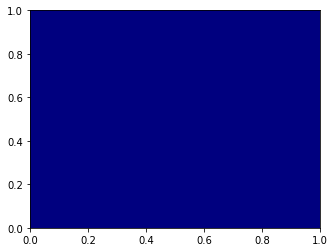

In [10]:
fig, ax = plt.subplots(1,1)
cmap = plt.cm.jet

img3 = ax.imshow(np.transpose(1000*u_pred_3d),vmax =1000,vmin=450,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)


In [11]:
np.min(u_pred_3d)

0.24514565

In [ ]:
u_pred_3d

In [ ]:
a = 0
for i in range(10):
    a = a + test_loss_full[i][-1]
print(a/10)

In [ ]:
a = 0
for i in range(10):
    a = a + train_loss_full[i][-1]
print(a/10)